In [2]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
import gammapy_fct as gf
import pandas as pd
import numpy as np
from copy import deepcopy
import astropy
import gammapy
from astropy.table import Table, vstack
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.data import DataStore, EventList
from gammapy.irf.effective_area import EffectiveAreaTable2D
from gammapy.irf.energy_dispersion import EnergyDispersion2D
from gammapy.irf.psf_gauss import EnergyDependentMultiGaussPSF
from gammapy.irf import EffectiveAreaTable2D, load_cta_irfs, Background2D

gammapy.data.HDUIndexTable.VALID_HDU_CLASS
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.data import DataStore, Observation
from gammapy.datasets import (
    Dataset,
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    MapDataset,
    MapDatasetOnOff,
    SpectrumDatasetOnOff
)
from gammapy.modeling.models import *
from gammapy.modeling.models import FoVBackgroundModel
from gammapy.maps import MapAxis, WcsNDMap, WcsGeom, Map, RegionNDMap
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
    ReflectedRegionsFinder,
    FoVBackgroundMaker
    
)
from astropy.io import fits
from gammapy.estimators import *
from gammapy.estimators.utils import find_peaks
from gammapy.visualization import plot_spectrum_datasets_off_regions

from gammapy.utils.regions import make_region
from itertools import combinations
from gammapy.visualization.utils import plot_contour_line

CPU times: user 2.32 s, sys: 900 ms, total: 3.22 s
Wall time: 5.26 s


In [3]:
source = "RGBJ0710+591"
data_store = DataStore.from_dir(f"/Users/cedrickperron/GAMMAPY/{source}")
hdu_table = data_store.hdu_table.read(f"/Users/cedrickperron/GAMMAPY/{source}/hdu-index.fits.gz")
obs_table = data_store.obs_table.read(f"/Users/cedrickperron/GAMMAPY/{source}/obs-index.fits.gz")
# Changing the path to the fits files in the HDU_table
hdu_table.remove_column("FILE_DIR")
hdu_table.add_column(f"/Users/cedrickperron/GAMMAPY/{source}", name="FILE_DIR")
hdu_table

<HDUIndexTable length=1836>
OBS_ID HDU_TYPE ...      HDU_NAME                      FILE_DIR                
int64   bytes6  ...      bytes20                        str41                  
------ -------- ... ----------------- -----------------------------------------
 43930   events ...            EVENTS /Users/cedrickperron/GAMMAPY/RGBJ0710+591
 43930      gti ...               GTI /Users/cedrickperron/GAMMAPY/RGBJ0710+591
 43930     aeff ...    EFFECTIVE AREA /Users/cedrickperron/GAMMAPY/RGBJ0710+591
 43930    edisp ... ENERGY DISPERSION /Users/cedrickperron/GAMMAPY/RGBJ0710+591
 43930      psf ...               PSF /Users/cedrickperron/GAMMAPY/RGBJ0710+591
 43930      bkg ...               BKG /Users/cedrickperron/GAMMAPY/RGBJ0710+591
 43931   events ...            EVENTS /Users/cedrickperron/GAMMAPY/RGBJ0710+591
 43931      gti ...               GTI /Users/cedrickperron/GAMMAPY/RGBJ0710+591
 43931     aeff ...    EFFECTIVE AREA /Users/cedrickperron/GAMMAPY/RGBJ0710+591
 43931    edisp ... ENERGY DISPERSION /Users/cedrickperron/GAMMAPY/RGBJ0710+591
   ...      ... ...               ...                                       ...
 81048     aeff ...    EFFECTIVE AREA /Users/cedrickperron/GAMMAPY/RGBJ0710+591
 81048    edisp ... ENERGY DISPERSION /Users/cedrickperron/GAMMAPY/RGBJ0710+591
 81048      psf ...               PSF /Users/cedrickperron/GAMMAPY/RGBJ0710+591
 81048      bkg ...               BKG /Users/cedrickperron/GAMMAPY/RGBJ0710+591
 81049   events ...            EVENTS /Users/cedrickperron/GAMMAPY/RGBJ0710+591
 81049      gti ...               GTI /Users/cedrickperron/GAMMAPY/RGBJ0710+591
 81049     aeff ...    EFFECTIVE AREA /Users/cedrickperron/GAMMAPY/RGBJ0710+591
 81049    edisp ... ENERGY DISPERSION /Users/cedrickperron/GAMMAPY/RGBJ0710+591
 81049      psf ...               PSF /Users/cedrickperron/GAMMAPY/RGBJ0710+591
 81049      bkg ...               BKG /Users/cedrickperron/GAMMAPY/RGBJ0710+591

In [4]:
obs_table = data_store.obs_table
data_store.hdu_table = hdu_table


obs_id = list(obs_table["OBS_ID"])



observations = data_store.get_observations(obs_id)

In [5]:
obs_table

<ObservationTable length=306>
OBS_ID  RA_PNT DEC_PNT  ZEN_PNT  ...    TSTART      TSTOP    N_TELS   TELLIST  
         deg     deg      deg    ...      s           s                        
int64  float32 float32  float32  ...   float32     float32   int64    bytes20  
------ ------- ------- --------- ... ----------- ----------- ------ -----------
 43930 107.624  59.639 34.410282 ... 123744744.0 123745950.0      4 T1,T2,T3,T4
 43931 107.627  58.639 31.775925 ... 123745990.0 123747200.0      4 T1,T2,T3,T4
 43932   108.6  59.136 30.627913 ... 123747250.0 123748456.0      4 T1,T2,T3,T4
 44017 106.651  59.135  27.56153 ... 124871430.0 124872630.0      4 T1,T2,T3,T4
 44032 107.627  58.639 28.354006 ... 124961220.0 124962420.0      4 T1,T2,T3,T4
 44033   108.6  59.136 29.719908 ... 124962500.0 124963416.0      4 T1,T2,T3,T4
 44034 106.651  59.135 31.400341 ... 124963480.0 124964690.0      4 T1,T2,T3,T4
 44059 107.627  58.639  35.41799 ... 125052540.0 125053750.0      4 T1,T2,T3,T4
 44060   108.6  59.136 37.828682 ... 125053800.0 125055010.0      4 T1,T2,T3,T4
   ...     ...     ...       ... ...         ...         ...    ...         ...
 80460 107.628  58.639 27.026375 ... 347003140.0 347004930.0      4 T1,T2,T3,T4
 80503 107.623  59.639 30.289732 ... 347257120.0 347258900.0      4 T1,T2,T3,T4
 80504 107.628  58.639  28.15521 ... 347258940.0 347259840.0      4 T1,T2,T3,T4
 80632   108.6  59.137 29.895706 ... 347696420.0 347698200.0      4 T1,T2,T3,T4
 80633 106.651  59.134 32.561867 ... 347698270.0 347700060.0      4 T1,T2,T3,T4
 80654 107.623  59.639 28.131544 ... 347777250.0 347779040.0      4 T1,T2,T3,T4
 80655 107.628  58.639  27.10594 ... 347779100.0 347780900.0      4 T1,T2,T3,T4
 80904 107.623  59.639  29.16472 ... 349504670.0 349506460.0      4 T1,T2,T3,T4
 81048   108.6  59.137  35.14406 ... 350285020.0 350286820.0      4 T1,T2,T3,T4
 81049 106.651  59.134 39.074577 ... 350286880.0 350288670.0      4 T1,T2,T3,T4

In [7]:
#LS5039
#107.61
#target_position=SkyCoord("276.5625 deg" , "-14.825 deg", unit="deg",frame="icrs")

target_position=SkyCoord("107.61 deg" , "59.15 deg", unit="deg",frame="icrs")

# Mrk 501
#target_position = SkyCoord(ra="253.468 deg",dec="39.7603 deg", frame="icrs")

# 1ES1959
#target_position = SkyCoord(ra="19h59m59.8s",dec="+65d08m55s", frame="icrs")

print(target_position)
#target_position = SkyCoord(ra="07h10m30.1017s",dec="+59d08m20.9639s", frame="icrs")
on_radius=Angle("0.089 deg")
on_region= CircleSkyRegion(center=target_position,radius=on_radius)



<SkyCoord (ICRS): (ra, dec) in deg
    (107.61, 59.15)>


In [8]:
energy_axis = MapAxis.from_energy_bounds(0.300, 15, 15, unit= "TeV", name="energy")
energy_axis_true= MapAxis.from_energy_bounds(0.1, 25, 20, unit= "TeV", name="energy_true")
geom = WcsGeom.create(skydir=target_position, binsz=0.02, width=(4,4), proj="CAR", axes=[energy_axis])




'\n# LS5039\nplt.figure(figsize=(8,8))\n\ngeom = WcsGeom.create(skydir=target_position, binsz=0.02, width=(4, 4), proj="CAR", axes=[energy_axis])\ngeom_image = geom.to_image()\nhess_region = make_region("icrs;circle(276.421,-13.8389, 0.50)")\ncenter_region = CircleSkyRegion(center=target_position, radius=0.35 * u.deg)\nexclusion_mask=Map.from_geom(geom_image)\n# Note Inside = True => Then all the regions outside will not have any pixels. False => Region inside have no pixel\nexclusion_mask.data=geom_image.region_mask([hess_region, center_region], inside=False)\n# No pixel => Energy => 0 (no signal)\nexclusion_mask.sum_over_axes().plot(add_cbar=True)\n'

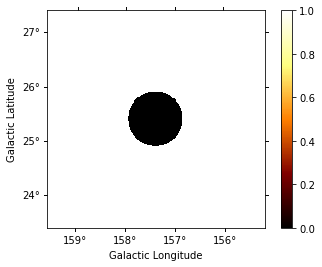

In [9]:

#All except LS5039

df=pd.read_csv('./GAMMAPY/exclusion mask.csv', sep=',',header=None)
ra_list = list(df[0])
dec_list = list(df[1])
region_list = []
for ra, dec in zip(ra_list, dec_list):
    region_list.append(make_region(f"icrs;circle({ra}, {dec}, 0.50)"))
exclusion_mask=[]
def exclusion_mask(geom, center_region):
    geom_image = geom.to_image()
    exclusion_mask=Map.from_geom(geom_image)
    if center_region not in region_list:
        region_list.append(center_region)
    exclusion_mask.data=geom_image.region_mask(region_list, inside=False)
    return exclusion_mask


geom = WcsGeom.create(skydir=target_position, binsz=0.02, width=(4, 4), frame="galactic", axes=[energy_axis])
center_region = CircleSkyRegion(center=target_position, radius=0.35* u.deg)

exclusion_mask = exclusion_mask(geom, center_region)
exclusion_mask.sum_over_axes().plot(add_cbar=True)
"""
# LS5039
plt.figure(figsize=(8,8))

geom = WcsGeom.create(skydir=target_position, binsz=0.02, width=(4, 4), proj="CAR", axes=[energy_axis])
geom_image = geom.to_image()
hess_region = make_region("icrs;circle(276.421,-13.8389, 0.50)")
center_region = CircleSkyRegion(center=target_position, radius=0.35 * u.deg)
exclusion_mask=Map.from_geom(geom_image)
# Note Inside = True => Then all the regions outside will not have any pixels. False => Region inside have no pixel
exclusion_mask.data=geom_image.region_mask([hess_region, center_region], inside=False)
# No pixel => Energy => 0 (no signal)
exclusion_mask.sum_over_axes().plot(add_cbar=True)
"""

# Datasets Creation


### Spectrum Dataset + Reflected Regions

In [580]:
dataset_empty = SpectrumDataset.create(region=on_region, e_reco=energy_axis, e_true=energy_axis_true)
dataset_maker = SpectrumDatasetMaker(containment_correction=True, selection=["counts", "exposure", "edisp", "psf"])
safe_mask_maker = SafeMaskMaker(methods=["aeff-default",  "offset-max"], offset_max=2.00*u.deg, aeff_percent = 10)
bkg_maker = ReflectedRegionsBackgroundMaker(max_region_number=6, exclusion_mask=exclusion_mask) 

In [581]:
%%time
count = 1
list_of_spec_ref = Datasets()
stacked_spec_ref = SpectrumDataset.create(region=on_region, e_reco=energy_axis, e_true=energy_axis_true)
for ind, obs in enumerate(observations):
    dataset = dataset_maker.run(dataset_empty.copy(name = f"{obs.obs_id}"), obs)
    dataset = safe_mask_maker.run(dataset, obs)
    dataset = bkg_maker.run(dataset, obs) 
    stacked_spec_ref.stack(dataset)
    print(count, dataset)
    list_of_spec_ref.append(dataset)
    count += 1

1 SpectrumDatasetOnOff
--------------------

  Name                            : 37793 

  Total counts                    : 8 
  Total off counts                : 35.00
  Total background counts         : 5.83
  Total excess counts             : 2.17

  Predicted counts                : 6.14
  Predicted background counts     : 6.14
  Predicted excess counts         : nan

  Exposure min                    : 1.03e+00 m2 s
  Exposure max                    : 2.26e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.08

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


2 SpectrumDatasetOnOff
--------------------

  Name                            : 37890 

  Total counts                    : 15 
  Total off counts        

11 SpectrumDatasetOnOff
--------------------

  Name                            : 41960 

  Total counts                    : 10 
  Total off counts                : 34.00
  Total background counts         : 5.67
  Total excess counts             : 4.33

  Predicted counts                : 6.29
  Predicted background counts     : 6.29
  Predicted excess counts         : nan

  Exposure min                    : 2.32e+02 m2 s
  Exposure max                    : 1.43e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11.36

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


12 SpectrumDatasetOnOff
--------------------

  Name                            : 41961 

  Total counts                    : 5 
  Total off counts     

21 SpectrumDatasetOnOff
--------------------

  Name                            : 53471 

  Total counts                    : 6 
  Total off counts                : 24.00
  Total background counts         : 4.00
  Total excess counts             : 2.00

  Predicted counts                : 4.29
  Predicted background counts     : 4.29
  Predicted excess counts         : nan

  Exposure min                    : 5.83e-01 m2 s
  Exposure max                    : 2.61e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.46

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


22 SpectrumDatasetOnOff
--------------------

  Name                            : 53472 

  Total counts                    : 6 
  Total off counts       

31 SpectrumDatasetOnOff
--------------------

  Name                            : 58026 

  Total counts                    : 17 
  Total off counts                : 21.00
  Total background counts         : 3.50
  Total excess counts             : 13.50

  Predicted counts                : 5.43
  Predicted background counts     : 5.43
  Predicted excess counts         : nan

  Exposure min                    : 6.11e+02 m2 s
  Exposure max                    : 2.12e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 25.86

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


32 SpectrumDatasetOnOff
--------------------

  Name                            : 58279 

  Total counts                    : 7 
  Total off counts    

41 SpectrumDatasetOnOff
--------------------

  Name                            : 62082 

  Total counts                    : 0 
  Total off counts                : 13.00
  Total background counts         : 2.17
  Total excess counts             : -2.17

  Predicted counts                : 1.86
  Predicted background counts     : 1.86
  Predicted excess counts         : nan

  Exposure min                    : 1.54e+00 m2 s
  Exposure max                    : 1.08e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.01

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


42 SpectrumDatasetOnOff
--------------------

  Name                            : 62109 

  Total counts                    : 2 
  Total off counts      

51 SpectrumDatasetOnOff
--------------------

  Name                            : 62677 

  Total counts                    : 3 
  Total off counts                : 5.00
  Total background counts         : 0.83
  Total excess counts             : 2.17

  Predicted counts                : 1.14
  Predicted background counts     : 1.14
  Predicted excess counts         : nan

  Exposure min                    : 2.28e+02 m2 s
  Exposure max                    : 1.16e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10.44

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


52 SpectrumDatasetOnOff
--------------------

  Name                            : 62695 

  Total counts                    : 7 
  Total off counts       

61 SpectrumDatasetOnOff
--------------------

  Name                            : 62993 

  Total counts                    : 14 
  Total off counts                : 16.00
  Total background counts         : 2.67
  Total excess counts             : 11.33

  Predicted counts                : 4.29
  Predicted background counts     : 4.29
  Predicted excess counts         : nan

  Exposure min                    : 1.42e+04 m2 s
  Exposure max                    : 2.97e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 29.74

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


62 SpectrumDatasetOnOff
--------------------

  Name                            : 62994 

  Total counts                    : 5 
  Total off counts    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/datasets/spectrum.py:1106: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_off = acceptance * counts_off / info["background"]


66 SpectrumDatasetOnOff
--------------------

  Name                            : 63854 

  Total counts                    : 12 
  Total off counts                : 35.00
  Total background counts         : 5.83
  Total excess counts             : 6.17

  Predicted counts                : 6.71
  Predicted background counts     : 6.71
  Predicted excess counts         : nan

  Exposure min                    : 3.72e+05 m2 s
  Exposure max                    : 4.30e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.57

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


67 SpectrumDatasetOnOff
--------------------

  Name                            : 63928 

  Total counts                    : 17 
  Total off counts     

76 SpectrumDatasetOnOff
--------------------

  Name                            : 69022 

  Total counts                    : 5 
  Total off counts                : 19.00
  Total background counts         : 3.17
  Total excess counts             : 1.83

  Predicted counts                : 3.43
  Predicted background counts     : 3.43
  Predicted excess counts         : nan

  Exposure min                    : 4.52e+04 m2 s
  Exposure max                    : 1.77e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.52

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


77 SpectrumDatasetOnOff
--------------------

  Name                            : 69068 

  Total counts                    : 12 
  Total off counts      

86 SpectrumDatasetOnOff
--------------------

  Name                            : 78576 

  Total counts                    : 21 
  Total off counts                : 68.00
  Total background counts         : 11.33
  Total excess counts             : 9.67

  Predicted counts                : 12.71
  Predicted background counts     : 12.71
  Predicted excess counts         : nan

  Exposure min                    : 6.21e+03 m2 s
  Exposure max                    : 6.87e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 17.56

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


87 SpectrumDatasetOnOff
--------------------

  Name                            : 78596 

  Total counts                    : 69 
  Total off counts 

96 SpectrumDatasetOnOff
--------------------

  Name                            : 78648 

  Total counts                    : 6 
  Total off counts                : 34.00
  Total background counts         : 5.67
  Total excess counts             : 0.33

  Predicted counts                : 5.71
  Predicted background counts     : 5.71
  Predicted excess counts         : nan

  Exposure min                    : 4.93e+03 m2 s
  Exposure max                    : 5.93e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13.11

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


97 SpectrumDatasetOnOff
--------------------

  Name                            : 78664 

  Total counts                    : 16 
  Total off counts     

106 SpectrumDatasetOnOff
--------------------

  Name                            : 81841 

  Total counts                    : 7 
  Total off counts                : 22.00
  Total background counts         : 3.67
  Total excess counts             : 3.33

  Predicted counts                : 4.14
  Predicted background counts     : 4.14
  Predicted excess counts         : nan

  Exposure min                    : 7.01e+03 m2 s
  Exposure max                    : 3.42e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 90.000

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.46

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


107 SpectrumDatasetOnOff
--------------------

  Name                            : 81868 

  Total counts                    : 50 
  Total off counts    

In [582]:
list_of_datasets = list_of_spec_ref
d = list_of_datasets.info_table(cumulative=True)[-1]

count = d["counts"]

excess_rate = []
count_rate = []
bkg_rate = []
bkg_count = d["background"]
exc_count = d['excess']
on_time = d["ontime"]

d["counts_rate"] = count/on_time
d["excess_rate"] = exc_count/on_time
d["background_rate"] = bkg_count/on_time
d["ontime"] = on_time/3600
Table(d["counts","background","excess", "sqrt_ts", "ontime", "counts_rate", 'background_rate',"excess_rate"])



<Table length=1>
 counts     background     ...    background_rate        excess_rate     
                           ...         1 / s                1 / s        
float32      float64       ...        float64              float64       
------- ------------------ ... --------------------- --------------------
 2139.0 467.16668701171875 ... 0.0034538595532248115 0.012360207628658158

In [583]:
stacked = stacked_spec_ref
d = Datasets(stacked).info_table()

count = d["counts"][0]
excess_rate = []
count_rate = []
bkg_rate = []
bkg_count = d["background"][0]
exc_count = d['excess'][0]
on_time = d["ontime"][0]
excess_rate.append(exc_count/on_time)
count_rate.append(count/on_time)
bkg_rate.append(bkg_count/on_time)
d["counts_rate"] = count_rate* 1/u.s
d["excess_rate"] = excess_rate* 1/u.s
d["background_rate"] = bkg_rate * 1/u.s
d["ontime"] = d["ontime"]/3600
d["counts","background","excess", "sqrt_ts", "ontime", "counts_rate", 'background_rate',"excess_rate"]

<Table length=1>
 counts background  excess ...    background_rate        excess_rate     
                           ...         1 / s                1 / s        
float32  float32   float32 ...        float64              float64       
------- ---------- ------- ... --------------------- --------------------
 2139.0  706.00006  1433.0 ... 0.0052196038869589696 0.010594464197418451

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/datasets/spectrum.py:1106: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_off = acceptance * counts_off / info["background"]


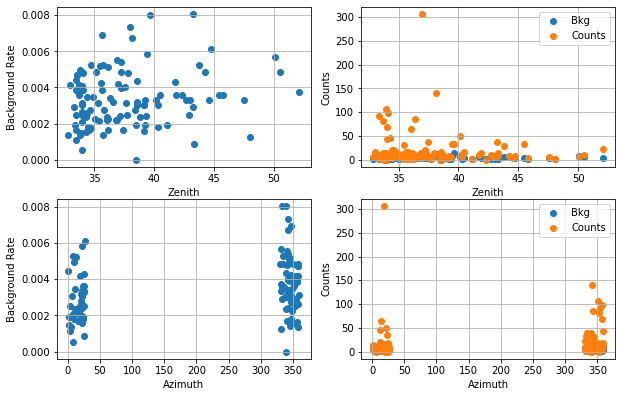

In [584]:
# Full Observations


a = list_of_datasets.info_table(cumulative=False)



zen_col = list(obs_table["ZEN_PNT"])
az_col = list(obs_table["AZ_PNT"])


from astropy.table import Column

zen_col = Column(data=zen_col, name="Zenith")
az_col = Column(data=az_col, name="Azimuth")
from astropy.table import hstack
a = hstack([a, zen_col, az_col])
a

excess_rate = []
count_rate = []
bkg_rate = []
ontime = []
for i in range(len(list(a["counts"]))):
    count = list(a["counts"])[i]
    bkg_count = list(a["background"])[i]
    exc_count = list(a['excess'])[i]
    on_time = list(a["ontime"])[i]
    excess_rate.append(exc_count/on_time)
    count_rate.append(count/on_time)
    bkg_rate.append(bkg_count/on_time)
    ontime.append(on_time/3600)
a["counts_rate"] = count_rate * 1/u.s
a["excess_rate"] = excess_rate * 1/u.s
a["background_rate"] = bkg_rate* 1/u.s
a["ontime"] = ontime*u.hr



fig = plt.figure(figsize = (10, 10))
# Background Rate vs Zenith
plt.subplot(3, 2, 1)
plt.scatter(list(a["Zenith"]), list(a["background_rate"]), label="background_rate vs Zenith")
plt.xlabel("Zenith")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 2)
plt.scatter(list(a["Zenith"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Zenith"]), list(a["counts"]), label="Counts")
plt.xlabel("Zenith")
plt.ylabel("Counts")
plt.legend()
plt.grid()

# Background Rate vs Azimuth
plt.subplot(3, 2, 3)
plt.scatter(list(a["Azimuth"]), list(a["background_rate"]), label="background_rate vs Azimuth")
plt.xlabel("Azimuth")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 4)
plt.scatter(list(a["Azimuth"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Azimuth"]), list(a["counts"]), label="Counts")
plt.xlabel("Azimuth")
plt.ylabel("Counts")
plt.legend()
plt.grid()


#a["counts","background","excess", "sqrt_ts", "ontime", "counts_rate", 'background_rate',"excess_rate"]

### MapDataset with FOV

In [642]:

dataset_empty = MapDataset.create(geom = geom, energy_axis_true=energy_axis_true, binsz_irf=0.25, meta_table=True)
dataset_maker = MapDatasetMaker(selection=["counts", "exposure", "edisp", "psf", "background"])
safe_mask_maker = SafeMaskMaker(methods=["aeff-default",  "offset-max"], offset_max=2.00*u.deg, aeff_percent = 10)
bkg_maker = FoVBackgroundMaker(method="scale", exclusion_mask=exclusion_mask, spectral_model_tag="pl-norm", )




In [643]:
stacked_map_FOV = MapDataset.create(geom = geom, energy_axis_true=energy_axis_true, binsz_irf=0.25, meta_table=True)
list_map_FOV = Datasets()
count = 1
for ind, obs in enumerate(observations):
    dataset = dataset_maker.run(dataset_empty.copy(name = f"{obs.obs_id}"), obs)
    dataset = safe_mask_maker.run(dataset, obs)
    dataset = bkg_maker.run(dataset) 
    stacked_map_FOV.stack(dataset)
    print(count, dataset)
    list_map_FOV.append(dataset)
    count += 1


/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


1 MapDataset
----------

  Name                            : 37793 

  Total counts                    : 1962 
  Total background counts         : 1025.15
  Total excess counts             : 936.85

  Predicted counts                : 1926.52
  Predicted background counts     : 1926.52
  Predicted excess counts         : 0.00

  Exposure min                    : 1.31e+02 m2 s
  Exposure max                    : 3.31e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431970 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 21759.47

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 37793-bkg
    Datasets names            : ['37793']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.879              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


2 MapDataset
----------

  Name                            : 37890 

  Total counts                    : 2085 
  Total background counts         : 923.97
  Total excess counts             : 1161.03

  Predicted counts                : 2025.40
  Predicted background counts     : 2025.40
  Predicted excess counts         : 0.00

  Exposure min                    : 1.06e+04 m2 s
  Exposure max                    : 2.45e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431970 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 22516.23

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 37890-bkg
    Datasets names            : ['37890']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.192              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


3 MapDataset
----------

  Name                            : 37991 

  Total counts                    : 1094 
  Total background counts         : 923.92
  Total excess counts             : 170.08

  Predicted counts                : 1052.94
  Predicted background counts     : 1052.94
  Predicted excess counts         : 0.00

  Exposure min                    : 5.62e+01 m2 s
  Exposure max                    : 2.61e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 13570.34

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 37991-bkg
    Datasets names            : ['37991']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.140              
      tilt         (frozen)   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


4 MapDataset
----------

  Name                            : 37992 

  Total counts                    : 1170 
  Total background counts         : 1025.11
  Total excess counts             : 144.89

  Predicted counts                : 1145.32
  Predicted background counts     : 1145.32
  Predicted excess counts         : 0.00

  Exposure min                    : 4.55e-04 m2 s
  Exposure max                    : 2.75e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431970 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 14400.08

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 37992-bkg
    Datasets names            : ['37992']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.117              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


5 MapDataset
----------

  Name                            : 38018 

  Total counts                    : 1491 
  Total background counts         : 1025.05
  Total excess counts             : 465.95

  Predicted counts                : 1458.68
  Predicted background counts     : 1458.68
  Predicted excess counts         : 0.00

  Exposure min                    : 1.38e+02 m2 s
  Exposure max                    : 3.09e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431970 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17402.80

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 38018-bkg
    Datasets names            : ['38018']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.423              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


6 MapDataset
----------

  Name                            : 38019 

  Total counts                    : 1494 
  Total background counts         : 1025.27
  Total excess counts             : 468.73

  Predicted counts                : 1426.67
  Predicted background counts     : 1426.67
  Predicted excess counts         : 0.00

  Exposure min                    : 5.71e+01 m2 s
  Exposure max                    : 3.36e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432075 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17472.07

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 38019-bkg
    Datasets names            : ['38019']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.392              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


7 MapDataset
----------

  Name                            : 41470 

  Total counts                    : 934 
  Total background counts         : 923.71
  Total excess counts             : 10.29

  Predicted counts                : 918.43
  Predicted background counts     : 918.43
  Predicted excess counts         : 0.00

  Exposure min                    : 1.14e+04 m2 s
  Exposure max                    : 1.77e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431970 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11758.66

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 41470-bkg
    Datasets names            : ['41470']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.994              
      tilt         (frozen)   :   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


8 MapDataset
----------

  Name                            : 41472 

  Total counts                    : 1013 
  Total background counts         : 923.91
  Total excess counts             : 89.09

  Predicted counts                : 1004.42
  Predicted background counts     : 1004.42
  Predicted excess counts         : 0.00

  Exposure min                    : 1.21e+04 m2 s
  Exposure max                    : 1.83e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432075 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12595.94

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 41472-bkg
    Datasets names            : ['41472']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.087              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


9 MapDataset
----------

  Name                            : 41478 

  Total counts                    : 855 
  Total background counts         : 923.86
  Total excess counts             : -68.86

  Predicted counts                : 854.48
  Predicted background counts     : 854.48
  Predicted excess counts         : 0.00

  Exposure min                    : 5.57e+03 m2 s
  Exposure max                    : 1.72e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11017.77

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 41478-bkg
    Datasets names            : ['41478']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.925              
      tilt         (frozen)   :  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


10 MapDataset
----------

  Name                            : 41713 

  Total counts                    : 845 
  Total background counts         : 512.61
  Total excess counts             : 332.39

  Predicted counts                : 801.06
  Predicted background counts     : 801.06
  Predicted excess counts         : 0.00

  Exposure min                    : 4.31e+01 m2 s
  Exposure max                    : 1.77e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 10975.00

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 41713-bkg
    Datasets names            : ['41713']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.563              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


11 MapDataset
----------

  Name                            : 41960 

  Total counts                    : 1605 
  Total background counts         : 923.93
  Total excess counts             : 681.07

  Predicted counts                : 1552.40
  Predicted background counts     : 1552.40
  Predicted excess counts         : 0.00

  Exposure min                    : 3.11e+03 m2 s
  Exposure max                    : 2.22e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 18398.76

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 41960-bkg
    Datasets names            : ['41960']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.680              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


12 MapDataset
----------

  Name                            : 41961 

  Total counts                    : 1455 
  Total background counts         : 923.97
  Total excess counts             : 531.03

  Predicted counts                : 1427.80
  Predicted background counts     : 1427.80
  Predicted excess counts         : 0.00

  Exposure min                    : 6.81e+03 m2 s
  Exposure max                    : 2.21e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432075 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17032.11

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 41961-bkg
    Datasets names            : ['41961']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.545              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


13 MapDataset
----------

  Name                            : 41962 

  Total counts                    : 1602 
  Total background counts         : 923.79
  Total excess counts             : 678.21

  Predicted counts                : 1570.04
  Predicted background counts     : 1570.04
  Predicted excess counts         : 0.00

  Exposure min                    : 1.25e+04 m2 s
  Exposure max                    : 2.33e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431970 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 18476.27

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 41962-bkg
    Datasets names            : ['41962']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.700              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


14 MapDataset
----------

  Name                            : 41963 

  Total counts                    : 1819 
  Total background counts         : 923.82
  Total excess counts             : 895.18

  Predicted counts                : 1767.39
  Predicted background counts     : 1767.39
  Predicted excess counts         : 0.00

  Exposure min                    : 1.68e+04 m2 s
  Exposure max                    : 2.36e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 20343.32

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 41963-bkg
    Datasets names            : ['41963']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.913              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


15 MapDataset
----------

  Name                            : 41964 

  Total counts                    : 1584 
  Total background counts         : 923.96
  Total excess counts             : 660.04

  Predicted counts                : 1538.06
  Predicted background counts     : 1538.06
  Predicted excess counts         : 0.00

  Exposure min                    : 6.20e+03 m2 s
  Exposure max                    : 2.42e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432075 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 18135.06

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 41964-bkg
    Datasets names            : ['41964']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.665              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


16 MapDataset
----------

  Name                            : 42073 

  Total counts                    : 1651 
  Total background counts         : 923.89
  Total excess counts             : 727.11

  Predicted counts                : 1613.04
  Predicted background counts     : 1613.04
  Predicted excess counts         : 0.00

  Exposure min                    : 4.99e+02 m2 s
  Exposure max                    : 2.57e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 19064.83

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 42073-bkg
    Datasets names            : ['42073']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.746              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


17 MapDataset
----------

  Name                            : 51601 

  Total counts                    : 946 
  Total background counts         : 923.97
  Total excess counts             : 22.03

  Predicted counts                : 923.94
  Predicted background counts     : 923.94
  Predicted excess counts         : 0.00

  Exposure min                    : 4.24e+04 m2 s
  Exposure max                    : 2.50e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11966.84

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 51601-bkg
    Datasets names            : ['51601']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


18 MapDataset
----------

  Name                            : 51602 

  Total counts                    : 892 
  Total background counts         : 923.89
  Total excess counts             : -31.89

  Predicted counts                : 893.07
  Predicted background counts     : 893.07
  Predicted excess counts         : 0.00

  Exposure min                    : 3.58e+04 m2 s
  Exposure max                    : 2.51e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431985 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11371.45

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 51602-bkg
    Datasets names            : ['51602']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.967              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


19 MapDataset
----------

  Name                            : 53469 

  Total counts                    : 1441 
  Total background counts         : 1024.76
  Total excess counts             : 416.24

  Predicted counts                : 1369.30
  Predicted background counts     : 1369.30
  Predicted excess counts         : 0.00

  Exposure min                    : 4.08e+02 m2 s
  Exposure max                    : 3.21e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431985 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17308.33

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 53469-bkg
    Datasets names            : ['53469']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.336              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


20 MapDataset
----------

  Name                            : 53470 

  Total counts                    : 1500 
  Total background counts         : 1024.93
  Total excess counts             : 475.07

  Predicted counts                : 1384.74
  Predicted background counts     : 1384.74
  Predicted excess counts         : 0.00

  Exposure min                    : 3.64e+02 m2 s
  Exposure max                    : 3.43e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432075 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17577.63

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 53470-bkg
    Datasets names            : ['53470']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.351              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


21 MapDataset
----------

  Name                            : 53471 

  Total counts                    : 1468 
  Total background counts         : 1024.77
  Total excess counts             : 443.23

  Predicted counts                : 1353.85
  Predicted background counts     : 1353.85
  Predicted excess counts         : 0.00

  Exposure min                    : 2.02e+02 m2 s
  Exposure max                    : 3.66e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17069.88

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 53471-bkg
    Datasets names            : ['53471']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.321              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


22 MapDataset
----------

  Name                            : 53472 

  Total counts                    : 1666 
  Total background counts         : 1024.81
  Total excess counts             : 641.19

  Predicted counts                : 1573.42
  Predicted background counts     : 1573.42
  Predicted excess counts         : 0.00

  Exposure min                    : 1.65e-04 m2 s
  Exposure max                    : 3.99e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 18940.51

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 53472-bkg
    Datasets names            : ['53472']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.535              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


23 MapDataset
----------

  Name                            : 53473 

  Total counts                    : 1491 
  Total background counts         : 1024.74
  Total excess counts             : 466.26

  Predicted counts                : 1414.54
  Predicted background counts     : 1414.54
  Predicted excess counts         : 0.00

  Exposure min                    : 2.84e-03 m2 s
  Exposure max                    : 4.18e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431985 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17431.24

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 53473-bkg
    Datasets names            : ['53473']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.380              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


24 MapDataset
----------

  Name                            : 53504 

  Total counts                    : 1551 
  Total background counts         : 1024.86
  Total excess counts             : 526.14

  Predicted counts                : 1487.35
  Predicted background counts     : 1487.35
  Predicted excess counts         : 0.00

  Exposure min                    : 1.05e-04 m2 s
  Exposure max                    : 4.05e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432075 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17645.52

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 53504-bkg
    Datasets names            : ['53504']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.451              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


25 MapDataset
----------

  Name                            : 53535 

  Total counts                    : 440 
  Total background counts         : 1024.71
  Total excess counts             : -584.71

  Predicted counts                : 424.80
  Predicted background counts     : 424.80
  Predicted excess counts         : 0.00

  Exposure min                    : 4.20e-04 m2 s
  Exposure max                    : 3.60e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 6147.34

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 53535-bkg
    Datasets names            : ['53535']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.415              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


26 MapDataset
----------

  Name                            : 57377 

  Total counts                    : 424 
  Total background counts         : 565.47
  Total excess counts             : -141.47

  Predicted counts                : 404.64
  Predicted background counts     : 404.64
  Predicted excess counts         : 0.00

  Exposure min                    : 6.74e+03 m2 s
  Exposure max                    : 1.71e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 6010.23

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 57377-bkg
    Datasets names            : ['57377']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.716              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


27 MapDataset
----------

  Name                            : 57379 

  Total counts                    : 588 
  Total background counts         : 923.47
  Total excess counts             : -335.47

  Predicted counts                : 568.92
  Predicted background counts     : 568.92
  Predicted excess counts         : 0.00

  Exposure min                    : 2.73e+04 m2 s
  Exposure max                    : 2.66e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 7965.75

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 57379-bkg
    Datasets names            : ['57379']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.616              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


28 MapDataset
----------

  Name                            : 57857 

  Total counts                    : 1396 
  Total background counts         : 1846.98
  Total excess counts             : -450.98

  Predicted counts                : 1310.94
  Predicted background counts     : 1310.94
  Predicted excess counts         : 0.00

  Exposure min                    : 4.44e+04 m2 s
  Exposure max                    : 5.22e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432045 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 16656.01

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 57857-bkg
    Datasets names            : ['57857']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.710              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


29 MapDataset
----------

  Name                            : 58002 

  Total counts                    : 856 
  Total background counts         : 923.39
  Total excess counts             : -67.39

  Predicted counts                : 822.51
  Predicted background counts     : 822.51
  Predicted excess counts         : 0.00

  Exposure min                    : 3.65e+04 m2 s
  Exposure max                    : 2.51e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11029.39

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 58002-bkg
    Datasets names            : ['58002']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.891              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


30 MapDataset
----------

  Name                            : 58003 

  Total counts                    : 392 
  Total background counts         : 461.72
  Total excess counts             : -69.72

  Predicted counts                : 379.28
  Predicted background counts     : 379.28
  Predicted excess counts         : 0.00

  Exposure min                    : 3.15e+04 m2 s
  Exposure max                    : 1.28e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 5643.17

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 58003-bkg
    Datasets names            : ['58003']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.821              
      tilt         (frozen)   :  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


31 MapDataset
----------

  Name                            : 58026 

  Total counts                    : 1076 
  Total background counts         : 969.54
  Total excess counts             : 106.46

  Predicted counts                : 1041.92
  Predicted background counts     : 1041.92
  Predicted excess counts         : 0.00

  Exposure min                    : 4.38e+03 m2 s
  Exposure max                    : 2.80e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431985 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 13300.79

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 58026-bkg
    Datasets names            : ['58026']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.075              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


32 MapDataset
----------

  Name                            : 58279 

  Total counts                    : 724 
  Total background counts         : 923.37
  Total excess counts             : -199.37

  Predicted counts                : 682.48
  Predicted background counts     : 682.48
  Predicted excess counts         : 0.00

  Exposure min                    : 2.20e+03 m2 s
  Exposure max                    : 2.93e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9525.57

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 58279-bkg
    Datasets names            : ['58279']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.739              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


33 MapDataset
----------

  Name                            : 61991 

  Total counts                    : 950 
  Total background counts         : 1024.48
  Total excess counts             : -74.48

  Predicted counts                : 938.98
  Predicted background counts     : 938.98
  Predicted excess counts         : 0.00

  Exposure min                    : 5.36e+02 m2 s
  Exposure max                    : 3.15e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431985 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12680.53

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 61991-bkg
    Datasets names            : ['61991']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.917              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


34 MapDataset
----------

  Name                            : 61992 

  Total counts                    : 1034 
  Total background counts         : 1024.63
  Total excess counts             : 9.37

  Predicted counts                : 990.84
  Predicted background counts     : 990.84
  Predicted excess counts         : 0.00

  Exposure min                    : 5.37e+02 m2 s
  Exposure max                    : 2.95e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432045 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 13772.75

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 61992-bkg
    Datasets names            : ['61992']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.967              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


35 MapDataset
----------

  Name                            : 61993 

  Total counts                    : 1039 
  Total background counts         : 923.44
  Total excess counts             : 115.56

  Predicted counts                : 1007.73
  Predicted background counts     : 1007.73
  Predicted excess counts         : 0.00

  Exposure min                    : 8.96e+02 m2 s
  Exposure max                    : 2.86e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12963.02

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 61993-bkg
    Datasets names            : ['61993']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.091              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


36 MapDataset
----------

  Name                            : 62015 

  Total counts                    : 837 
  Total background counts         : 1024.49
  Total excess counts             : -187.49

  Predicted counts                : 808.78
  Predicted background counts     : 808.78
  Predicted excess counts         : 0.00

  Exposure min                    : 7.13e+02 m2 s
  Exposure max                    : 3.02e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431985 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11141.96

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62015-bkg
    Datasets names            : ['62015']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.789              
      tilt         (frozen)   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


37 MapDataset
----------

  Name                            : 62016 

  Total counts                    : 900 
  Total background counts         : 1024.61
  Total excess counts             : -124.61

  Predicted counts                : 878.29
  Predicted background counts     : 878.29
  Predicted excess counts         : 0.00

  Exposure min                    : 9.06e+02 m2 s
  Exposure max                    : 2.73e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432045 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12038.48

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62016-bkg
    Datasets names            : ['62016']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.857              
      tilt         (frozen)   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


38 MapDataset
----------

  Name                            : 62017 

  Total counts                    : 882 
  Total background counts         : 1024.49
  Total excess counts             : -142.49

  Predicted counts                : 840.78
  Predicted background counts     : 840.78
  Predicted excess counts         : 0.00

  Exposure min                    : 4.40e+02 m2 s
  Exposure max                    : 2.62e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11990.02

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62017-bkg
    Datasets names            : ['62017']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.821              
      tilt         (frozen)   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


39 MapDataset
----------

  Name                            : 62018 

  Total counts                    : 872 
  Total background counts         : 923.34
  Total excess counts             : -51.34

  Predicted counts                : 818.10
  Predicted background counts     : 818.10
  Predicted excess counts         : 0.00

  Exposure min                    : 8.96e+02 m2 s
  Exposure max                    : 2.47e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11310.30

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62018-bkg
    Datasets names            : ['62018']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.886              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


40 MapDataset
----------

  Name                            : 62046 

  Total counts                    : 495 
  Total background counts         : 512.20
  Total excess counts             : -17.20

  Predicted counts                : 470.04
  Predicted background counts     : 470.04
  Predicted excess counts         : 0.00

  Exposure min                    : 7.43e+02 m2 s
  Exposure max                    : 1.55e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431985 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 7212.68

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62046-bkg
    Datasets names            : ['62046']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.918              
      tilt         (frozen)   :  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


41 MapDataset
----------

  Name                            : 62082 

  Total counts                    : 494 
  Total background counts         : 512.40
  Total excess counts             : -18.40

  Predicted counts                : 486.59
  Predicted background counts     : 486.59
  Predicted excess counts         : 0.00

  Exposure min                    : 6.65e+02 m2 s
  Exposure max                    : 1.53e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 7156.33

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62082-bkg
    Datasets names            : ['62082']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.950              
      tilt         (frozen)   :  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


42 MapDataset
----------

  Name                            : 62109 

  Total counts                    : 500 
  Total background counts         : 512.34
  Total excess counts             : -12.34

  Predicted counts                : 489.90
  Predicted background counts     : 489.90
  Predicted excess counts         : 0.00

  Exposure min                    : 3.95e+02 m2 s
  Exposure max                    : 1.48e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 7428.38

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62109-bkg
    Datasets names            : ['62109']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.956              
      tilt         (frozen)   :  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


43 MapDataset
----------

  Name                            : 62137 

  Total counts                    : 451 
  Total background counts         : 517.05
  Total excess counts             : -66.05

  Predicted counts                : 440.25
  Predicted background counts     : 440.25
  Predicted excess counts         : 0.00

  Exposure min                    : 6.72e+02 m2 s
  Exposure max                    : 1.43e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431985 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 6623.49

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62137-bkg
    Datasets names            : ['62137']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.851              
      tilt         (frozen)   :  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


44 MapDataset
----------

  Name                            : 62162 

  Total counts                    : 357 
  Total background counts         : 461.71
  Total excess counts             : -104.71

  Predicted counts                : 342.89
  Predicted background counts     : 342.89
  Predicted excess counts         : 0.00

  Exposure min                    : 2.63e+02 m2 s
  Exposure max                    : 1.27e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432045 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 5187.16

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62162-bkg
    Datasets names            : ['62162']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.743              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


45 MapDataset
----------

  Name                            : 62596 

  Total counts                    : 970 
  Total background counts         : 1381.85
  Total excess counts             : -411.85

  Predicted counts                : 928.35
  Predicted background counts     : 928.35
  Predicted excess counts         : 0.00

  Exposure min                    : 6.36e+03 m2 s
  Exposure max                    : 4.53e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12028.49

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62596-bkg
    Datasets names            : ['62596']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.672              
      tilt         (frozen)   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


46 MapDataset
----------

  Name                            : 62672 

  Total counts                    : 975 
  Total background counts         : 923.41
  Total excess counts             : 51.59

  Predicted counts                : 872.12
  Predicted background counts     : 872.12
  Predicted excess counts         : 0.00

  Exposure min                    : 6.92e+03 m2 s
  Exposure max                    : 2.93e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12233.49

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62672-bkg
    Datasets names            : ['62672']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.944              
      tilt         (frozen)   :  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


47 MapDataset
----------

  Name                            : 62673 

  Total counts                    : 911 
  Total background counts         : 923.46
  Total excess counts             : -12.46

  Predicted counts                : 773.99
  Predicted background counts     : 773.99
  Predicted excess counts         : 0.00

  Exposure min                    : 9.58e+03 m2 s
  Exposure max                    : 2.81e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11607.56

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62673-bkg
    Datasets names            : ['62673']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.838              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


48 MapDataset
----------

  Name                            : 62674 

  Total counts                    : 877 
  Total background counts         : 923.34
  Total excess counts             : -46.34

  Predicted counts                : 735.41
  Predicted background counts     : 735.41
  Predicted excess counts         : 0.00

  Exposure min                    : 1.00e+04 m2 s
  Exposure max                    : 2.74e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431985 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11203.91

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62674-bkg
    Datasets names            : ['62674']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.796              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


49 MapDataset
----------

  Name                            : 62675 

  Total counts                    : 742 
  Total background counts         : 923.45
  Total excess counts             : -181.45

  Predicted counts                : 648.30
  Predicted background counts     : 648.30
  Predicted excess counts         : 0.00

  Exposure min                    : 1.86e+04 m2 s
  Exposure max                    : 2.60e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432045 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9772.50

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62675-bkg
    Datasets names            : ['62675']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.702              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


50 MapDataset
----------

  Name                            : 62676 

  Total counts                    : 711 
  Total background counts         : 923.41
  Total excess counts             : -212.41

  Predicted counts                : 663.74
  Predicted background counts     : 663.74
  Predicted excess counts         : 0.00

  Exposure min                    : 2.58e+04 m2 s
  Exposure max                    : 2.60e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9294.29

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62676-bkg
    Datasets names            : ['62676']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.719              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


51 MapDataset
----------

  Name                            : 62677 

  Total counts                    : 424 
  Total background counts         : 576.20
  Total excess counts             : -152.20

  Predicted counts                : 400.23
  Predicted background counts     : 400.23
  Predicted excess counts         : 0.00

  Exposure min                    : 5.60e+03 m2 s
  Exposure max                    : 1.62e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 6102.77

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62677-bkg
    Datasets names            : ['62677']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.695              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


52 MapDataset
----------

  Name                            : 62695 

  Total counts                    : 506 
  Total background counts         : 646.36
  Total excess counts             : -140.36

  Predicted counts                : 495.42
  Predicted background counts     : 495.42
  Predicted excess counts         : 0.00

  Exposure min                    : 8.96e+02 m2 s
  Exposure max                    : 2.12e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431985 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 7161.06

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62695-bkg
    Datasets names            : ['62695']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.766              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


53 MapDataset
----------

  Name                            : 62697 

  Total counts                    : 429 
  Total background counts         : 472.70
  Total excess counts             : -43.70

  Predicted counts                : 424.48
  Predicted background counts     : 424.48
  Predicted excess counts         : 0.00

  Exposure min                    : 3.07e+03 m2 s
  Exposure max                    : 1.54e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432045 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 6028.97

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62697-bkg
    Datasets names            : ['62697']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.898              
      tilt         (frozen)   :  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


54 MapDataset
----------

  Name                            : 62720 

  Total counts                    : 345 
  Total background counts         : 463.81
  Total excess counts             : -118.81

  Predicted counts                : 326.36
  Predicted background counts     : 326.36
  Predicted excess counts         : 0.00

  Exposure min                    : 3.45e+03 m2 s
  Exposure max                    : 1.48e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 5019.28

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62720-bkg
    Datasets names            : ['62720']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.704              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


55 MapDataset
----------

  Name                            : 62748 

  Total counts                    : 459 
  Total background counts         : 461.62
  Total excess counts             : -2.62

  Predicted counts                : 449.84
  Predicted background counts     : 449.84
  Predicted excess counts         : 0.00

  Exposure min                    : 1.67e+03 m2 s
  Exposure max                    : 1.50e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 6413.27

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62748-bkg
    Datasets names            : ['62748']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.974              
      tilt         (frozen)   :   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


56 MapDataset
----------

  Name                            : 62773 

  Total counts                    : 469 
  Total background counts         : 461.68
  Total excess counts             : 7.32

  Predicted counts                : 448.74
  Predicted background counts     : 448.74
  Predicted excess counts         : 0.00

  Exposure min                    : 2.53e+03 m2 s
  Exposure max                    : 1.43e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 6522.18

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62773-bkg
    Datasets names            : ['62773']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.972              
      tilt         (frozen)   :   0

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


57 MapDataset
----------

  Name                            : 62793 

  Total counts                    : 962 
  Total background counts         : 982.77
  Total excess counts             : -20.77

  Predicted counts                : 929.46
  Predicted background counts     : 929.46
  Predicted excess counts         : 0.00

  Exposure min                    : 7.65e+03 m2 s
  Exposure max                    : 2.98e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431985 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12085.46

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62793-bkg
    Datasets names            : ['62793']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.946              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


58 MapDataset
----------

  Name                            : 62822 

  Total counts                    : 876 
  Total background counts         : 923.44
  Total excess counts             : -47.44

  Predicted counts                : 840.15
  Predicted background counts     : 840.15
  Predicted excess counts         : 0.00

  Exposure min                    : 5.97e+03 m2 s
  Exposure max                    : 2.75e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432045 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11132.58

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62822-bkg
    Datasets names            : ['62822']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.910              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


59 MapDataset
----------

  Name                            : 62884 

  Total counts                    : 923 
  Total background counts         : 1385.07
  Total excess counts             : -462.07

  Predicted counts                : 896.38
  Predicted background counts     : 896.38
  Predicted excess counts         : 0.00

  Exposure min                    : 8.08e+02 m2 s
  Exposure max                    : 3.58e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11847.74

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62884-bkg
    Datasets names            : ['62884']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.647              
      tilt         (frozen)   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


60 MapDataset
----------

  Name                            : 62917 

  Total counts                    : 425 
  Total background counts         : 461.66
  Total excess counts             : -36.66

  Predicted counts                : 407.95
  Predicted background counts     : 407.95
  Predicted excess counts         : 0.00

  Exposure min                    : 7.22e+03 m2 s
  Exposure max                    : 1.38e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 6087.19

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62917-bkg
    Datasets names            : ['62917']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.884              
      tilt         (frozen)   :  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


61 MapDataset
----------

  Name                            : 62993 

  Total counts                    : 865 
  Total background counts         : 1385.06
  Total excess counts             : -520.06

  Predicted counts                : 835.74
  Predicted background counts     : 835.74
  Predicted excess counts         : 0.00

  Exposure min                    : 4.13e+04 m2 s
  Exposure max                    : 3.90e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431985 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11025.62

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62993-bkg
    Datasets names            : ['62993']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.603              
      tilt         (frozen)   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


62 MapDataset
----------

  Name                            : 62994 

  Total counts                    : 329 
  Total background counts         : 461.68
  Total excess counts             : -132.68

  Predicted counts                : 324.15
  Predicted background counts     : 324.15
  Predicted excess counts         : 0.00

  Exposure min                    : 2.25e+04 m2 s
  Exposure max                    : 1.26e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432045 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 4895.85

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 62994-bkg
    Datasets names            : ['62994']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.702              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


63 MapDataset
----------

  Name                            : 63006 

  Total counts                    : 183 
  Total background counts         : 461.62
  Total excess counts             : -278.62

  Predicted counts                : 181.92
  Predicted background counts     : 181.92
  Predicted excess counts         : 0.00

  Exposure min                    : 1.83e+04 m2 s
  Exposure max                    : 1.34e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 2945.81

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 63006-bkg
    Datasets names            : ['63006']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.394              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


64 MapDataset
----------

  Name                            : 63171 

  Total counts                    : 704 
  Total background counts         : 923.39
  Total excess counts             : -219.39

  Predicted counts                : 692.40
  Predicted background counts     : 692.40
  Predicted excess counts         : 0.00

  Exposure min                    : 4.57e+04 m2 s
  Exposure max                    : 2.57e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9408.41

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 63171-bkg
    Datasets names            : ['63171']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.750              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


65 MapDataset
----------

  Name                            : 63767 

  Total counts                    : 81 
  Total background counts         : 923.44
  Total excess counts             : -842.44

  Predicted counts                : 73.87
  Predicted background counts     : 73.87
  Predicted excess counts         : 0.00

  Exposure min                    : 1.73e+04 m2 s
  Exposure max                    : 2.61e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 1412.67

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 63767-bkg
    Datasets names            : ['63767']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.080              
      tilt         (frozen)   :   0

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


66 MapDataset
----------

  Name                            : 63854 

  Total counts                    : 2091 
  Total background counts         : 923.32
  Total excess counts             : 1167.68

  Predicted counts                : 2080.52
  Predicted background counts     : 2080.52
  Predicted excess counts         : 0.00

  Exposure min                    : 4.54e+04 m2 s
  Exposure max                    : 2.23e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431985 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 22799.31

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 63854-bkg
    Datasets names            : ['63854']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.253              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


67 MapDataset
----------

  Name                            : 63928 

  Total counts                    : 1715 
  Total background counts         : 923.47
  Total excess counts             : 791.53

  Predicted counts                : 1674.78
  Predicted background counts     : 1674.78
  Predicted excess counts         : 0.00

  Exposure min                    : 1.56e+04 m2 s
  Exposure max                    : 2.18e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432045 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 19440.55

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 63928-bkg
    Datasets names            : ['63928']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.814              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


68 MapDataset
----------

  Name                            : 63998 

  Total counts                    : 1695 
  Total background counts         : 923.44
  Total excess counts             : 771.56

  Predicted counts                : 1691.32
  Predicted background counts     : 1691.32
  Predicted excess counts         : 0.00

  Exposure min                    : 1.13e+04 m2 s
  Exposure max                    : 2.22e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 19307.09

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 63998-bkg
    Datasets names            : ['63998']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.832              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


69 MapDataset
----------

  Name                            : 64085 

  Total counts                    : 2244 
  Total background counts         : 923.67
  Total excess counts             : 1320.33

  Predicted counts                : 2219.44
  Predicted background counts     : 2219.44
  Predicted excess counts         : 0.00

  Exposure min                    : 9.19e+03 m2 s
  Exposure max                    : 2.22e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 24163.96

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 64085-bkg
    Datasets names            : ['64085']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.403              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


70 MapDataset
----------

  Name                            : 64182 

  Total counts                    : 2543 
  Total background counts         : 923.37
  Total excess counts             : 1619.63

  Predicted counts                : 2533.68
  Predicted background counts     : 2533.68
  Predicted excess counts         : 0.00

  Exposure min                    : 1.59e+03 m2 s
  Exposure max                    : 2.34e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431985 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 26729.11

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 64182-bkg
    Datasets names            : ['64182']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.744              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


71 MapDataset
----------

  Name                            : 64518 

  Total counts                    : 2077 
  Total background counts         : 923.37
  Total excess counts             : 1153.63

  Predicted counts                : 2052.96
  Predicted background counts     : 2052.96
  Predicted excess counts         : 0.00

  Exposure min                    : 4.50e+03 m2 s
  Exposure max                    : 2.14e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431985 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 22671.76

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 64518-bkg
    Datasets names            : ['64518']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.223              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


72 MapDataset
----------

  Name                            : 64643 

  Total counts                    : 4272 
  Total background counts         : 1385.06
  Total excess counts             : 2886.94

  Predicted counts                : 4211.77
  Predicted background counts     : 4211.77
  Predicted excess counts         : 0.00

  Exposure min                    : 8.32e+03 m2 s
  Exposure max                    : 3.74e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431985 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 40161.47

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 64643-bkg
    Datasets names            : ['64643']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   3.041              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


73 MapDataset
----------

  Name                            : 64694 

  Total counts                    : 1428 
  Total background counts         : 692.54
  Total excess counts             : 735.46

  Predicted counts                : 1388.12
  Predicted background counts     : 1388.12
  Predicted excess counts         : 0.00

  Exposure min                    : 1.10e+04 m2 s
  Exposure max                    : 1.71e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432045 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 16497.32

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 64694-bkg
    Datasets names            : ['64694']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.004              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


74 MapDataset
----------

  Name                            : 68985 

  Total counts                    : 3058 
  Total background counts         : 1385.15
  Total excess counts             : 1672.85

  Predicted counts                : 3008.87
  Predicted background counts     : 3008.87
  Predicted excess counts         : 0.00

  Exposure min                    : 5.49e+03 m2 s
  Exposure max                    : 3.47e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 31150.60

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 68985-bkg
    Datasets names            : ['68985']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.172              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


75 MapDataset
----------

  Name                            : 68986 

  Total counts                    : 1166 
  Total background counts         : 600.24
  Total excess counts             : 565.76

  Predicted counts                : 1138.94
  Predicted background counts     : 1138.94
  Predicted excess counts         : 0.00

  Exposure min                    : 4.98e+03 m2 s
  Exposure max                    : 1.48e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 14112.32

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 68986-bkg
    Datasets names            : ['68986']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.897              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


76 MapDataset
----------

  Name                            : 69022 

  Total counts                    : 756 
  Total background counts         : 465.90
  Total excess counts             : 290.10

  Predicted counts                : 736.51
  Predicted background counts     : 736.51
  Predicted excess counts         : 0.00

  Exposure min                    : 5.09e+02 m2 s
  Exposure max                    : 1.07e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431985 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9758.93

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 69022-bkg
    Datasets names            : ['69022']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.581              
      tilt         (frozen)   :  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


77 MapDataset
----------

  Name                            : 69068 

  Total counts                    : 838 
  Total background counts         : 462.04
  Total excess counts             : 375.96

  Predicted counts                : 810.38
  Predicted background counts     : 810.38
  Predicted excess counts         : 0.00

  Exposure min                    : 3.62e+03 m2 s
  Exposure max                    : 1.18e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432045 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 10663.16

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 69068-bkg
    Datasets names            : ['69068']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.754              
      tilt         (frozen)   : 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


78 MapDataset
----------

  Name                            : 69140 

  Total counts                    : 631 
  Total background counts         : 461.72
  Total excess counts             : 169.28

  Predicted counts                : 619.64
  Predicted background counts     : 619.64
  Predicted excess counts         : 0.00

  Exposure min                    : 3.73e+03 m2 s
  Exposure max                    : 1.21e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 8403.20

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 69140-bkg
    Datasets names            : ['69140']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.342              
      tilt         (frozen)   :  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


79 MapDataset
----------

  Name                            : 69192 

  Total counts                    : 1192 
  Total background counts         : 799.87
  Total excess counts             : 392.13

  Predicted counts                : 1157.68
  Predicted background counts     : 1157.68
  Predicted excess counts         : 0.00

  Exposure min                    : 6.04e+03 m2 s
  Exposure max                    : 2.16e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 14340.71

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 69192-bkg
    Datasets names            : ['69192']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.447              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


80 MapDataset
----------

  Name                            : 69233 

  Total counts                    : 1064 
  Total background counts         : 461.68
  Total excess counts             : 602.32

  Predicted counts                : 1050.74
  Predicted background counts     : 1050.74
  Predicted excess counts         : 0.00

  Exposure min                    : 2.56e+03 m2 s
  Exposure max                    : 1.19e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 431985 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 13064.02

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 69233-bkg
    Datasets names            : ['69233']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.276              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


81 MapDataset
----------

  Name                            : 77945 

  Total counts                    : 1570 
  Total background counts         : 923.71
  Total excess counts             : 646.29

  Predicted counts                : 1516.01
  Predicted background counts     : 1516.01
  Predicted excess counts         : 0.00

  Exposure min                    : 3.86e+03 m2 s
  Exposure max                    : 2.23e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432045 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 18030.62

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 77945-bkg
    Datasets names            : ['77945']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.641              
      tilt         (frozen)  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


82 MapDataset
----------

  Name                            : 78168 

  Total counts                    : 1300 
  Total background counts         : 1153.45
  Total excess counts             : 146.55

  Predicted counts                : 1262.43
  Predicted background counts     : 1262.43
  Predicted excess counts         : 0.00

  Exposure min                    : 1.12e+04 m2 s
  Exposure max                    : 2.69e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432045 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 15527.63

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78168-bkg
    Datasets names            : ['78168']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.094              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


83 MapDataset
----------

  Name                            : 78572 

  Total counts                    : 1084 
  Total background counts         : 691.60
  Total excess counts             : 392.40

  Predicted counts                : 997.81
  Predicted background counts     : 997.81
  Predicted excess counts         : 0.00

  Exposure min                    : 6.70e+03 m2 s
  Exposure max                    : 1.68e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 13274.45

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78572-bkg
    Datasets names            : ['78572']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.443              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


84 MapDataset
----------

  Name                            : 78573 

  Total counts                    : 2883 
  Total background counts         : 1613.99
  Total excess counts             : 1269.01

  Predicted counts                : 2683.60
  Predicted background counts     : 2683.60
  Predicted excess counts         : 0.00

  Exposure min                    : 1.60e+04 m2 s
  Exposure max                    : 3.81e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432120 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 29558.42

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78573-bkg
    Datasets names            : ['78573']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.663              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


85 MapDataset
----------

  Name                            : 78574 

  Total counts                    : 3004 
  Total background counts         : 1613.84
  Total excess counts             : 1390.16

  Predicted counts                : 2793.87
  Predicted background counts     : 2793.87
  Predicted excess counts         : 0.00

  Exposure min                    : 1.40e+04 m2 s
  Exposure max                    : 4.01e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 30687.09

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78574-bkg
    Datasets names            : ['78574']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.731              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


86 MapDataset
----------

  Name                            : 78576 

  Total counts                    : 3553 
  Total background counts         : 1613.84
  Total excess counts             : 1939.16

  Predicted counts                : 3224.97
  Predicted background counts     : 3224.97
  Predicted excess counts         : 0.00

  Exposure min                    : 4.48e+03 m2 s
  Exposure max                    : 4.29e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 34917.11

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78576-bkg
    Datasets names            : ['78576']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.998              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


87 MapDataset
----------

  Name                            : 78596 

  Total counts                    : 2838 
  Total background counts         : 1383.24
  Total excess counts             : 1454.76

  Predicted counts                : 2711.18
  Predicted background counts     : 2711.18
  Predicted excess counts         : 0.00

  Exposure min                    : 1.08e+04 m2 s
  Exposure max                    : 3.36e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 29136.21

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78596-bkg
    Datasets names            : ['78596']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.960              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


88 MapDataset
----------

  Name                            : 78597 

  Total counts                    : 2510 
  Total background counts         : 1383.43
  Total excess counts             : 1126.57

  Predicted counts                : 2339.61
  Predicted background counts     : 2339.61
  Predicted excess counts         : 0.00

  Exposure min                    : 1.36e+04 m2 s
  Exposure max                    : 3.37e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432120 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 26387.43

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78597-bkg
    Datasets names            : ['78597']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.691              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


89 MapDataset
----------

  Name                            : 78598 

  Total counts                    : 2655 
  Total background counts         : 1383.26
  Total excess counts             : 1271.74

  Predicted counts                : 2503.90
  Predicted background counts     : 2503.90
  Predicted excess counts         : 0.00

  Exposure min                    : 1.23e+04 m2 s
  Exposure max                    : 3.52e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 27728.97

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78598-bkg
    Datasets names            : ['78598']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.810              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


90 MapDataset
----------

  Name                            : 78599 

  Total counts                    : 3161 
  Total background counts         : 1383.30
  Total excess counts             : 1777.70

  Predicted counts                : 2933.90
  Predicted background counts     : 2933.90
  Predicted excess counts         : 0.00

  Exposure min                    : 5.42e+03 m2 s
  Exposure max                    : 3.68e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 31790.66

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78599-bkg
    Datasets names            : ['78599']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.121              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


91 MapDataset
----------

  Name                            : 78613 

  Total counts                    : 2975 
  Total background counts         : 1383.23
  Total excess counts             : 1591.77

  Predicted counts                : 2798.28
  Predicted background counts     : 2798.28
  Predicted excess counts         : 0.00

  Exposure min                    : 1.48e+04 m2 s
  Exposure max                    : 3.38e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 30277.64

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78613-bkg
    Datasets names            : ['78613']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.023              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


92 MapDataset
----------

  Name                            : 78614 

  Total counts                    : 2884 
  Total background counts         : 1383.45
  Total excess counts             : 1500.55

  Predicted counts                : 2645.01
  Predicted background counts     : 2645.01
  Predicted excess counts         : 0.00

  Exposure min                    : 1.45e+04 m2 s
  Exposure max                    : 3.35e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432120 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 29489.04

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78614-bkg
    Datasets names            : ['78614']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.912              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


93 MapDataset
----------

  Name                            : 78615 

  Total counts                    : 2706 
  Total background counts         : 1383.28
  Total excess counts             : 1322.72

  Predicted counts                : 2528.16
  Predicted background counts     : 2528.16
  Predicted excess counts         : 0.00

  Exposure min                    : 1.45e+04 m2 s
  Exposure max                    : 3.53e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 28112.91

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78615-bkg
    Datasets names            : ['78615']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.828              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


94 MapDataset
----------

  Name                            : 78616 

  Total counts                    : 1500 
  Total background counts         : 1383.33
  Total excess counts             : 116.67

  Predicted counts                : 1403.55
  Predicted background counts     : 1403.55
  Predicted excess counts         : 0.00

  Exposure min                    : 1.05e+04 m2 s
  Exposure max                    : 3.68e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17266.60

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78616-bkg
    Datasets names            : ['78616']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.015              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


95 MapDataset
----------

  Name                            : 78647 

  Total counts                    : 1159 
  Total background counts         : 1383.33
  Total excess counts             : -224.33

  Predicted counts                : 1047.43
  Predicted background counts     : 1047.43
  Predicted excess counts         : 0.00

  Exposure min                    : 1.09e+04 m2 s
  Exposure max                    : 3.64e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 14089.24

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78647-bkg
    Datasets names            : ['78647']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.757              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


96 MapDataset
----------

  Name                            : 78648 

  Total counts                    : 1637 
  Total background counts         : 1383.13
  Total excess counts             : 253.87

  Predicted counts                : 1488.45
  Predicted background counts     : 1488.45
  Predicted excess counts         : 0.00

  Exposure min                    : 4.12e+03 m2 s
  Exposure max                    : 3.88e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 18671.07

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78648-bkg
    Datasets names            : ['78648']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.076              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


97 MapDataset
----------

  Name                            : 78664 

  Total counts                    : 711 
  Total background counts         : 691.52
  Total excess counts             : 19.48

  Predicted counts                : 674.76
  Predicted background counts     : 674.76
  Predicted excess counts         : 0.00

  Exposure min                    : 5.12e+03 m2 s
  Exposure max                    : 1.59e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9363.73

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78664-bkg
    Datasets names            : ['78664']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.976              
      tilt         (frozen)   :   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


98 MapDataset
----------

  Name                            : 78666 

  Total counts                    : 1064 
  Total background counts         : 691.69
  Total excess counts             : 372.31

  Predicted counts                : 996.70
  Predicted background counts     : 996.70
  Predicted excess counts         : 0.00

  Exposure min                    : 7.74e+03 m2 s
  Exposure max                    : 1.84e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432120 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 13093.90

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78666-bkg
    Datasets names            : ['78666']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.441              
      tilt         (frozen)   :

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


99 MapDataset
----------

  Name                            : 78705 

  Total counts                    : 2111 
  Total background counts         : 922.24
  Total excess counts             : 1188.76

  Predicted counts                : 1990.11
  Predicted background counts     : 1990.11
  Predicted excess counts         : 0.00

  Exposure min                    : 8.14e+03 m2 s
  Exposure max                    : 2.42e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 22940.19

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78705-bkg
    Datasets names            : ['78705']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.158              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


100 MapDataset
----------

  Name                            : 78760 

  Total counts                    : 3205 
  Total background counts         : 1023.25
  Total excess counts             : 2181.75

  Predicted counts                : 3061.87
  Predicted background counts     : 3061.87
  Predicted excess counts         : 0.00

  Exposure min                    : 6.58e+02 m2 s
  Exposure max                    : 3.11e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432120 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 32656.01

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 78760-bkg
    Datasets names            : ['78760']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.992              
      tilt         (frozen

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


101 MapDataset
----------

  Name                            : 79008 

  Total counts                    : 2595 
  Total background counts         : 1383.46
  Total excess counts             : 1211.54

  Predicted counts                : 2363.86
  Predicted background counts     : 2363.86
  Predicted excess counts         : 0.00

  Exposure min                    : 1.94e+03 m2 s
  Exposure max                    : 3.54e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432120 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 27085.16

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 79008-bkg
    Datasets names            : ['79008']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.709              
      tilt         (frozen

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


102 MapDataset
----------

  Name                            : 79009 

  Total counts                    : 3036 
  Total background counts         : 1383.26
  Total excess counts             : 1652.74

  Predicted counts                : 2792.77
  Predicted background counts     : 2792.77
  Predicted excess counts         : 0.00

  Exposure min                    : 1.74e+03 m2 s
  Exposure max                    : 3.78e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 30725.79

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 79009-bkg
    Datasets names            : ['79009']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.019              
      tilt         (frozen

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


103 MapDataset
----------

  Name                            : 79051 

  Total counts                    : 3572 
  Total background counts         : 1383.36
  Total excess counts             : 2188.64

  Predicted counts                : 3302.14
  Predicted background counts     : 3302.14
  Predicted excess counts         : 0.00

  Exposure min                    : 2.90e+03 m2 s
  Exposure max                    : 3.72e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432060 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 35140.94

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 79051-bkg
    Datasets names            : ['79051']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.387              
      tilt         (frozen

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


104 MapDataset
----------

  Name                            : 79082 

  Total counts                    : 3539 
  Total background counts         : 1383.19
  Total excess counts             : 2155.81

  Predicted counts                : 3179.77
  Predicted background counts     : 3179.77
  Predicted excess counts         : 0.00

  Exposure min                    : 6.48e+03 m2 s
  Exposure max                    : 3.79e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 34649.91

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 79082-bkg
    Datasets names            : ['79082']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.299              
      tilt         (frozen

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


105 MapDataset
----------

  Name                            : 79107 

  Total counts                    : 1421 
  Total background counts         : 1383.44
  Total excess counts             : 37.56

  Predicted counts                : 1318.65
  Predicted background counts     : 1318.65
  Predicted excess counts         : 0.00

  Exposure min                    : 2.68e+03 m2 s
  Exposure max                    : 3.71e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432120 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 16507.45

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 79107-bkg
    Datasets names            : ['79107']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   0.953              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


106 MapDataset
----------

  Name                            : 81841 

  Total counts                    : 2104 
  Total background counts         : 922.24
  Total excess counts             : 1181.76

  Predicted counts                : 2028.70
  Predicted background counts     : 2028.70
  Predicted excess counts         : 0.00

  Exposure min                    : 2.32e+04 m2 s
  Exposure max                    : 2.55e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432060 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 23024.46

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 81841-bkg
    Datasets names            : ['81841']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.200              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


107 MapDataset
----------

  Name                            : 81868 

  Total counts                    : 2407 
  Total background counts         : 1534.72
  Total excess counts             : 872.28

  Predicted counts                : 2310.49
  Predicted background counts     : 2310.49
  Predicted excess counts         : 0.00

  Exposure min                    : 1.30e+02 m2 s
  Exposure max                    : 3.62e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432015 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 27104.86

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 81868-bkg
    Datasets names            : ['81868']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.505              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


108 MapDataset
----------

  Name                            : 81891 

  Total counts                    : 2083 
  Total background counts         : 988.02
  Total excess counts             : 1094.98

  Predicted counts                : 1992.30
  Predicted background counts     : 1992.30
  Predicted excess counts         : 0.00

  Exposure min                    : 1.89e+04 m2 s
  Exposure max                    : 2.77e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432120 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 22588.29

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 81891-bkg
    Datasets names            : ['81891']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.016              
      tilt         (frozen)

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


109 MapDataset
----------

  Name                            : 82417 

  Total counts                    : 1437 
  Total background counts         : 511.55
  Total excess counts             : 925.45

  Predicted counts                : 1261.17
  Predicted background counts     : 1261.17
  Predicted excess counts         : 0.00

  Exposure min                    : 3.84e+02 m2 s
  Exposure max                    : 1.75e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432030 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17015.26

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 82417-bkg
    Datasets names            : ['82417']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   2.465              
      tilt         (frozen) 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


110 MapDataset
----------

  Name                            : 82514 

  Total counts                    : 2586 
  Total background counts         : 1383.46
  Total excess counts             : 1202.54

  Predicted counts                : 1879.84
  Predicted background counts     : 1879.84
  Predicted excess counts         : 0.00

  Exposure min                    : 5.86e+03 m2 s
  Exposure max                    : 3.86e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 432120 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 27623.02

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 82514-bkg
    Datasets names            : ['82514']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.359              
      tilt         (frozen

In [587]:
list_of_datasets = list_map_FOV
a = list_of_datasets.info_table(cumulative=True)
a=a[-1]
a["background_rate"]=a["background"]/a["ontime"]
a["counts_rate"]=a["counts"]/a["ontime"]
a["excess_rate"]=a["excess"]/a["ontime"]
a["ontime"] = a["ontime"]/3600 
Table(a["counts","background","excess","sqrt_ts", "ontime", 'counts_rate',"background_rate","excess_rate"])


<Table length=1>
 counts        background       ...       excess_rate      
                                ...          1 / s         
float32         float64         ...         float64        
-------- ---------------------- ... -----------------------
157547.0 2.0479047142624196e+33 ... -1.5140581420078777e+28

In [588]:

stacked = stacked_map_FOV
d = Datasets(stacked).info_table()

count = d["counts"][0]
excess_rate = []
count_rate = []
bkg_rate = []
bkg_count = d["background"][0]
exc_count = d['excess'][0]
on_time = d["ontime"][0]
excess_rate.append(exc_count/on_time)
count_rate.append(count/on_time)
bkg_rate.append(bkg_count/on_time)
d["counts_rate"] = count_rate* 1/u.s
d["excess_rate"] = excess_rate* 1/u.s
d["background_rate"] = bkg_rate * 1/u.s
d["ontime"] = d["ontime"]/3600
d["counts","background","excess", "sqrt_ts", "ontime", "counts_rate", 'background_rate',"excess_rate"]

<Table length=1>
 counts  background   excess  ...  background_rate       excess_rate     
                              ...       1 / s               1 / s        
float32   float32    float32  ...      float64             float64       
-------- ---------- --------- ... ------------------ --------------------
157547.0   149387.1 8159.9062 ... 1.1044495577744373 0.060327867843625996

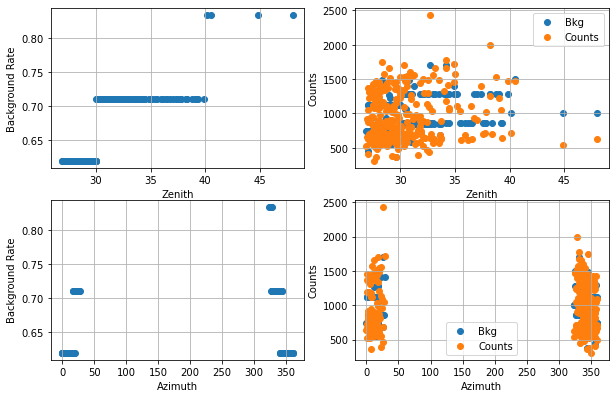

In [498]:
# Full Observations


a = list_of_datasets.info_table(cumulative=False)



zen_col = list(obs_table["ZEN_PNT"])
az_col = list(obs_table["AZ_PNT"])


from astropy.table import Column

zen_col = Column(data=zen_col, name="Zenith")
az_col = Column(data=az_col, name="Azimuth")
from astropy.table import hstack
a = hstack([a, zen_col, az_col])
a

excess_rate = []
count_rate = []
bkg_rate = []
ontime = []
for i in range(len(list(a["counts"]))):
    count = list(a["counts"])[i]
    bkg_count = list(a["background"])[i]
    exc_count = list(a['excess'])[i]
    on_time = list(a["ontime"])[i]
    excess_rate.append(exc_count/on_time)
    count_rate.append(count/on_time)
    bkg_rate.append(bkg_count/on_time)
    ontime.append(on_time/3600)
a["counts_rate"] = count_rate * 1/u.s
a["excess_rate"] = excess_rate * 1/u.s
a["background_rate"] = bkg_rate* 1/u.s
a["ontime"] = ontime*u.hr



fig = plt.figure(figsize = (10, 10))
# Background Rate vs Zenith
plt.subplot(3, 2, 1)
plt.scatter(list(a["Zenith"]), list(a["background_rate"]), label="background_rate vs Zenith")
plt.xlabel("Zenith")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 2)
plt.scatter(list(a["Zenith"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Zenith"]), list(a["counts"]), label="Counts")
plt.xlabel("Zenith")
plt.ylabel("Counts")
plt.legend()
plt.grid()

# Background Rate vs Azimuth
plt.subplot(3, 2, 3)
plt.scatter(list(a["Azimuth"]), list(a["background_rate"]), label="background_rate vs Azimuth")
plt.xlabel("Azimuth")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 4)
plt.scatter(list(a["Azimuth"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Azimuth"]), list(a["counts"]), label="Counts")
plt.xlabel("Azimuth")
plt.ylabel("Counts")
plt.legend()
plt.grid()


#a["counts","background","excess", "sqrt_ts", "ontime", "counts_rate", 'background_rate',"excess_rate"]


### Spectrum Dataset with FOV

In [499]:
list_spec_FOV = Datasets()
stacked_spec_FOV = SpectrumDataset.create(region=on_region, e_reco=energy_axis, e_true=energy_axis_true)
count = 1
spec_on_region = CircleSkyRegion(center=target_position, radius=0.089 * u.deg)
for dataset in list_map_FOV:
    dataset = dataset.to_spectrum_dataset(on_region=spec_on_region,containment_correction=True, name=dataset.name)
    dataset = safe_mask_maker.run(dataset, obs)
    dataset = bkg_maker.run(dataset, obs)
    print(count, dataset)
    list_spec_FOV.append(dataset)
    stacked_spec_FOV.stack(dataset)
    count+=1
 

1 SpectrumDataset
---------------

  Name                            : 43930 

  Total counts                    : 6 
  Total background counts         : 2.89
  Total excess counts             : 3.11

  Predicted counts                : 2.89
  Predicted background counts     : 2.89
  Predicted excess counts         : 0.00

  Exposure min                    : 5.83e+00 m2 s
  Exposure max                    : 1.27e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 14.89

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 43930-bkg
    Datasets names            : ['43930']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000     

9 SpectrumDataset
---------------

  Name                            : 44060 

  Total counts                    : 2 
  Total background counts         : 2.73
  Total excess counts             : -0.73

  Predicted counts                : 2.73
  Predicted background counts     : 2.73
  Predicted excess counts         : 0.00

  Exposure min                    : 9.75e-01 m2 s
  Exposure max                    : 1.53e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 6.95

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 44060-bkg
    Datasets names            : ['44060']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000     

17 SpectrumDataset
---------------

  Name                            : 44415 

  Total counts                    : 0 
  Total background counts         : 1.96
  Total excess counts             : -1.96

  Predicted counts                : 1.96
  Predicted background counts     : 1.96
  Predicted excess counts         : 0.00

  Exposure min                    : 2.82e+02 m2 s
  Exposure max                    : 1.13e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 3.91

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 44415-bkg
    Datasets names            : ['44415']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000    

25 SpectrumDataset
---------------

  Name                            : 44450 

  Total counts                    : 1 
  Total background counts         : 3.07
  Total excess counts             : -2.07

  Predicted counts                : 3.07
  Predicted background counts     : 3.07
  Predicted excess counts         : 0.00

  Exposure min                    : 1.45e+00 m2 s
  Exposure max                    : 1.40e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9.07

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 44450-bkg
    Datasets names            : ['44450']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000    

33 SpectrumDataset
---------------

  Name                            : 44535 

  Total counts                    : 3 
  Total background counts         : 1.55
  Total excess counts             : 1.45

  Predicted counts                : 1.55
  Predicted background counts     : 1.55
  Predicted excess counts         : 0.00

  Exposure min                    : 4.53e+02 m2 s
  Exposure max                    : 1.01e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 7.24

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 44535-bkg
    Datasets names            : ['44535']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000     

41 SpectrumDataset
---------------

  Name                            : 44570 

  Total counts                    : 5 
  Total background counts         : 1.79
  Total excess counts             : 3.21

  Predicted counts                : 1.79
  Predicted background counts     : 1.79
  Predicted excess counts         : 0.00

  Exposure min                    : 5.71e+02 m2 s
  Exposure max                    : 1.12e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17.34

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 44570-bkg
    Datasets names            : ['44570']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000    

49 SpectrumDataset
---------------

  Name                            : 44606 

  Total counts                    : 2 
  Total background counts         : 1.61
  Total excess counts             : 0.39

  Predicted counts                : 1.61
  Predicted background counts     : 1.61
  Predicted excess counts         : 0.00

  Exposure min                    : 1.11e+03 m2 s
  Exposure max                    : 1.05e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 13.83

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 44606-bkg
    Datasets names            : ['44606']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000    

57 SpectrumDataset
---------------

  Name                            : 44658 

  Total counts                    : 3 
  Total background counts         : 1.87
  Total excess counts             : 1.13

  Predicted counts                : 1.87
  Predicted background counts     : 1.87
  Predicted excess counts         : 0.00

  Exposure min                    : 2.16e+02 m2 s
  Exposure max                    : 1.08e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 13.68

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 44658-bkg
    Datasets names            : ['44658']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000    

65 SpectrumDataset
---------------

  Name                            : 44752 

  Total counts                    : 6 
  Total background counts         : 1.76
  Total excess counts             : 4.24

  Predicted counts                : 1.76
  Predicted background counts     : 1.76
  Predicted excess counts         : 0.00

  Exposure min                    : 2.41e+01 m2 s
  Exposure max                    : 5.28e+07 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 16.64

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 44752-bkg
    Datasets names            : ['44752']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000    

73 SpectrumDataset
---------------

  Name                            : 44809 

  Total counts                    : 5 
  Total background counts         : 2.34
  Total excess counts             : 2.66

  Predicted counts                : 2.34
  Predicted background counts     : 2.34
  Predicted excess counts         : 0.00

  Exposure min                    : 3.79e+02 m2 s
  Exposure max                    : 1.13e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 10.71

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 44809-bkg
    Datasets names            : ['44809']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000    

81 SpectrumDataset
---------------

  Name                            : 48939 

  Total counts                    : 2 
  Total background counts         : 1.79
  Total excess counts             : 0.21

  Predicted counts                : 1.79
  Predicted background counts     : 1.79
  Predicted excess counts         : 0.00

  Exposure min                    : 1.87e+02 m2 s
  Exposure max                    : 1.61e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 7.31

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 48939-bkg
    Datasets names            : ['48939']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000     

89 SpectrumDataset
---------------

  Name                            : 50147 

  Total counts                    : 4 
  Total background counts         : 1.57
  Total excess counts             : 2.43

  Predicted counts                : 1.57
  Predicted background counts     : 1.57
  Predicted excess counts         : 0.00

  Exposure min                    : 3.38e+03 m2 s
  Exposure max                    : 1.71e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 13.54

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 50147-bkg
    Datasets names            : ['50147']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000    

97 SpectrumDataset
---------------

  Name                            : 50532 

  Total counts                    : 1 
  Total background counts         : 1.90
  Total excess counts             : -0.90

  Predicted counts                : 1.90
  Predicted background counts     : 1.90
  Predicted excess counts         : 0.00

  Exposure min                    : 3.85e+00 m2 s
  Exposure max                    : 1.88e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12.24

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 50532-bkg
    Datasets names            : ['50532']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000   

105 SpectrumDataset
---------------

  Name                            : 50996 

  Total counts                    : 2 
  Total background counts         : 1.84
  Total excess counts             : 0.16

  Predicted counts                : 1.84
  Predicted background counts     : 1.84
  Predicted excess counts         : 0.00

  Exposure min                    : 2.12e+00 m2 s
  Exposure max                    : 1.87e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 18.74

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 50996-bkg
    Datasets names            : ['50996']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000   

113 SpectrumDataset
---------------

  Name                            : 53339 

  Total counts                    : 1 
  Total background counts         : 1.41
  Total excess counts             : -0.41

  Predicted counts                : 1.41
  Predicted background counts     : 1.41
  Predicted excess counts         : 0.00

  Exposure min                    : 1.49e+02 m2 s
  Exposure max                    : 9.77e+07 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 5.80

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 53339-bkg
    Datasets names            : ['53339']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000   

121 SpectrumDataset
---------------

  Name                            : 53868 

  Total counts                    : 6 
  Total background counts         : 2.07
  Total excess counts             : 3.93

  Predicted counts                : 2.07
  Predicted background counts     : 2.07
  Predicted excess counts         : 0.00

  Exposure min                    : 3.34e+03 m2 s
  Exposure max                    : 1.71e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 24.42

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 53868-bkg
    Datasets names            : ['53868']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000   

129 SpectrumDataset
---------------

  Name                            : 54351 

  Total counts                    : 2 
  Total background counts         : 1.81
  Total excess counts             : 0.19

  Predicted counts                : 1.81
  Predicted background counts     : 1.81
  Predicted excess counts         : 0.00

  Exposure min                    : 6.39e+03 m2 s
  Exposure max                    : 1.60e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 10.68

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 54351-bkg
    Datasets names            : ['54351']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000   

137 SpectrumDataset
---------------

  Name                            : 54748 

  Total counts                    : 2 
  Total background counts         : 0.99
  Total excess counts             : 1.01

  Predicted counts                : 0.99
  Predicted background counts     : 0.99
  Predicted excess counts         : 0.00

  Exposure min                    : 2.98e+03 m2 s
  Exposure max                    : 1.26e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 11.61

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 54748-bkg
    Datasets names            : ['54748']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000   

145 SpectrumDataset
---------------

  Name                            : 55699 

  Total counts                    : 3 
  Total background counts         : 1.98
  Total excess counts             : 1.02

  Predicted counts                : 1.98
  Predicted background counts     : 1.98
  Predicted excess counts         : 0.00

  Exposure min                    : 6.03e+02 m2 s
  Exposure max                    : 1.64e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 8.67

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 55699-bkg
    Datasets names            : ['55699']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000    

153 SpectrumDataset
---------------

  Name                            : 59066 

  Total counts                    : 3 
  Total background counts         : 1.81
  Total excess counts             : 1.19

  Predicted counts                : 1.81
  Predicted background counts     : 1.81
  Predicted excess counts         : 0.00

  Exposure min                    : 8.08e+03 m2 s
  Exposure max                    : 1.59e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9.56

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 59066-bkg
    Datasets names            : ['59066']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000    

161 SpectrumDataset
---------------

  Name                            : 59808 

  Total counts                    : 1 
  Total background counts         : 1.29
  Total excess counts             : -0.29

  Predicted counts                : 1.29
  Predicted background counts     : 1.29
  Predicted excess counts         : 0.00

  Exposure min                    : 5.41e+02 m2 s
  Exposure max                    : 1.55e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 7.25

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 59808-bkg
    Datasets names            : ['59808']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000   

169 SpectrumDataset
---------------

  Name                            : 60058 

  Total counts                    : 1 
  Total background counts         : 1.58
  Total excess counts             : -0.58

  Predicted counts                : 1.58
  Predicted background counts     : 1.58
  Predicted excess counts         : 0.00

  Exposure min                    : 1.23e+03 m2 s
  Exposure max                    : 1.63e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 5.00

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 60058-bkg
    Datasets names            : ['60058']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000   

177 SpectrumDataset
---------------

  Name                            : 64112 

  Total counts                    : 11 
  Total background counts         : 3.32
  Total excess counts             : 7.68

  Predicted counts                : 3.32
  Predicted background counts     : 3.32
  Predicted excess counts         : 0.00

  Exposure min                    : 2.91e+03 m2 s
  Exposure max                    : 2.59e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 15.56

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 64112-bkg
    Datasets names            : ['64112']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000  

185 SpectrumDataset
---------------

  Name                            : 64788 

  Total counts                    : 8 
  Total background counts         : 6.76
  Total excess counts             : 1.24

  Predicted counts                : 6.76
  Predicted background counts     : 6.76
  Predicted excess counts         : 0.00

  Exposure min                    : 8.46e+03 m2 s
  Exposure max                    : 6.50e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 12.62

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 64788-bkg
    Datasets names            : ['64788']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000   

193 SpectrumDataset
---------------

  Name                            : 65074 

  Total counts                    : 7 
  Total background counts         : 3.58
  Total excess counts             : 3.42

  Predicted counts                : 3.58
  Predicted background counts     : 3.58
  Predicted excess counts         : 0.00

  Exposure min                    : 1.20e+04 m2 s
  Exposure max                    : 2.89e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 13.58

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 65074-bkg
    Datasets names            : ['65074']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000   

201 SpectrumDataset
---------------

  Name                            : 65785 

  Total counts                    : 2 
  Total background counts         : 2.25
  Total excess counts             : -0.25

  Predicted counts                : 2.25
  Predicted background counts     : 2.25
  Predicted excess counts         : 0.00

  Exposure min                    : 6.08e+04 m2 s
  Exposure max                    : 1.88e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 7.95

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 65785-bkg
    Datasets names            : ['65785']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000   

209 SpectrumDataset
---------------

  Name                            : 66149 

  Total counts                    : 3 
  Total background counts         : 2.62
  Total excess counts             : 0.38

  Predicted counts                : 2.62
  Predicted background counts     : 2.62
  Predicted excess counts         : 0.00

  Exposure min                    : 9.29e+03 m2 s
  Exposure max                    : 1.76e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9.60

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 66149-bkg
    Datasets names            : ['66149']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000    

217 SpectrumDataset
---------------

  Name                            : 66606 

  Total counts                    : 4 
  Total background counts         : 3.60
  Total excess counts             : 0.40

  Predicted counts                : 3.60
  Predicted background counts     : 3.60
  Predicted excess counts         : 0.00

  Exposure min                    : 1.10e+04 m2 s
  Exposure max                    : 3.64e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9.86

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 66606-bkg
    Datasets names            : ['66606']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000    

225 SpectrumDataset
---------------

  Name                            : 67376 

  Total counts                    : 11 
  Total background counts         : 4.31
  Total excess counts             : 6.69

  Predicted counts                : 4.31
  Predicted background counts     : 4.31
  Predicted excess counts         : 0.00

  Exposure min                    : 3.40e+03 m2 s
  Exposure max                    : 7.06e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 15.15

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 67376-bkg
    Datasets names            : ['67376']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000  

233 SpectrumDataset
---------------

  Name                            : 71380 

  Total counts                    : 5 
  Total background counts         : 3.76
  Total excess counts             : 1.24

  Predicted counts                : 3.76
  Predicted background counts     : 3.76
  Predicted excess counts         : 0.00

  Exposure min                    : 1.26e+04 m2 s
  Exposure max                    : 2.63e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 14.49

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 71380-bkg
    Datasets names            : ['71380']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000   

241 SpectrumDataset
---------------

  Name                            : 71853 

  Total counts                    : 2 
  Total background counts         : 3.81
  Total excess counts             : -1.81

  Predicted counts                : 3.81
  Predicted background counts     : 3.81
  Predicted excess counts         : 0.00

  Exposure min                    : 6.53e+03 m2 s
  Exposure max                    : 2.72e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 10.64

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 71853-bkg
    Datasets names            : ['71853']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000  

249 SpectrumDataset
---------------

  Name                            : 76006 

  Total counts                    : 7 
  Total background counts         : 3.03
  Total excess counts             : 3.97

  Predicted counts                : 3.03
  Predicted background counts     : 3.03
  Predicted excess counts         : 0.00

  Exposure min                    : 2.10e+02 m2 s
  Exposure max                    : 3.11e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 13.63

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 76006-bkg
    Datasets names            : ['76006']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000   

257 SpectrumDataset
---------------

  Name                            : 76484 

  Total counts                    : 4 
  Total background counts         : 1.91
  Total excess counts             : 2.09

  Predicted counts                : 1.91
  Predicted background counts     : 1.91
  Predicted excess counts         : 0.00

  Exposure min                    : 2.65e+03 m2 s
  Exposure max                    : 3.10e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 9.07

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 76484-bkg
    Datasets names            : ['76484']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000    

265 SpectrumDataset
---------------

  Name                            : 77206 

  Total counts                    : 8 
  Total background counts         : 3.65
  Total excess counts             : 4.35

  Predicted counts                : 3.65
  Predicted background counts     : 3.65
  Predicted excess counts         : 0.00

  Exposure min                    : 1.74e+02 m2 s
  Exposure max                    : 6.01e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 20.00

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 77206-bkg
    Datasets names            : ['77206']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000   

273 SpectrumDataset
---------------

  Name                            : 79128 

  Total counts                    : 4 
  Total background counts         : 3.73
  Total excess counts             : 0.27

  Predicted counts                : 3.73
  Predicted background counts     : 3.73
  Predicted excess counts         : 0.00

  Exposure min                    : 4.85e+02 m2 s
  Exposure max                    : 2.98e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 8.42

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 79128-bkg
    Datasets names            : ['79128']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000    

281 SpectrumDataset
---------------

  Name                            : 79754 

  Total counts                    : 5 
  Total background counts         : 4.69
  Total excess counts             : 0.31

  Predicted counts                : 4.69
  Predicted background counts     : 4.69
  Predicted excess counts         : 0.00

  Exposure min                    : 4.77e+00 m2 s
  Exposure max                    : 6.76e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 13.85

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 79754-bkg
    Datasets names            : ['79754']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000   

289 SpectrumDataset
---------------

  Name                            : 80052 

  Total counts                    : 9 
  Total background counts         : 4.60
  Total excess counts             : 4.40

  Predicted counts                : 4.60
  Predicted background counts     : 4.60
  Predicted excess counts         : 0.00

  Exposure min                    : 1.73e+01 m2 s
  Exposure max                    : 6.41e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 14.53

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 80052-bkg
    Datasets names            : ['80052']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000   

297 SpectrumDataset
---------------

  Name                            : 80460 

  Total counts                    : 4 
  Total background counts         : 2.78
  Total excess counts             : 1.22

  Predicted counts                : 2.78
  Predicted background counts     : 2.78
  Predicted excess counts         : 0.00

  Exposure min                    : 6.57e+03 m2 s
  Exposure max                    : 2.47e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 7.81

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 80460-bkg
    Datasets names            : ['80460']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000    

305 SpectrumDataset
---------------

  Name                            : 81048 

  Total counts                    : 4 
  Total background counts         : 3.05
  Total excess counts             : 0.95

  Predicted counts                : 3.05
  Predicted background counts     : 3.05
  Predicted excess counts         : 0.00

  Exposure min                    : 2.59e+00 m2 s
  Exposure max                    : 6.39e+08 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 13.07

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : 81048-bkg
    Datasets names            : ['81048']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000   

In [500]:
list_of_datasets = list_spec_FOV
d = list_of_datasets.info_table(cumulative=True)[-1]

count = d["counts"]

excess_rate = []
count_rate = []
bkg_rate = []
bkg_count = d["background"]
exc_count = d['excess']
on_time = d["ontime"]

d["counts_rate"] = count/on_time
d["excess_rate"] = exc_count/on_time
d["background_rate"] = bkg_count/on_time
d["ontime"] /= 3600 
Table(d["counts","background","excess", "sqrt_ts", "ontime", "counts_rate", 'background_rate',"excess_rate"])


<Table length=1>
 counts     background    ...    background_rate         excess_rate     
                          ...         1 / s                 1 / s        
float32      float64      ...        float64               float64       
------- ----------------- ... --------------------- ---------------------
 1028.0 769.3970558444051 ... 0.0017984246995165927 0.0006044706287921959

In [501]:

stacked = stacked_spec_FOV
d = Datasets(stacked).info_table()

count = d["counts"][0]
excess_rate = []
count_rate = []
bkg_rate = []
bkg_count = d["background"][0]
exc_count = d['excess'][0]
on_time = d["ontime"][0]
excess_rate.append(exc_count/on_time)
count_rate.append(count/on_time)
bkg_rate.append(bkg_count/on_time)
d["counts_rate"] = count_rate* 1/u.s
d["excess_rate"] = excess_rate* 1/u.s
d["background_rate"] = bkg_rate * 1/u.s
d["ontime"] = d["ontime"]/3600 *(1/u.s)*u.hr
d["counts","background","excess", "sqrt_ts", "ontime", "counts_rate", 'background_rate',"excess_rate"]

<Table length=1>
 counts background  excess  ...    background_rate         excess_rate     
                            ...         1 / s                 1 / s        
float32  float32   float32  ...        float64               float64       
------- ---------- -------- ... --------------------- ---------------------
 1028.0   769.3971 258.6029 ... 0.0017984247903995005 0.0006044705379065261

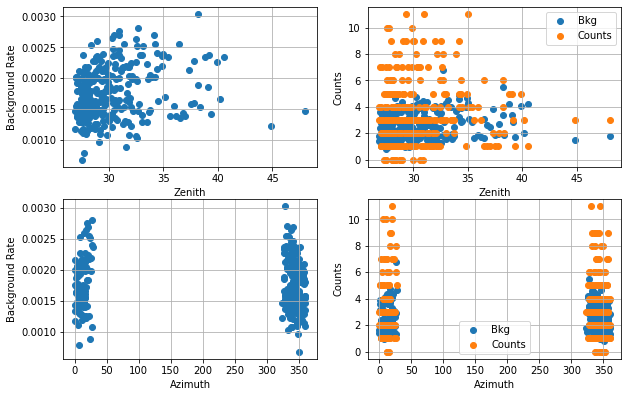

In [502]:
# Full Observations


a = list_of_datasets.info_table(cumulative=False)



zen_col = list(obs_table["ZEN_PNT"])
az_col = list(obs_table["AZ_PNT"])


from astropy.table import Column

zen_col = Column(data=zen_col, name="Zenith")
az_col = Column(data=az_col, name="Azimuth")
from astropy.table import hstack
a = hstack([a, zen_col, az_col])
a

excess_rate = []
count_rate = []
bkg_rate = []
ontime = []
for i in range(len(list(a["counts"]))):
    count = list(a["counts"])[i]
    bkg_count = list(a["background"])[i]
    exc_count = list(a['excess'])[i]
    on_time = list(a["ontime"])[i]
    excess_rate.append(exc_count/on_time)
    count_rate.append(count/on_time)
    bkg_rate.append(bkg_count/on_time)
    ontime.append(on_time/3600)
a["counts_rate"] = count_rate * 1/u.s
a["excess_rate"] = excess_rate * 1/u.s
a["background_rate"] = bkg_rate* 1/u.s
a["ontime"] = ontime*u.hr



fig = plt.figure(figsize = (10, 10))
# Background Rate vs Zenith
plt.subplot(3, 2, 1)
plt.scatter(list(a["Zenith"]), list(a["background_rate"]), label="background_rate vs Zenith")
plt.xlabel("Zenith")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 2)
plt.scatter(list(a["Zenith"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Zenith"]), list(a["counts"]), label="Counts")
plt.xlabel("Zenith")
plt.ylabel("Counts")
plt.legend()
plt.grid()

# Background Rate vs Azimuth
plt.subplot(3, 2, 3)
plt.scatter(list(a["Azimuth"]), list(a["background_rate"]), label="background_rate vs Azimuth")
plt.xlabel("Azimuth")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 4)
plt.scatter(list(a["Azimuth"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Azimuth"]), list(a["counts"]), label="Counts")
plt.xlabel("Azimuth")
plt.ylabel("Counts")
plt.legend()
plt.grid()


#a["counts","background","excess", "sqrt_ts", "ontime", "counts_rate", 'background_rate',"excess_rate"]

### Map Dataset with RING 

In [10]:

dataset_empty = MapDataset.create(geom = geom, energy_axis_true=energy_axis_true, binsz_irf=0.25, meta_table=True)
dataset_maker = MapDatasetMaker(selection=["counts", "exposure", "edisp", "psf", "background"])
safe_mask_maker = SafeMaskMaker(methods=["aeff-default",  "offset-max"], offset_max=2.00*u.deg, aeff_percent = 10)
bkg_maker = RingBackgroundMaker(r_in="0.5 deg", width="0.3 deg", exclusion_mask=exclusion_mask)



In [11]:
stacked_map_ring = MapDataset.create(geom = geom, energy_axis_true=energy_axis_true, binsz_irf=0.25, meta_table=True)
list_map_ring = Datasets()
count = 1
for ind, obs in enumerate(observations):
    dataset = dataset_maker.run(dataset_empty.copy(name = f"{obs.obs_id}"), obs)
    dataset = safe_mask_maker.run(dataset, obs)
    dataset = bkg_maker.run(dataset) 
    stacked_map_ring.stack(dataset)
    print(count, dataset)
    list_map_ring.append(dataset)
    count += 1

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


1 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 43930 

  Total counts                    : 1154 
  Total background counts         : 1114.84
  Total excess counts             : 39.16

  Predicted counts                : 1114.85
  Predicted background counts     : 1114.85
  Predicted excess counts         : nan

  Exposure min                    : 6.13e+02 m2 s
  Exposure max                    : 2.10e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11550.80

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2894830 
  Acceptance                      : 987 
  Acceptance off                  : 2453340 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


2 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 43931 

  Total counts                    : 1181 
  Total background counts         : 1106.51
  Total excess counts             : 74.49

  Predicted counts                : 1106.54
  Predicted background counts     : 1106.54
  Predicted excess counts         : nan

  Exposure min                    : 5.81e+02 m2 s
  Exposure max                    : 1.98e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11618.46

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2910154 
  Acceptance                      : 984 
  Acceptance off                  : 2441440 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


3 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 43932 

  Total counts                    : 1151 
  Total background counts         : 1112.02
  Total excess counts             : 38.98

  Predicted counts                : 1112.03
  Predicted background counts     : 1112.03
  Predicted excess counts         : nan

  Exposure min                    : 3.30e+02 m2 s
  Exposure max                    : 1.94e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11260.11

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2992628 
  Acceptance                      : 984 
  Acceptance off                  : 2443028 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


4 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44017 

  Total counts                    : 1047 
  Total background counts         : 1029.00
  Total excess counts             : 18.00

  Predicted counts                : 1029.00
  Predicted background counts     : 1029.00
  Predicted excess counts         : nan

  Exposure min                    : 7.93e+03 m2 s
  Exposure max                    : 1.85e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10437.16

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2791900 
  Acceptance                      : 968 
  Acceptance off                  : 2396804 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


5 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44032 

  Total counts                    : 1037 
  Total background counts         : 963.98
  Total excess counts             : 73.02

  Predicted counts                : 964.00
  Predicted background counts     : 964.00
  Predicted excess counts         : nan

  Exposure min                    : 6.96e+03 m2 s
  Exposure max                    : 1.88e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10640.20

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2551989 
  Acceptance                      : 965 
  Acceptance off                  : 2386492 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


6 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44033 

  Total counts                    : 749 
  Total background counts         : 739.58
  Total excess counts             : 9.42

  Predicted counts                : 739.59
  Predicted background counts     : 739.59
  Predicted excess counts         : nan

  Exposure min                    : 2.71e+03 m2 s
  Exposure max                    : 1.45e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7834.46

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1971676 
  Acceptance                      : 734 
  Acceptance off                  : 1815225 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


7 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44034 

  Total counts                    : 1112 
  Total background counts         : 1083.74
  Total excess counts             : 28.26

  Predicted counts                : 1083.75
  Predicted background counts     : 1083.75
  Predicted excess counts         : nan

  Exposure min                    : 7.68e+02 m2 s
  Exposure max                    : 1.99e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11224.25

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2881984 
  Acceptance                      : 987 
  Acceptance off                  : 2451976 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


8 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44059 

  Total counts                    : 1066 
  Total background counts         : 1037.16
  Total excess counts             : 28.84

  Predicted counts                : 1037.17
  Predicted background counts     : 1037.17
  Predicted excess counts         : nan

  Exposure min                    : 2.20e+02 m2 s
  Exposure max                    : 2.18e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10930.00

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2696550 
  Acceptance                      : 984 
  Acceptance off                  : 2442819 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


9 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44060 

  Total counts                    : 1016 
  Total background counts         : 993.68
  Total excess counts             : 22.32

  Predicted counts                : 993.69
  Predicted background counts     : 993.69
  Predicted excess counts         : nan

  Exposure min                    : 4.60e+01 m2 s
  Exposure max                    : 2.36e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10441.73

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2654323 
  Acceptance                      : 984 
  Acceptance off                  : 2443103 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


10 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44325 

  Total counts                    : 927 
  Total background counts         : 860.61
  Total excess counts             : 66.39

  Predicted counts                : 860.64
  Predicted background counts     : 860.64
  Predicted excess counts         : nan

  Exposure min                    : 3.98e+03 m2 s
  Exposure max                    : 1.88e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9598.33

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2246943 
  Acceptance                      : 965 
  Acceptance off                  : 2386802 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


11 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44363 

  Total counts                    : 1139 
  Total background counts         : 1081.05
  Total excess counts             : 57.95

  Predicted counts                : 1081.08
  Predicted background counts     : 1081.08
  Predicted excess counts         : nan

  Exposure min                    : 9.89e+01 m2 s
  Exposure max                    : 2.02e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11462.60

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2820097 
  Acceptance                      : 987 
  Acceptance off                  : 2453591 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


12 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44364 

  Total counts                    : 985 
  Total background counts         : 952.14
  Total excess counts             : 32.86

  Predicted counts                : 952.15
  Predicted background counts     : 952.15
  Predicted excess counts         : nan

  Exposure min                    : 4.70e+03 m2 s
  Exposure max                    : 1.93e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9958.06

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2480700 
  Acceptance                      : 965 
  Acceptance off                  : 2387056 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


13 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44365 

  Total counts                    : 899 
  Total background counts         : 871.71
  Total excess counts             : 27.29

  Predicted counts                : 871.72
  Predicted background counts     : 871.72
  Predicted excess counts         : nan

  Exposure min                    : 7.43e+03 m2 s
  Exposure max                    : 1.90e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9344.38

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2351621 
  Acceptance                      : 965 
  Acceptance off                  : 2388302 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


14 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44366 

  Total counts                    : 884 
  Total background counts         : 874.53
  Total excess counts             : 9.47

  Predicted counts                : 874.53
  Predicted background counts     : 874.53
  Predicted excess counts         : nan

  Exposure min                    : 8.11e+03 m2 s
  Exposure max                    : 1.86e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9203.22

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2391475 
  Acceptance                      : 968 
  Acceptance off                  : 2396726 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


15 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44367 

  Total counts                    : 869 
  Total background counts         : 832.63
  Total excess counts             : 36.37

  Predicted counts                : 832.64
  Predicted background counts     : 832.64
  Predicted excess counts         : nan

  Exposure min                    : 5.83e+03 m2 s
  Exposure max                    : 1.86e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9079.38

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2162813 
  Acceptance                      : 968 
  Acceptance off                  : 2397940 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


16 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44368 

  Total counts                    : 811 
  Total background counts         : 771.59
  Total excess counts             : 39.41

  Predicted counts                : 771.60
  Predicted background counts     : 771.60
  Predicted excess counts         : nan

  Exposure min                    : 3.37e+03 m2 s
  Exposure max                    : 1.83e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8721.70

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2050765 
  Acceptance                      : 965 
  Acceptance off                  : 2386682 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


17 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44415 

  Total counts                    : 936 
  Total background counts         : 910.22
  Total excess counts             : 25.78

  Predicted counts                : 910.23
  Predicted background counts     : 910.23
  Predicted excess counts         : nan

  Exposure min                    : 7.43e+03 m2 s
  Exposure max                    : 1.86e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9673.74

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2458913 
  Acceptance                      : 965 
  Acceptance off                  : 2388030 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


18 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44419 

  Total counts                    : 1058 
  Total background counts         : 1042.96
  Total excess counts             : 15.04

  Predicted counts                : 1042.96
  Predicted background counts     : 1042.96
  Predicted excess counts         : nan

  Exposure min                    : 2.24e+03 m2 s
  Exposure max                    : 1.94e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10488.32

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2787762 
  Acceptance                      : 987 
  Acceptance off                  : 2451924 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


19 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44420 

  Total counts                    : 1093 
  Total background counts         : 1040.76
  Total excess counts             : 52.24

  Predicted counts                : 1040.77
  Predicted background counts     : 1040.77
  Predicted excess counts         : nan

  Exposure min                    : 3.51e+03 m2 s
  Exposure max                    : 2.00e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10807.27

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2698275 
  Acceptance                      : 987 
  Acceptance off                  : 2453398 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


20 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44445 

  Total counts                    : 1311 
  Total background counts         : 1260.83
  Total excess counts             : 50.17

  Predicted counts                : 1260.85
  Predicted background counts     : 1260.85
  Predicted excess counts         : nan

  Exposure min                    : 2.42e+03 m2 s
  Exposure max                    : 1.94e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12645.35

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3260668 
  Acceptance                      : 965 
  Acceptance off                  : 2386877 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


21 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44446 

  Total counts                    : 1273 
  Total background counts         : 1237.48
  Total excess counts             : 35.52

  Predicted counts                : 1237.50
  Predicted background counts     : 1237.50
  Predicted excess counts         : nan

  Exposure min                    : 2.29e+03 m2 s
  Exposure max                    : 2.00e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12426.90

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3306069 
  Acceptance                      : 965 
  Acceptance off                  : 2388164 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


22 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44447 

  Total counts                    : 1272 
  Total background counts         : 1249.16
  Total excess counts             : 22.84

  Predicted counts                : 1249.16
  Predicted background counts     : 1249.16
  Predicted excess counts         : nan

  Exposure min                    : 6.79e+02 m2 s
  Exposure max                    : 2.07e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12448.13

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3317701 
  Acceptance                      : 987 
  Acceptance off                  : 2452184 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


23 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44448 

  Total counts                    : 1214 
  Total background counts         : 1184.74
  Total excess counts             : 29.26

  Predicted counts                : 1184.76
  Predicted background counts     : 1184.76
  Predicted excess counts         : nan

  Exposure min                    : 6.98e+02 m2 s
  Exposure max                    : 2.15e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12202.68

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3049875 
  Acceptance                      : 987 
  Acceptance off                  : 2453776 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


24 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44449 

  Total counts                    : 1235 
  Total background counts         : 1191.12
  Total excess counts             : 43.88

  Predicted counts                : 1191.13
  Predicted background counts     : 1191.13
  Predicted excess counts         : nan

  Exposure min                    : 6.04e+02 m2 s
  Exposure max                    : 2.12e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12304.13

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3088622 
  Acceptance                      : 984 
  Acceptance off                  : 2441644 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


25 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44450 

  Total counts                    : 1129 
  Total background counts         : 1133.51
  Total excess counts             : -4.51

  Predicted counts                : 1133.50
  Predicted background counts     : 1133.50
  Predicted excess counts         : nan

  Exposure min                    : 2.00e+02 m2 s
  Exposure max                    : 2.25e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11430.21

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3016421 
  Acceptance                      : 984 
  Acceptance off                  : 2443087 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


26 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44451 

  Total counts                    : 1050 
  Total background counts         : 1058.99
  Total excess counts             : -8.99

  Predicted counts                : 1058.99
  Predicted background counts     : 1058.99
  Predicted excess counts         : nan

  Exposure min                    : 1.92e+02 m2 s
  Exposure max                    : 2.44e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10689.45

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2836417 
  Acceptance                      : 987 
  Acceptance off                  : 2452268 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


27 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44521 

  Total counts                    : 1005 
  Total background counts         : 950.83
  Total excess counts             : 54.17

  Predicted counts                : 950.85
  Predicted background counts     : 950.85
  Predicted excess counts         : nan

  Exposure min                    : 3.72e+02 m2 s
  Exposure max                    : 1.95e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10245.03

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2493294 
  Acceptance                      : 987 
  Acceptance off                  : 2453495 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


28 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44522 

  Total counts                    : 906 
  Total background counts         : 892.00
  Total excess counts             : 14.00

  Predicted counts                : 892.00
  Predicted background counts     : 892.00
  Predicted excess counts         : nan

  Exposure min                    : 1.88e+03 m2 s
  Exposure max                    : 1.90e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9290.12

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2340113 
  Acceptance                      : 965 
  Acceptance off                  : 2387042 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


29 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44523 

  Total counts                    : 891 
  Total background counts         : 864.35
  Total excess counts             : 26.65

  Predicted counts                : 864.35
  Predicted background counts     : 864.35
  Predicted excess counts         : nan

  Exposure min                    : 2.39e+03 m2 s
  Exposure max                    : 1.88e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9228.03

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2312250 
  Acceptance                      : 965 
  Acceptance off                  : 2388122 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


30 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44532 

  Total counts                    : 912 
  Total background counts         : 877.16
  Total excess counts             : 34.84

  Predicted counts                : 877.17
  Predicted background counts     : 877.17
  Predicted excess counts         : nan

  Exposure min                    : 1.86e+03 m2 s
  Exposure max                    : 1.89e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9232.83

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2419131 
  Acceptance                      : 968 
  Acceptance off                  : 2396400 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


31 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44533 

  Total counts                    : 864 
  Total background counts         : 838.31
  Total excess counts             : 25.69

  Predicted counts                : 838.31
  Predicted background counts     : 838.31
  Predicted excess counts         : nan

  Exposure min                    : 2.17e+03 m2 s
  Exposure max                    : 1.88e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9078.30

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2202039 
  Acceptance                      : 968 
  Acceptance off                  : 2397967 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


32 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44534 

  Total counts                    : 824 
  Total background counts         : 766.74
  Total excess counts             : 57.26

  Predicted counts                : 766.76
  Predicted background counts     : 766.76
  Predicted excess counts         : nan

  Exposure min                    : 3.96e+03 m2 s
  Exposure max                    : 1.83e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8753.01

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2025716 
  Acceptance                      : 965 
  Acceptance off                  : 2386610 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


33 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44535 

  Total counts                    : 770 
  Total background counts         : 749.23
  Total excess counts             : 20.77

  Predicted counts                : 749.24
  Predicted background counts     : 749.24
  Predicted excess counts         : nan

  Exposure min                    : 2.51e+03 m2 s
  Exposure max                    : 1.83e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8183.17

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2052793 
  Acceptance                      : 965 
  Acceptance off                  : 2387981 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


34 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44536 

  Total counts                    : 847 
  Total background counts         : 826.40
  Total excess counts             : 20.60

  Predicted counts                : 826.41
  Predicted background counts     : 826.41
  Predicted excess counts         : nan

  Exposure min                    : 1.97e+03 m2 s
  Exposure max                    : 1.85e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8924.27

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2243797 
  Acceptance                      : 968 
  Acceptance off                  : 2396560 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


35 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44538 

  Total counts                    : 896 
  Total background counts         : 855.36
  Total excess counts             : 40.64

  Predicted counts                : 855.37
  Predicted background counts     : 855.37
  Predicted excess counts         : nan

  Exposure min                    : 2.83e+03 m2 s
  Exposure max                    : 1.93e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9199.36

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2228239 
  Acceptance                      : 981 
  Acceptance off                  : 2436851 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


36 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44543 

  Total counts                    : 773 
  Total background counts         : 737.13
  Total excess counts             : 35.87

  Predicted counts                : 737.14
  Predicted background counts     : 737.14
  Predicted excess counts         : nan

  Exposure min                    : 3.72e+03 m2 s
  Exposure max                    : 1.85e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8221.79

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1934653 
  Acceptance                      : 965 
  Acceptance off                  : 2386596 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


37 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44550 

  Total counts                    : 864 
  Total background counts         : 844.23
  Total excess counts             : 19.77

  Predicted counts                : 844.23
  Predicted background counts     : 844.23
  Predicted excess counts         : nan

  Exposure min                    : 1.37e+03 m2 s
  Exposure max                    : 1.91e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9019.48

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2259539 
  Acceptance                      : 965 
  Acceptance off                  : 2387892 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


38 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44551 

  Total counts                    : 748 
  Total background counts         : 753.54
  Total excess counts             : -5.54

  Predicted counts                : 753.53
  Predicted background counts     : 753.53
  Predicted excess counts         : nan

  Exposure min                    : 2.72e+03 m2 s
  Exposure max                    : 1.87e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7992.30

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2058368 
  Acceptance                      : 968 
  Acceptance off                  : 2396420 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


39 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44552 

  Total counts                    : 837 
  Total background counts         : 804.75
  Total excess counts             : 32.25

  Predicted counts                : 804.76
  Predicted background counts     : 804.76
  Predicted excess counts         : nan

  Exposure min                    : 2.64e+03 m2 s
  Exposure max                    : 1.87e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8680.46

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2119243 
  Acceptance                      : 968 
  Acceptance off                  : 2397885 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


40 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44569 

  Total counts                    : 1043 
  Total background counts         : 1022.86
  Total excess counts             : 20.14

  Predicted counts                : 1022.86
  Predicted background counts     : 1022.86
  Predicted excess counts         : nan

  Exposure min                    : 3.64e+02 m2 s
  Exposure max                    : 1.96e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10460.61

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2726684 
  Acceptance                      : 984 
  Acceptance off                  : 2443050 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


41 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44570 

  Total counts                    : 903 
  Total background counts         : 898.35
  Total excess counts             : 4.65

  Predicted counts                : 898.35
  Predicted background counts     : 898.35
  Predicted excess counts         : nan

  Exposure min                    : 2.41e+03 m2 s
  Exposure max                    : 1.91e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9279.23

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2440653 
  Acceptance                      : 968 
  Acceptance off                  : 2396753 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


42 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44571 

  Total counts                    : 904 
  Total background counts         : 848.03
  Total excess counts             : 55.97

  Predicted counts                : 848.05
  Predicted background counts     : 848.05
  Predicted excess counts         : nan

  Exposure min                    : 2.55e+03 m2 s
  Exposure max                    : 1.90e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9579.52

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2252509 
  Acceptance                      : 968 
  Acceptance off                  : 2398177 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


43 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44572 

  Total counts                    : 812 
  Total background counts         : 759.40
  Total excess counts             : 52.60

  Predicted counts                : 759.42
  Predicted background counts     : 759.42
  Predicted excess counts         : nan

  Exposure min                    : 4.07e+03 m2 s
  Exposure max                    : 1.85e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8654.75

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1986143 
  Acceptance                      : 965 
  Acceptance off                  : 2386763 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


44 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44573 

  Total counts                    : 803 
  Total background counts         : 796.68
  Total excess counts             : 6.32

  Predicted counts                : 796.68
  Predicted background counts     : 796.68
  Predicted excess counts         : nan

  Exposure min                    : 2.51e+03 m2 s
  Exposure max                    : 1.84e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8459.05

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2149879 
  Acceptance                      : 965 
  Acceptance off                  : 2388080 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


45 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44574 

  Total counts                    : 777 
  Total background counts         : 764.39
  Total excess counts             : 12.61

  Predicted counts                : 764.39
  Predicted background counts     : 764.39
  Predicted excess counts         : nan

  Exposure min                    : 2.06e+03 m2 s
  Exposure max                    : 1.86e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8163.83

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2094469 
  Acceptance                      : 968 
  Acceptance off                  : 2396478 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


46 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44575 

  Total counts                    : 858 
  Total background counts         : 822.01
  Total excess counts             : 35.99

  Predicted counts                : 822.02
  Predicted background counts     : 822.02
  Predicted excess counts         : nan

  Exposure min                    : 1.04e+03 m2 s
  Exposure max                    : 1.90e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8923.35

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2150961 
  Acceptance                      : 968 
  Acceptance off                  : 2397842 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


47 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44604 

  Total counts                    : 849 
  Total background counts         : 786.34
  Total excess counts             : 62.66

  Predicted counts                : 786.37
  Predicted background counts     : 786.37
  Predicted excess counts         : nan

  Exposure min                    : 3.08e+03 m2 s
  Exposure max                    : 1.88e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8915.17

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2073900 
  Acceptance                      : 965 
  Acceptance off                  : 2386859 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


48 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44605 

  Total counts                    : 843 
  Total background counts         : 824.60
  Total excess counts             : 18.40

  Predicted counts                : 824.61
  Predicted background counts     : 824.61
  Predicted excess counts         : nan

  Exposure min                    : 3.06e+03 m2 s
  Exposure max                    : 1.87e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8737.89

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2228561 
  Acceptance                      : 965 
  Acceptance off                  : 2388000 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


49 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44606 

  Total counts                    : 830 
  Total background counts         : 792.02
  Total excess counts             : 37.98

  Predicted counts                : 792.04
  Predicted background counts     : 792.04
  Predicted excess counts         : nan

  Exposure min                    : 3.56e+03 m2 s
  Exposure max                    : 1.86e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8738.09

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2166238 
  Acceptance                      : 968 
  Acceptance off                  : 2396508 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


50 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44607 

  Total counts                    : 856 
  Total background counts         : 794.06
  Total excess counts             : 61.94

  Predicted counts                : 794.08
  Predicted background counts     : 794.08
  Predicted excess counts         : nan

  Exposure min                    : 1.90e+03 m2 s
  Exposure max                    : 1.87e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9063.11

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2092345 
  Acceptance                      : 968 
  Acceptance off                  : 2397784 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


51 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44608 

  Total counts                    : 846 
  Total background counts         : 781.33
  Total excess counts             : 64.67

  Predicted counts                : 781.35
  Predicted background counts     : 781.35
  Predicted excess counts         : nan

  Exposure min                    : 2.17e+03 m2 s
  Exposure max                    : 1.86e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8953.18

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2075038 
  Acceptance                      : 965 
  Acceptance off                  : 2386487 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


52 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44633 

  Total counts                    : 789 
  Total background counts         : 777.63
  Total excess counts             : 11.37

  Predicted counts                : 777.63
  Predicted background counts     : 777.63
  Predicted excess counts         : nan

  Exposure min                    : 2.92e+03 m2 s
  Exposure max                    : 1.93e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8384.43

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2071514 
  Acceptance                      : 965 
  Acceptance off                  : 2388059 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


53 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44634 

  Total counts                    : 860 
  Total background counts         : 837.60
  Total excess counts             : 22.40

  Predicted counts                : 837.61
  Predicted background counts     : 837.61
  Predicted excess counts         : nan

  Exposure min                    : 3.95e+03 m2 s
  Exposure max                    : 1.89e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9086.39

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2304947 
  Acceptance                      : 968 
  Acceptance off                  : 2396475 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


54 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44653 

  Total counts                    : 1008 
  Total background counts         : 948.95
  Total excess counts             : 59.05

  Predicted counts                : 948.97
  Predicted background counts     : 948.97
  Predicted excess counts         : nan

  Exposure min                    : 5.83e+02 m2 s
  Exposure max                    : 1.94e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10280.59

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2492157 
  Acceptance                      : 968 
  Acceptance off                  : 2397944 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


55 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44654 

  Total counts                    : 887 
  Total background counts         : 841.82
  Total excess counts             : 45.18

  Predicted counts                : 841.84
  Predicted background counts     : 841.84
  Predicted excess counts         : nan

  Exposure min                    : 3.10e+03 m2 s
  Exposure max                    : 1.88e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9042.08

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2200787 
  Acceptance                      : 965 
  Acceptance off                  : 2386654 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


56 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44655 

  Total counts                    : 761 
  Total background counts         : 769.66
  Total excess counts             : -8.66

  Predicted counts                : 769.65
  Predicted background counts     : 769.65
  Predicted excess counts         : nan

  Exposure min                    : 3.06e+03 m2 s
  Exposure max                    : 1.76e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8154.44

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2034027 
  Acceptance                      : 908 
  Acceptance off                  : 2247184 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


57 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44658 

  Total counts                    : 913 
  Total background counts         : 896.18
  Total excess counts             : 16.82

  Predicted counts                : 896.18
  Predicted background counts     : 896.18
  Predicted excess counts         : nan

  Exposure min                    : 1.47e+03 m2 s
  Exposure max                    : 1.90e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9432.17

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2455235 
  Acceptance                      : 968 
  Acceptance off                  : 2396535 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


58 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44685 

  Total counts                    : 933 
  Total background counts         : 932.66
  Total excess counts             : 0.34

  Predicted counts                : 932.66
  Predicted background counts     : 932.66
  Predicted excess counts         : nan

  Exposure min                    : 2.98e+03 m2 s
  Exposure max                    : 1.86e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9602.90

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2550117 
  Acceptance                      : 968 
  Acceptance off                  : 2396618 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


59 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44686 

  Total counts                    : 942 
  Total background counts         : 874.35
  Total excess counts             : 67.65

  Predicted counts                : 874.37
  Predicted background counts     : 874.37
  Predicted excess counts         : nan

  Exposure min                    : 2.81e+03 m2 s
  Exposure max                    : 1.86e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9703.35

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2315505 
  Acceptance                      : 968 
  Acceptance off                  : 2398527 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


60 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44687 

  Total counts                    : 535 
  Total background counts         : 496.90
  Total excess counts             : 38.10

  Predicted counts                : 496.91
  Predicted background counts     : 496.91
  Predicted excess counts         : nan

  Exposure min                    : 1.86e+03 m2 s
  Exposure max                    : 1.09e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5995.98

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1310282 
  Acceptance                      : 580 
  Acceptance off                  : 1434395 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


61 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44688 

  Total counts                    : 919 
  Total background counts         : 897.92
  Total excess counts             : 21.08

  Predicted counts                : 897.93
  Predicted background counts     : 897.93
  Predicted excess counts         : nan

  Exposure min                    : 2.17e+03 m2 s
  Exposure max                    : 1.85e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9416.16

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2429302 
  Acceptance                      : 965 
  Acceptance off                  : 2388229 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


62 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44692 

  Total counts                    : 775 
  Total background counts         : 754.41
  Total excess counts             : 20.59

  Predicted counts                : 754.41
  Predicted background counts     : 754.41
  Predicted excess counts         : nan

  Exposure min                    : 4.82e+02 m2 s
  Exposure max                    : 1.92e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8401.60

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2032983 
  Acceptance                      : 987 
  Acceptance off                  : 2451837 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


63 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44719 

  Total counts                    : 1049 
  Total background counts         : 990.09
  Total excess counts             : 58.91

  Predicted counts                : 990.11
  Predicted background counts     : 990.11
  Predicted excess counts         : nan

  Exposure min                    : 8.97e+02 m2 s
  Exposure max                    : 1.90e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10699.78

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2588714 
  Acceptance                      : 965 
  Acceptance off                  : 2386722 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


64 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44720 

  Total counts                    : 1167 
  Total background counts         : 1134.95
  Total excess counts             : 32.05

  Predicted counts                : 1134.96
  Predicted background counts     : 1134.96
  Predicted excess counts         : nan

  Exposure min                    : 3.59e+02 m2 s
  Exposure max                    : 1.97e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11629.72

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3049263 
  Acceptance                      : 984 
  Acceptance off                  : 2442993 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


65 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44752 

  Total counts                    : 781 
  Total background counts         : 750.70
  Total excess counts             : 30.30

  Predicted counts                : 750.71
  Predicted background counts     : 750.71
  Predicted excess counts         : nan

  Exposure min                    : 6.65e-03 m2 s
  Exposure max                    : 1.49e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8294.85

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2013607 
  Acceptance                      : 987 
  Acceptance off                  : 2452054 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


66 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44776 

  Total counts                    : 1013 
  Total background counts         : 984.24
  Total excess counts             : 28.76

  Predicted counts                : 984.25
  Predicted background counts     : 984.25
  Predicted excess counts         : nan

  Exposure min                    : 6.03e+03 m2 s
  Exposure max                    : 1.85e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10224.93

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2650829 
  Acceptance                      : 968 
  Acceptance off                  : 2396646 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


67 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44777 

  Total counts                    : 1046 
  Total background counts         : 1012.84
  Total excess counts             : 33.16

  Predicted counts                : 1012.85
  Predicted background counts     : 1012.85
  Predicted excess counts         : nan

  Exposure min                    : 4.20e+03 m2 s
  Exposure max                    : 1.86e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10740.46

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2660854 
  Acceptance                      : 968 
  Acceptance off                  : 2397890 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


68 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44778 

  Total counts                    : 1075 
  Total background counts         : 1030.11
  Total excess counts             : 44.89

  Predicted counts                : 1030.13
  Predicted background counts     : 1030.13
  Predicted excess counts         : nan

  Exposure min                    : 3.82e+03 m2 s
  Exposure max                    : 1.84e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10637.27

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2697365 
  Acceptance                      : 965 
  Acceptance off                  : 2386575 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


69 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44779 

  Total counts                    : 1056 
  Total background counts         : 1043.64
  Total excess counts             : 12.36

  Predicted counts                : 1043.64
  Predicted background counts     : 1043.64
  Predicted excess counts         : nan

  Exposure min                    : 2.17e+03 m2 s
  Exposure max                    : 1.89e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10766.29

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2799545 
  Acceptance                      : 965 
  Acceptance off                  : 2388080 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


70 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44781 

  Total counts                    : 1083 
  Total background counts         : 1070.17
  Total excess counts             : 12.83

  Predicted counts                : 1070.16
  Predicted background counts     : 1070.16
  Predicted excess counts         : nan

  Exposure min                    : 4.67e+02 m2 s
  Exposure max                    : 2.01e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10743.24

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2874914 
  Acceptance                      : 987 
  Acceptance off                  : 2452371 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


71 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44807 

  Total counts                    : 1136 
  Total background counts         : 1091.92
  Total excess counts             : 44.08

  Predicted counts                : 1091.93
  Predicted background counts     : 1091.93
  Predicted excess counts         : nan

  Exposure min                    : 6.09e+03 m2 s
  Exposure max                    : 1.84e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11382.96

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2859227 
  Acceptance                      : 965 
  Acceptance off                  : 2386756 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


72 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44808 

  Total counts                    : 1179 
  Total background counts         : 1167.36
  Total excess counts             : 11.64

  Predicted counts                : 1167.36
  Predicted background counts     : 1167.36
  Predicted excess counts         : nan

  Exposure min                    : 1.03e+04 m2 s
  Exposure max                    : 1.85e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11752.85

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3149417 
  Acceptance                      : 965 
  Acceptance off                  : 2388095 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


73 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44809 

  Total counts                    : 1119 
  Total background counts         : 1104.50
  Total excess counts             : 14.50

  Predicted counts                : 1104.50
  Predicted background counts     : 1104.50
  Predicted excess counts         : nan

  Exposure min                    : 8.03e+03 m2 s
  Exposure max                    : 1.88e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11246.44

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2954472 
  Acceptance                      : 968 
  Acceptance off                  : 2396518 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


74 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44810 

  Total counts                    : 1137 
  Total background counts         : 1083.24
  Total excess counts             : 53.76

  Predicted counts                : 1083.26
  Predicted background counts     : 1083.26
  Predicted excess counts         : nan

  Exposure min                    : 3.55e+03 m2 s
  Exposure max                    : 1.92e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11396.58

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2827602 
  Acceptance                      : 968 
  Acceptance off                  : 2397802 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


75 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 44813 

  Total counts                    : 1218 
  Total background counts         : 1162.93
  Total excess counts             : 55.07

  Predicted counts                : 1162.95
  Predicted background counts     : 1162.95
  Predicted excess counts         : nan

  Exposure min                    : 2.98e+03 m2 s
  Exposure max                    : 2.06e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12068.98

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3005918 
  Acceptance                      : 987 
  Acceptance off                  : 2453598 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


76 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 48622 

  Total counts                    : 845 
  Total background counts         : 818.22
  Total excess counts             : 26.78

  Predicted counts                : 818.22
  Predicted background counts     : 818.22
  Predicted excess counts         : nan

  Exposure min                    : 1.33e+04 m2 s
  Exposure max                    : 2.05e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8896.98

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2116259 
  Acceptance                      : 965 
  Acceptance off                  : 2386741 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


77 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 48623 

  Total counts                    : 844 
  Total background counts         : 825.85
  Total excess counts             : 18.15

  Predicted counts                : 825.85
  Predicted background counts     : 825.85
  Predicted excess counts         : nan

  Exposure min                    : 1.38e+04 m2 s
  Exposure max                    : 2.09e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8789.41

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2219593 
  Acceptance                      : 965 
  Acceptance off                  : 2388362 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


78 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 48624 

  Total counts                    : 929 
  Total background counts         : 892.99
  Total excess counts             : 36.01

  Predicted counts                : 892.99
  Predicted background counts     : 892.99
  Predicted excess counts         : nan

  Exposure min                    : 1.17e+04 m2 s
  Exposure max                    : 2.12e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9615.19

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2444806 
  Acceptance                      : 968 
  Acceptance off                  : 2396770 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


79 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 48625 

  Total counts                    : 495 
  Total background counts         : 481.91
  Total excess counts             : 13.09

  Predicted counts                : 481.92
  Predicted background counts     : 481.92
  Predicted excess counts         : nan

  Exposure min                    : 5.86e+03 m2 s
  Exposure max                    : 1.08e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5693.52

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1264352 
  Acceptance                      : 484 
  Acceptance off                  : 1198354 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


80 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 48938 

  Total counts                    : 962 
  Total background counts         : 926.63
  Total excess counts             : 35.37

  Predicted counts                : 926.64
  Predicted background counts     : 926.64
  Predicted excess counts         : nan

  Exposure min                    : 1.44e+04 m2 s
  Exposure max                    : 2.24e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9683.67

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2385270 
  Acceptance                      : 984 
  Acceptance off                  : 2441628 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


81 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 48939 

  Total counts                    : 763 
  Total background counts         : 754.73
  Total excess counts             : 8.27

  Predicted counts                : 754.72
  Predicted background counts     : 754.72
  Predicted excess counts         : nan

  Exposure min                    : 8.93e+03 m2 s
  Exposure max                    : 2.33e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8370.04

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2000463 
  Acceptance                      : 984 
  Acceptance off                  : 2443124 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


82 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 49286 

  Total counts                    : 1166 
  Total background counts         : 1101.86
  Total excess counts             : 64.14

  Predicted counts                : 1101.88
  Predicted background counts     : 1101.88
  Predicted excess counts         : nan

  Exposure min                    : 3.25e+03 m2 s
  Exposure max                    : 2.15e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11532.27

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2894655 
  Acceptance                      : 968 
  Acceptance off                  : 2398071 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


83 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 49311 

  Total counts                    : 1194 
  Total background counts         : 1186.54
  Total excess counts             : 7.46

  Predicted counts                : 1186.54
  Predicted background counts     : 1186.54
  Predicted excess counts         : nan

  Exposure min                    : 3.57e+03 m2 s
  Exposure max                    : 2.30e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11759.54

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3129149 
  Acceptance                      : 984 
  Acceptance off                  : 2443032 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


84 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50092 

  Total counts                    : 749 
  Total background counts         : 715.28
  Total excess counts             : 33.72

  Predicted counts                : 715.30
  Predicted background counts     : 715.30
  Predicted excess counts         : nan

  Exposure min                    : 1.72e+04 m2 s
  Exposure max                    : 1.83e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8300.75

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1882166 
  Acceptance                      : 968 
  Acceptance off                  : 2397595 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


85 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50093 

  Total counts                    : 649 
  Total background counts         : 632.38
  Total excess counts             : 16.62

  Predicted counts                : 632.39
  Predicted background counts     : 632.39
  Predicted excess counts         : nan

  Exposure min                    : 1.79e+04 m2 s
  Exposure max                    : 1.82e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7354.61

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1629627 
  Acceptance                      : 964 
  Acceptance off                  : 2386430 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


86 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50122 

  Total counts                    : 763 
  Total background counts         : 727.09
  Total excess counts             : 35.91

  Predicted counts                : 727.09
  Predicted background counts     : 727.09
  Predicted excess counts         : nan

  Exposure min                    : 1.98e+04 m2 s
  Exposure max                    : 2.20e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8095.63

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1990156 
  Acceptance                      : 984 
  Acceptance off                  : 2443550 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


87 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50145 

  Total counts                    : 711 
  Total background counts         : 684.55
  Total excess counts             : 26.45

  Predicted counts                : 684.56
  Predicted background counts     : 684.56
  Predicted excess counts         : nan

  Exposure min                    : 1.28e+04 m2 s
  Exposure max                    : 2.11e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7712.67

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1867460 
  Acceptance                      : 965 
  Acceptance off                  : 2388448 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


88 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50146 

  Total counts                    : 740 
  Total background counts         : 721.51
  Total excess counts             : 18.49

  Predicted counts                : 721.52
  Predicted background counts     : 721.52
  Predicted excess counts         : nan

  Exposure min                    : 1.70e+04 m2 s
  Exposure max                    : 2.13e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7998.61

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1980782 
  Acceptance                      : 968 
  Acceptance off                  : 2397009 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


89 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50147 

  Total counts                    : 775 
  Total background counts         : 732.98
  Total excess counts             : 42.02

  Predicted counts                : 733.00
  Predicted background counts     : 733.00
  Predicted excess counts         : nan

  Exposure min                    : 2.15e+04 m2 s
  Exposure max                    : 2.18e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8260.67

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1933028 
  Acceptance                      : 968 
  Acceptance off                  : 2398190 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


90 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50227 

  Total counts                    : 760 
  Total background counts         : 730.82
  Total excess counts             : 29.18

  Predicted counts                : 730.83
  Predicted background counts     : 730.83
  Predicted excess counts         : nan

  Exposure min                    : 1.98e+04 m2 s
  Exposure max                    : 2.18e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8093.66

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1915708 
  Acceptance                      : 965 
  Acceptance off                  : 2386984 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


91 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50228 

  Total counts                    : 761 
  Total background counts         : 744.26
  Total excess counts             : 16.74

  Predicted counts                : 744.26
  Predicted background counts     : 744.26
  Predicted excess counts         : nan

  Exposure min                    : 1.34e+04 m2 s
  Exposure max                    : 2.27e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7870.41

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1964615 
  Acceptance                      : 984 
  Acceptance off                  : 2443127 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


92 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50314 

  Total counts                    : 849 
  Total background counts         : 819.00
  Total excess counts             : 30.00

  Predicted counts                : 819.01
  Predicted background counts     : 819.01
  Predicted excess counts         : nan

  Exposure min                    : 1.92e+04 m2 s
  Exposure max                    : 2.20e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8680.07

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2207708 
  Acceptance                      : 987 
  Acceptance off                  : 2452222 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


93 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50348 

  Total counts                    : 862 
  Total background counts         : 826.51
  Total excess counts             : 35.49

  Predicted counts                : 826.51
  Predicted background counts     : 826.51
  Predicted excess counts         : nan

  Exposure min                    : 1.64e+04 m2 s
  Exposure max                    : 2.24e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8847.70

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2161294 
  Acceptance                      : 987 
  Acceptance off                  : 2453575 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


94 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50349 

  Total counts                    : 822 
  Total background counts         : 785.26
  Total excess counts             : 36.74

  Predicted counts                : 785.27
  Predicted background counts     : 785.27
  Predicted excess counts         : nan

  Exposure min                    : 1.26e+04 m2 s
  Exposure max                    : 2.28e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8734.28

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2033473 
  Acceptance                      : 984 
  Acceptance off                  : 2441503 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


95 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50380 

  Total counts                    : 692 
  Total background counts         : 676.98
  Total excess counts             : 15.02

  Predicted counts                : 676.98
  Predicted background counts     : 676.98
  Predicted excess counts         : nan

  Exposure min                    : 9.02e+03 m2 s
  Exposure max                    : 2.33e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7681.82

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1806951 
  Acceptance                      : 984 
  Acceptance off                  : 2443102 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


96 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50489 

  Total counts                    : 702 
  Total background counts         : 694.11
  Total excess counts             : 7.89

  Predicted counts                : 694.11
  Predicted background counts     : 694.11
  Predicted excess counts         : nan

  Exposure min                    : 1.61e+02 m2 s
  Exposure max                    : 2.44e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7666.75

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1814749 
  Acceptance                      : 987 
  Acceptance off                  : 2451906 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


97 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50532 

  Total counts                    : 767 
  Total background counts         : 765.05
  Total excess counts             : 1.95

  Predicted counts                : 765.05
  Predicted background counts     : 765.05
  Predicted excess counts         : nan

  Exposure min                    : 2.58e+02 m2 s
  Exposure max                    : 2.59e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8247.60

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1997211 
  Acceptance                      : 987 
  Acceptance off                  : 2452495 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


98 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50563 

  Total counts                    : 661 
  Total background counts         : 631.80
  Total excess counts             : 29.20

  Predicted counts                : 631.81
  Predicted background counts     : 631.81
  Predicted excess counts         : nan

  Exposure min                    : 1.73e+02 m2 s
  Exposure max                    : 2.73e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7461.21

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1631213 
  Acceptance                      : 987 
  Acceptance off                  : 2453581 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


99 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50748 

  Total counts                    : 766 
  Total background counts         : 749.44
  Total excess counts             : 16.56

  Predicted counts                : 749.45
  Predicted background counts     : 749.45
  Predicted excess counts         : nan

  Exposure min                    : 9.94e+01 m2 s
  Exposure max                    : 2.45e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8151.65

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1931125 
  Acceptance                      : 987 
  Acceptance off                  : 2453380 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


100 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50778 

  Total counts                    : 683 
  Total background counts         : 658.71
  Total excess counts             : 24.29

  Predicted counts                : 658.72
  Predicted background counts     : 658.72
  Predicted excess counts         : nan

  Exposure min                    : 1.84e+02 m2 s
  Exposure max                    : 2.49e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7398.62

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1690898 
  Acceptance                      : 984 
  Acceptance off                  : 2441371 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


101 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50804 

  Total counts                    : 673 
  Total background counts         : 676.08
  Total excess counts             : -3.08

  Predicted counts                : 676.08
  Predicted background counts     : 676.08
  Predicted excess counts         : nan

  Exposure min                    : 1.75e+02 m2 s
  Exposure max                    : 2.47e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7338.05

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1781517 
  Acceptance                      : 984 
  Acceptance off                  : 2442898 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


102 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50831 

  Total counts                    : 756 
  Total background counts         : 732.09
  Total excess counts             : 23.91

  Predicted counts                : 732.09
  Predicted background counts     : 732.09
  Predicted excess counts         : nan

  Exposure min                    : 1.87e+02 m2 s
  Exposure max                    : 2.59e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8354.57

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1938043 
  Acceptance                      : 987 
  Acceptance off                  : 2451886 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


103 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50832 

  Total counts                    : 727 
  Total background counts         : 709.78
  Total excess counts             : 17.22

  Predicted counts                : 709.79
  Predicted background counts     : 709.79
  Predicted excess counts         : nan

  Exposure min                    : 1.77e-01 m2 s
  Exposure max                    : 2.79e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436410 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7890.35

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1808619 
  Acceptance                      : 1100 
  Acceptance off                  : 2731810 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


104 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50912 

  Total counts                    : 763 
  Total background counts         : 738.88
  Total excess counts             : 24.12

  Predicted counts                : 738.89
  Predicted background counts     : 738.89
  Predicted excess counts         : nan

  Exposure min                    : 4.91e+03 m2 s
  Exposure max                    : 2.30e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8170.17

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1898233 
  Acceptance                      : 983 
  Acceptance off                  : 2441161 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


105 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 50996 

  Total counts                    : 716 
  Total background counts         : 681.44
  Total excess counts             : 34.56

  Predicted counts                : 681.46
  Predicted background counts     : 681.46
  Predicted excess counts         : nan

  Exposure min                    : 3.03e+01 m2 s
  Exposure max                    : 2.65e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7878.03

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1801576 
  Acceptance                      : 987 
  Acceptance off                  : 2451782 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


106 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 52984 

  Total counts                    : 1086 
  Total background counts         : 1042.46
  Total excess counts             : 43.54

  Predicted counts                : 1042.48
  Predicted background counts     : 1042.48
  Predicted excess counts         : nan

  Exposure min                    : 6.83e+03 m2 s
  Exposure max                    : 2.19e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10629.32

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2705843 
  Acceptance                      : 968 
  Acceptance off                  : 2397101 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


107 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 52985 

  Total counts                    : 1074 
  Total background counts         : 1029.83
  Total excess counts             : 44.17

  Predicted counts                : 1029.85
  Predicted background counts     : 1029.85
  Predicted excess counts         : nan

  Exposure min                    : 7.10e+03 m2 s
  Exposure max                    : 2.17e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10801.92

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2673615 
  Acceptance                      : 964 
  Acceptance off                  : 2385801 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


108 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 53175 

  Total counts                    : 939 
  Total background counts         : 917.25
  Total excess counts             : 21.75

  Predicted counts                : 917.25
  Predicted background counts     : 917.25
  Predicted excess counts         : nan

  Exposure min                    : 8.59e+03 m2 s
  Exposure max                    : 2.16e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9620.18

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2460931 
  Acceptance                      : 965 
  Acceptance off                  : 2387342 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


109 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 53176 

  Total counts                    : 939 
  Total background counts         : 936.23
  Total excess counts             : 2.77

  Predicted counts                : 936.23
  Predicted background counts     : 936.23
  Predicted excess counts         : nan

  Exposure min                    : 7.24e+03 m2 s
  Exposure max                    : 2.20e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9590.68

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2482258 
  Acceptance                      : 967 
  Acceptance off                  : 2395644 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


110 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 53177 

  Total counts                    : 1078 
  Total background counts         : 1035.20
  Total excess counts             : 42.80

  Predicted counts                : 1035.22
  Predicted background counts     : 1035.22
  Predicted excess counts         : nan

  Exposure min                    : 4.75e+03 m2 s
  Exposure max                    : 2.26e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10747.27

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2674511 
  Acceptance                      : 968 
  Acceptance off                  : 2397066 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


111 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 53272 

  Total counts                    : 1166 
  Total background counts         : 1134.26
  Total excess counts             : 31.74

  Predicted counts                : 1134.27
  Predicted background counts     : 1134.27
  Predicted excess counts         : nan

  Exposure min                    : 1.04e+04 m2 s
  Exposure max                    : 2.77e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11463.06

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3035801 
  Acceptance                      : 1206 
  Acceptance off                  : 2984055 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


112 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 53273 

  Total counts                    : 1272 
  Total background counts         : 1265.93
  Total excess counts             : 6.07

  Predicted counts                : 1265.93
  Predicted background counts     : 1265.93
  Predicted excess counts         : nan

  Exposure min                    : 4.17e+03 m2 s
  Exposure max                    : 2.87e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12212.98

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3413214 
  Acceptance                      : 1233 
  Acceptance off                  : 3063862 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


113 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 53339 

  Total counts                    : 657 
  Total background counts         : 654.67
  Total excess counts             : 2.33

  Predicted counts                : 654.66
  Predicted background counts     : 654.66
  Predicted excess counts         : nan

  Exposure min                    : 4.10e+03 m2 s
  Exposure max                    : 1.79e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7266.28

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1745714 
  Acceptance                      : 965 
  Acceptance off                  : 2387350 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


114 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 53459 

  Total counts                    : 493 
  Total background counts         : 492.96
  Total excess counts             : 0.04

  Predicted counts                : 492.96
  Predicted background counts     : 492.96
  Predicted excess counts         : nan

  Exposure min                    : 8.33e+03 m2 s
  Exposure max                    : 2.12e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5453.23

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1338413 
  Acceptance                      : 967 
  Acceptance off                  : 2395688 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


115 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 53460 

  Total counts                    : 1005 
  Total background counts         : 942.85
  Total excess counts             : 62.15

  Predicted counts                : 942.88
  Predicted background counts     : 942.88
  Predicted excess counts         : nan

  Exposure min                    : 9.48e+03 m2 s
  Exposure max                    : 2.13e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10242.41

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2467158 
  Acceptance                      : 968 
  Acceptance off                  : 2397013 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


116 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 53587 

  Total counts                    : 1019 
  Total background counts         : 958.01
  Total excess counts             : 60.99

  Predicted counts                : 958.03
  Predicted background counts     : 958.03
  Predicted excess counts         : nan

  Exposure min                    : 1.79e+04 m2 s
  Exposure max                    : 2.14e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10356.29

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2531411 
  Acceptance                      : 968 
  Acceptance off                  : 2397150 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


117 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 53776 

  Total counts                    : 1054 
  Total background counts         : 985.33
  Total excess counts             : 68.67

  Predicted counts                : 985.36
  Predicted background counts     : 985.36
  Predicted excess counts         : nan

  Exposure min                    : 1.31e+04 m2 s
  Exposure max                    : 2.18e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10671.94

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2597361 
  Acceptance                      : 968 
  Acceptance off                  : 2397067 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


118 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 53778 

  Total counts                    : 894 
  Total background counts         : 876.68
  Total excess counts             : 17.32

  Predicted counts                : 876.68
  Predicted background counts     : 876.68
  Predicted excess counts         : nan

  Exposure min                    : 9.71e+03 m2 s
  Exposure max                    : 2.11e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9369.54

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2262543 
  Acceptance                      : 964 
  Acceptance off                  : 2385747 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


119 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 53779 

  Total counts                    : 929 
  Total background counts         : 934.46
  Total excess counts             : -5.46

  Predicted counts                : 934.46
  Predicted background counts     : 934.46
  Predicted excess counts         : nan

  Exposure min                    : 1.33e+04 m2 s
  Exposure max                    : 2.09e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9497.45

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2511817 
  Acceptance                      : 965 
  Acceptance off                  : 2387394 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


120 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 53867 

  Total counts                    : 989 
  Total background counts         : 983.82
  Total excess counts             : 5.18

  Predicted counts                : 983.82
  Predicted background counts     : 983.82
  Predicted excess counts         : nan

  Exposure min                    : 1.79e+04 m2 s
  Exposure max                    : 2.13e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9928.27

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2635874 
  Acceptance                      : 967 
  Acceptance off                  : 2395589 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


121 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 53868 

  Total counts                    : 1020 
  Total background counts         : 972.60
  Total excess counts             : 47.40

  Predicted counts                : 972.62
  Predicted background counts     : 972.62
  Predicted excess counts         : nan

  Exposure min                    : 1.87e+04 m2 s
  Exposure max                    : 2.17e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10381.67

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2555791 
  Acceptance                      : 968 
  Acceptance off                  : 2397078 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


122 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 54011 

  Total counts                    : 921 
  Total background counts         : 899.79
  Total excess counts             : 21.21

  Predicted counts                : 899.80
  Predicted background counts     : 899.80
  Predicted excess counts         : nan

  Exposure min                    : 1.67e+04 m2 s
  Exposure max                    : 2.19e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9467.25

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2433556 
  Acceptance                      : 967 
  Acceptance off                  : 2395688 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


123 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 54012 

  Total counts                    : 899 
  Total background counts         : 858.52
  Total excess counts             : 40.48

  Predicted counts                : 858.54
  Predicted background counts     : 858.54
  Predicted excess counts         : nan

  Exposure min                    : 1.58e+04 m2 s
  Exposure max                    : 2.17e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9231.75

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2225661 
  Acceptance                      : 968 
  Acceptance off                  : 2397092 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


124 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 54060 

  Total counts                    : 679 
  Total background counts         : 651.72
  Total excess counts             : 27.28

  Predicted counts                : 651.73
  Predicted background counts     : 651.73
  Predicted excess counts         : nan

  Exposure min                    : 1.30e+04 m2 s
  Exposure max                    : 2.09e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7375.13

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1700797 
  Acceptance                      : 964 
  Acceptance off                  : 2385750 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


125 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 54130 

  Total counts                    : 753 
  Total background counts         : 733.77
  Total excess counts             : 19.23

  Predicted counts                : 733.78
  Predicted background counts     : 733.78
  Predicted excess counts         : nan

  Exposure min                    : 2.38e+04 m2 s
  Exposure max                    : 2.10e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434160 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8033.52

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1996458 
  Acceptance                      : 965 
  Acceptance off                  : 2387296 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


126 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 54131 

  Total counts                    : 837 
  Total background counts         : 789.64
  Total excess counts             : 47.36

  Predicted counts                : 789.66
  Predicted background counts     : 789.66
  Predicted excess counts         : nan

  Exposure min                    : 2.26e+04 m2 s
  Exposure max                    : 2.13e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8792.25

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2167505 
  Acceptance                      : 967 
  Acceptance off                  : 2395512 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


127 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 54293 

  Total counts                    : 758 
  Total background counts         : 735.47
  Total excess counts             : 22.53

  Predicted counts                : 735.48
  Predicted background counts     : 735.48
  Predicted excess counts         : nan

  Exposure min                    : 2.05e+04 m2 s
  Exposure max                    : 2.18e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8038.56

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1913426 
  Acceptance                      : 968 
  Acceptance off                  : 2397074 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


128 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 54294 

  Total counts                    : 770 
  Total background counts         : 740.84
  Total excess counts             : 29.16

  Predicted counts                : 740.85
  Predicted background counts     : 740.85
  Predicted excess counts         : nan

  Exposure min                    : 1.77e+04 m2 s
  Exposure max                    : 2.21e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8034.01

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1923196 
  Acceptance                      : 983 
  Acceptance off                  : 2440564 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


129 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 54351 

  Total counts                    : 870 
  Total background counts         : 876.89
  Total excess counts             : -6.89

  Predicted counts                : 876.89
  Predicted background counts     : 876.89
  Predicted excess counts         : nan

  Exposure min                    : 2.32e+04 m2 s
  Exposure max                    : 2.11e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8900.15

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2363738 
  Acceptance                      : 965 
  Acceptance off                  : 2387332 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


130 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 54352 

  Total counts                    : 891 
  Total background counts         : 878.49
  Total excess counts             : 12.51

  Predicted counts                : 878.50
  Predicted background counts     : 878.50
  Predicted excess counts         : nan

  Exposure min                    : 2.01e+04 m2 s
  Exposure max                    : 2.16e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9036.89

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2354560 
  Acceptance                      : 967 
  Acceptance off                  : 2395607 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


131 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 54408 

  Total counts                    : 944 
  Total background counts         : 899.08
  Total excess counts             : 44.92

  Predicted counts                : 899.09
  Predicted background counts     : 899.09
  Predicted excess counts         : nan

  Exposure min                    : 1.25e+04 m2 s
  Exposure max                    : 2.27e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9652.41

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2345502 
  Acceptance                      : 987 
  Acceptance off                  : 2452631 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


132 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 54539 

  Total counts                    : 896 
  Total background counts         : 855.07
  Total excess counts             : 40.93

  Predicted counts                : 855.08
  Predicted background counts     : 855.08
  Predicted excess counts         : nan

  Exposure min                    : 1.66e+04 m2 s
  Exposure max                    : 2.21e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9445.66

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2274048 
  Acceptance                      : 968 
  Acceptance off                  : 2397109 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


133 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 54541 

  Total counts                    : 795 
  Total background counts         : 738.90
  Total excess counts             : 56.10

  Predicted counts                : 738.92
  Predicted background counts     : 738.92
  Predicted excess counts         : nan

  Exposure min                    : 1.84e+04 m2 s
  Exposure max                    : 2.13e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8292.33

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1921074 
  Acceptance                      : 964 
  Acceptance off                  : 2385797 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


134 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 54542 

  Total counts                    : 801 
  Total background counts         : 771.61
  Total excess counts             : 29.39

  Predicted counts                : 771.62
  Predicted background counts     : 771.62
  Predicted excess counts         : nan

  Exposure min                    : 1.89e+04 m2 s
  Exposure max                    : 2.12e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8668.71

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2109514 
  Acceptance                      : 965 
  Acceptance off                  : 2387377 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


135 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 54563 

  Total counts                    : 905 
  Total background counts         : 864.32
  Total excess counts             : 40.68

  Predicted counts                : 864.34
  Predicted background counts     : 864.34
  Predicted excess counts         : nan

  Exposure min                    : 1.61e+04 m2 s
  Exposure max                    : 2.24e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9433.54

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2270319 
  Acceptance                      : 987 
  Acceptance off                  : 2452780 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


136 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 54747 

  Total counts                    : 714 
  Total background counts         : 687.80
  Total excess counts             : 26.20

  Predicted counts                : 687.81
  Predicted background counts     : 687.81
  Predicted excess counts         : nan

  Exposure min                    : 2.15e+04 m2 s
  Exposure max                    : 2.11e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7637.34

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1884920 
  Acceptance                      : 967 
  Acceptance off                  : 2395624 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


137 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 54748 

  Total counts                    : 477 
  Total background counts         : 447.00
  Total excess counts             : 30.00

  Predicted counts                : 447.01
  Predicted background counts     : 447.01
  Predicted excess counts         : nan

  Exposure min                    : 1.61e+04 m2 s
  Exposure max                    : 1.62e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5481.02

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1177567 
  Acceptance                      : 726 
  Acceptance off                  : 1797785 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


138 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 54818 

  Total counts                    : 1325 
  Total background counts         : 1307.84
  Total excess counts             : 17.16

  Predicted counts                : 1307.84
  Predicted background counts     : 1307.84
  Predicted excess counts         : nan

  Exposure min                    : 3.13e+04 m2 s
  Exposure max                    : 3.90e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12477.12

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3347255 
  Acceptance                      : 1721 
  Acceptance off                  : 4270902 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


139 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 54898 

  Total counts                    : 535 
  Total background counts         : 516.59
  Total excess counts             : 18.41

  Predicted counts                : 516.60
  Predicted background counts     : 516.60
  Predicted excess counts         : nan

  Exposure min                    : 1.44e-03 m2 s
  Exposure max                    : 3.37e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6056.63

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1369151 
  Acceptance                      : 1097 
  Acceptance off                  : 2720070 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


140 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 54899 

  Total counts                    : 631 
  Total background counts         : 627.60
  Total excess counts             : 3.40

  Predicted counts                : 627.60
  Predicted background counts     : 627.60
  Predicted excess counts         : nan

  Exposure min                    : 4.06e+02 m2 s
  Exposure max                    : 3.73e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436545 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6980.33

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1641122 
  Acceptance                      : 1099 
  Acceptance off                  : 2729293 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


141 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 55248 

  Total counts                    : 865 
  Total background counts         : 814.43
  Total excess counts             : 50.57

  Predicted counts                : 814.45
  Predicted background counts     : 814.45
  Predicted excess counts         : nan

  Exposure min                    : 2.87e+04 m2 s
  Exposure max                    : 2.09e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9244.31

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2132258 
  Acceptance                      : 964 
  Acceptance off                  : 2385762 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


142 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 55249 

  Total counts                    : 836 
  Total background counts         : 827.35
  Total excess counts             : 8.65

  Predicted counts                : 827.35
  Predicted background counts     : 827.35
  Predicted excess counts         : nan

  Exposure min                    : 2.60e+04 m2 s
  Exposure max                    : 2.14e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8846.93

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2237169 
  Acceptance                      : 965 
  Acceptance off                  : 2387359 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


143 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 55365 

  Total counts                    : 946 
  Total background counts         : 909.11
  Total excess counts             : 36.89

  Predicted counts                : 909.12
  Predicted background counts     : 909.12
  Predicted excess counts         : nan

  Exposure min                    : 2.17e+04 m2 s
  Exposure max                    : 2.64e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9634.41

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2364174 
  Acceptance                      : 1205 
  Acceptance off                  : 2982238 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


144 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 55698 

  Total counts                    : 886 
  Total background counts         : 859.05
  Total excess counts             : 26.95

  Predicted counts                : 859.06
  Predicted background counts     : 859.06
  Predicted excess counts         : nan

  Exposure min                    : 3.37e+02 m2 s
  Exposure max                    : 2.24e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9114.60

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2237316 
  Acceptance                      : 987 
  Acceptance off                  : 2452604 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


145 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 55699 

  Total counts                    : 905 
  Total background counts         : 874.61
  Total excess counts             : 30.39

  Predicted counts                : 874.62
  Predicted background counts     : 874.62
  Predicted excess counts         : nan

  Exposure min                    : 4.85e+02 m2 s
  Exposure max                    : 2.28e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9418.72

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2239643 
  Acceptance                      : 983 
  Acceptance off                  : 2440294 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


146 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 55770 

  Total counts                    : 865 
  Total background counts         : 828.30
  Total excess counts             : 36.70

  Predicted counts                : 828.31
  Predicted background counts     : 828.31
  Predicted excess counts         : nan

  Exposure min                    : 4.98e+03 m2 s
  Exposure max                    : 2.27e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8862.03

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2212045 
  Acceptance                      : 984 
  Acceptance off                  : 2442120 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


147 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 55771 

  Total counts                    : 671 
  Total background counts         : 664.29
  Total excess counts             : 6.71

  Predicted counts                : 664.28
  Predicted background counts     : 664.28
  Predicted excess counts         : nan

  Exposure min                    : 5.46e+03 m2 s
  Exposure max                    : 2.37e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7424.35

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1785413 
  Acceptance                      : 986 
  Acceptance off                  : 2450764 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


148 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 58898 

  Total counts                    : 833 
  Total background counts         : 810.66
  Total excess counts             : 22.34

  Predicted counts                : 810.66
  Predicted background counts     : 810.66
  Predicted excess counts         : nan

  Exposure min                    : 2.49e+04 m2 s
  Exposure max                    : 2.12e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8818.24

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2140986 
  Acceptance                      : 967 
  Acceptance off                  : 2396464 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


149 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 58899 

  Total counts                    : 405 
  Total background counts         : 389.55
  Total excess counts             : 15.45

  Predicted counts                : 389.56
  Predicted background counts     : 389.56
  Predicted excess counts         : nan

  Exposure min                    : 2.39e+04 m2 s
  Exposure max                    : 2.10e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4613.24

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1006607 
  Acceptance                      : 964 
  Acceptance off                  : 2385081 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


150 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 58971 

  Total counts                    : 960 
  Total background counts         : 924.17
  Total excess counts             : 35.83

  Predicted counts                : 924.18
  Predicted background counts     : 924.18
  Predicted excess counts         : nan

  Exposure min                    : 1.48e+04 m2 s
  Exposure max                    : 2.14e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10114.70

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2473395 
  Acceptance                      : 964 
  Acceptance off                  : 2386688 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


151 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 58974 

  Total counts                    : 869 
  Total background counts         : 827.52
  Total excess counts             : 41.48

  Predicted counts                : 827.53
  Predicted background counts     : 827.53
  Predicted excess counts         : nan

  Exposure min                    : 7.54e+03 m2 s
  Exposure max                    : 2.34e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9175.20

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2244510 
  Acceptance                      : 986 
  Acceptance off                  : 2450332 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


152 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 59065 

  Total counts                    : 788 
  Total background counts         : 753.74
  Total excess counts             : 34.26

  Predicted counts                : 753.76
  Predicted background counts     : 753.76
  Predicted excess counts         : nan

  Exposure min                    : 2.36e+04 m2 s
  Exposure max                    : 2.13e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8439.53

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2004490 
  Acceptance                      : 967 
  Acceptance off                  : 2396462 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


153 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 59066 

  Total counts                    : 841 
  Total background counts         : 812.23
  Total excess counts             : 28.77

  Predicted counts                : 812.24
  Predicted background counts     : 812.24
  Predicted excess counts         : nan

  Exposure min                    : 2.30e+04 m2 s
  Exposure max                    : 2.12e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8715.07

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2110337 
  Acceptance                      : 964 
  Acceptance off                  : 2385032 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


154 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 59269 

  Total counts                    : 567 
  Total background counts         : 552.23
  Total excess counts             : 14.77

  Predicted counts                : 552.23
  Predicted background counts     : 552.23
  Predicted excess counts         : nan

  Exposure min                    : 1.25e+04 m2 s
  Exposure max                    : 2.29e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434430 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6244.55

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1417322 
  Acceptance                      : 983 
  Acceptance off                  : 2439846 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


155 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 59344 

  Total counts                    : 770 
  Total background counts         : 765.60
  Total excess counts             : 4.40

  Predicted counts                : 765.59
  Predicted background counts     : 765.59
  Predicted excess counts         : nan

  Exposure min                    : 8.94e+02 m2 s
  Exposure max                    : 2.22e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8183.29

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2059329 
  Acceptance                      : 984 
  Acceptance off                  : 2441640 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


156 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 59345 

  Total counts                    : 745 
  Total background counts         : 733.24
  Total excess counts             : 11.76

  Predicted counts                : 733.24
  Predicted background counts     : 733.24
  Predicted excess counts         : nan

  Exposure min                    : 1.00e+04 m2 s
  Exposure max                    : 2.20e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7933.48

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1967660 
  Acceptance                      : 967 
  Acceptance off                  : 2394954 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


157 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 59455 

  Total counts                    : 903 
  Total background counts         : 872.49
  Total excess counts             : 30.51

  Predicted counts                : 872.50
  Predicted background counts     : 872.50
  Predicted excess counts         : nan

  Exposure min                    : 1.28e+04 m2 s
  Exposure max                    : 2.29e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9305.52

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2269009 
  Acceptance                      : 987 
  Acceptance off                  : 2452090 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


158 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 59456 

  Total counts                    : 747 
  Total background counts         : 708.65
  Total excess counts             : 38.35

  Predicted counts                : 708.66
  Predicted background counts     : 708.66
  Predicted excess counts         : nan

  Exposure min                    : 1.10e+04 m2 s
  Exposure max                    : 2.31e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8014.43

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1840715 
  Acceptance                      : 983 
  Acceptance off                  : 2439830 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


159 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 59569 

  Total counts                    : 851 
  Total background counts         : 852.04
  Total excess counts             : -1.04

  Predicted counts                : 852.04
  Predicted background counts     : 852.04
  Predicted excess counts         : nan

  Exposure min                    : 2.20e+04 m2 s
  Exposure max                    : 2.16e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8897.28

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2270094 
  Acceptance                      : 964 
  Acceptance off                  : 2386713 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


160 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 59570 

  Total counts                    : 923 
  Total background counts         : 909.89
  Total excess counts             : 13.11

  Predicted counts                : 909.89
  Predicted background counts     : 909.89
  Predicted excess counts         : nan

  Exposure min                    : 1.86e+04 m2 s
  Exposure max                    : 2.23e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9323.83

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2477613 
  Acceptance                      : 986 
  Acceptance off                  : 2450472 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


161 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 59808 

  Total counts                    : 549 
  Total background counts         : 521.33
  Total excess counts             : 27.67

  Predicted counts                : 521.34
  Predicted background counts     : 521.34
  Predicted excess counts         : nan

  Exposure min                    : 1.46e+03 m2 s
  Exposure max                    : 2.33e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6002.56

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1333501 
  Acceptance                      : 983 
  Acceptance off                  : 2439796 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


162 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 59809 

  Total counts                    : 714 
  Total background counts         : 706.08
  Total excess counts             : 7.92

  Predicted counts                : 706.08
  Predicted background counts     : 706.08
  Predicted excess counts         : nan

  Exposure min                    : 2.13e+03 m2 s
  Exposure max                    : 2.27e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7616.82

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1917544 
  Acceptance                      : 984 
  Acceptance off                  : 2441642 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


163 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 59810 

  Total counts                    : 713 
  Total background counts         : 687.39
  Total excess counts             : 25.61

  Predicted counts                : 687.40
  Predicted background counts     : 687.40
  Predicted excess counts         : nan

  Exposure min                    : 2.42e+04 m2 s
  Exposure max                    : 2.25e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7626.34

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1848284 
  Acceptance                      : 967 
  Acceptance off                  : 2394968 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


164 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 59896 

  Total counts                    : 890 
  Total background counts         : 848.81
  Total excess counts             : 41.19

  Predicted counts                : 848.83
  Predicted background counts     : 848.83
  Predicted excess counts         : nan

  Exposure min                    : 2.42e+04 m2 s
  Exposure max                    : 2.18e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9296.33

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2222468 
  Acceptance                      : 967 
  Acceptance off                  : 2396424 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


165 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 59898 

  Total counts                    : 902 
  Total background counts         : 864.58
  Total excess counts             : 37.42

  Predicted counts                : 864.59
  Predicted background counts     : 864.59
  Predicted excess counts         : nan

  Exposure min                    : 1.86e+04 m2 s
  Exposure max                    : 2.25e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9433.90

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2249092 
  Acceptance                      : 983 
  Acceptance off                  : 2439688 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


166 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 59981 

  Total counts                    : 694 
  Total background counts         : 690.91
  Total excess counts             : 3.09

  Predicted counts                : 690.90
  Predicted background counts     : 690.90
  Predicted excess counts         : nan

  Exposure min                    : 1.38e+04 m2 s
  Exposure max                    : 2.22e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7497.03

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1851203 
  Acceptance                      : 983 
  Acceptance off                  : 2441544 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


167 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 59982 

  Total counts                    : 687 
  Total background counts         : 683.20
  Total excess counts             : 3.80

  Predicted counts                : 683.19
  Predicted background counts     : 683.19
  Predicted excess counts         : nan

  Exposure min                    : 1.19e+04 m2 s
  Exposure max                    : 2.32e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7235.62

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1888531 
  Acceptance                      : 986 
  Acceptance off                  : 2450409 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


168 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 60057 

  Total counts                    : 633 
  Total background counts         : 604.33
  Total excess counts             : 28.67

  Predicted counts                : 604.34
  Predicted background counts     : 604.34
  Predicted excess counts         : nan

  Exposure min                    : 2.00e+04 m2 s
  Exposure max                    : 2.20e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6929.36

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1565907 
  Acceptance                      : 964 
  Acceptance off                  : 2385162 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


169 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 60058 

  Total counts                    : 753 
  Total background counts         : 727.77
  Total excess counts             : 25.23

  Predicted counts                : 727.78
  Predicted background counts     : 727.78
  Predicted excess counts         : nan

  Exposure min                    : 1.32e+04 m2 s
  Exposure max                    : 2.29e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8087.41

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1910936 
  Acceptance                      : 984 
  Acceptance off                  : 2441620 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


170 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 60162 

  Total counts                    : 914 
  Total background counts         : 897.91
  Total excess counts             : 16.09

  Predicted counts                : 897.90
  Predicted background counts     : 897.90
  Predicted excess counts         : nan

  Exposure min                    : 1.92e+04 m2 s
  Exposure max                    : 2.23e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9391.12

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2440910 
  Acceptance                      : 986 
  Acceptance off                  : 2450362 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


171 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 60163 

  Total counts                    : 813 
  Total background counts         : 786.69
  Total excess counts             : 26.31

  Predicted counts                : 786.69
  Predicted background counts     : 786.69
  Predicted excess counts         : nan

  Exposure min                    : 1.26e+04 m2 s
  Exposure max                    : 2.32e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8634.55

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2070303 
  Acceptance                      : 987 
  Acceptance off                  : 2452007 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


172 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 60341 

  Total counts                    : 712 
  Total background counts         : 690.59
  Total excess counts             : 21.41

  Predicted counts                : 690.60
  Predicted background counts     : 690.60
  Predicted excess counts         : nan

  Exposure min                    : 1.91e+04 m2 s
  Exposure max                    : 2.20e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7716.72

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1795189 
  Acceptance                      : 964 
  Acceptance off                  : 2385170 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


173 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 60342 

  Total counts                    : 704 
  Total background counts         : 688.52
  Total excess counts             : 15.48

  Predicted counts                : 688.52
  Predicted background counts     : 688.52
  Predicted excess counts         : nan

  Exposure min                    : 1.84e+04 m2 s
  Exposure max                    : 2.18e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7642.69

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1868224 
  Acceptance                      : 964 
  Acceptance off                  : 2386772 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


174 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 60343 

  Total counts                    : 679 
  Total background counts         : 665.22
  Total excess counts             : 13.78

  Predicted counts                : 665.22
  Predicted background counts     : 665.22
  Predicted excess counts         : nan

  Exposure min                    : 1.73e+04 m2 s
  Exposure max                    : 2.16e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7250.48

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1803297 
  Acceptance                      : 967 
  Acceptance off                  : 2394964 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


175 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 60344 

  Total counts                    : 626 
  Total background counts         : 615.09
  Total excess counts             : 10.91

  Predicted counts                : 615.09
  Predicted background counts     : 615.09
  Predicted excess counts         : nan

  Exposure min                    : 2.84e+04 m2 s
  Exposure max                    : 2.12e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6981.02

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1616552 
  Acceptance                      : 967 
  Acceptance off                  : 2396477 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


176 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 60489 

  Total counts                    : 484 
  Total background counts         : 473.78
  Total excess counts             : 10.22

  Predicted counts                : 473.78
  Predicted background counts     : 473.78
  Predicted excess counts         : nan

  Exposure min                    : 3.88e+02 m2 s
  Exposure max                    : 2.27e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5599.00

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1264626 
  Acceptance                      : 986 
  Acceptance off                  : 2450318 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


177 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 64112 

  Total counts                    : 1489 
  Total background counts         : 1418.45
  Total excess counts             : 70.55

  Predicted counts                : 1418.48
  Predicted background counts     : 1418.48
  Predicted excess counts         : nan

  Exposure min                    : 4.70e+03 m2 s
  Exposure max                    : 2.06e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13736.14

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3700909 
  Acceptance                      : 987 
  Acceptance off                  : 2452155 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


178 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 64113 

  Total counts                    : 1318 
  Total background counts         : 1296.32
  Total excess counts             : 21.68

  Predicted counts                : 1296.33
  Predicted background counts     : 1296.33
  Predicted excess counts         : nan

  Exposure min                    : 6.00e+03 m2 s
  Exposure max                    : 1.97e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12467.40

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3328190 
  Acceptance                      : 964 
  Acceptance off                  : 2385194 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


179 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 64266 

  Total counts                    : 703 
  Total background counts         : 668.36
  Total excess counts             : 34.64

  Predicted counts                : 668.38
  Predicted background counts     : 668.38
  Predicted excess counts         : nan

  Exposure min                    : 1.26e+04 m2 s
  Exposure max                    : 1.44e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7403.94

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1803443 
  Acceptance                      : 716 
  Acceptance off                  : 1772421 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


180 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 64364 

  Total counts                    : 1477 
  Total background counts         : 1405.83
  Total excess counts             : 71.17

  Predicted counts                : 1405.86
  Predicted background counts     : 1405.86
  Predicted excess counts         : nan

  Exposure min                    : 5.67e+03 m2 s
  Exposure max                    : 1.95e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13756.91

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3664095 
  Acceptance                      : 967 
  Acceptance off                  : 2396464 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


181 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 64365 

  Total counts                    : 1170 
  Total background counts         : 1115.52
  Total excess counts             : 54.48

  Predicted counts                : 1115.54
  Predicted background counts     : 1115.54
  Predicted excess counts         : nan

  Exposure min                    : 1.08e+04 m2 s
  Exposure max                    : 1.89e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11420.17

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2902908 
  Acceptance                      : 964 
  Acceptance off                  : 2385168 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


182 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 64440 

  Total counts                    : 1875 
  Total background counts         : 1835.86
  Total excess counts             : 39.14

  Predicted counts                : 1835.86
  Predicted background counts     : 1835.86
  Predicted excess counts         : nan

  Exposure min                    : 1.97e+03 m2 s
  Exposure max                    : 2.50e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16445.39

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4904093 
  Acceptance                      : 1229 
  Acceptance off                  : 3052092 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


183 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 64441 

  Total counts                    : 1113 
  Total background counts         : 1103.82
  Total excess counts             : 9.18

  Predicted counts                : 1103.82
  Predicted background counts     : 1103.82
  Predicted excess counts         : nan

  Exposure min                    : 6.06e+03 m2 s
  Exposure max                    : 1.47e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10876.81

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2949414 
  Acceptance                      : 725 
  Acceptance off                  : 1796275 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


184 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 64717 

  Total counts                    : 1001 
  Total background counts         : 944.13
  Total excess counts             : 56.87

  Predicted counts                : 944.15
  Predicted background counts     : 944.15
  Predicted excess counts         : nan

  Exposure min                    : 7.23e+03 m2 s
  Exposure max                    : 1.31e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10120.14

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2486623 
  Acceptance                      : 682 
  Acceptance off                  : 1694791 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


185 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 64788 

  Total counts                    : 2930 
  Total background counts         : 2837.34
  Total excess counts             : 92.66

  Predicted counts                : 2837.37
  Predicted background counts     : 2837.37
  Predicted excess counts         : nan

  Exposure min                    : 1.27e+04 m2 s
  Exposure max                    : 4.04e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 23626.09

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 7337058 
  Acceptance                      : 1966 
  Acceptance off                  : 4879854 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


186 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 64826 

  Total counts                    : 1812 
  Total background counts         : 1758.20
  Total excess counts             : 53.80

  Predicted counts                : 1758.21
  Predicted background counts     : 1758.21
  Predicted excess counts         : nan

  Exposure min                    : 8.46e+03 m2 s
  Exposure max                    : 2.80e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16172.19

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4613848 
  Acceptance                      : 1480 
  Acceptance off                  : 3678172 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


187 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 64953 

  Total counts                    : 1375 
  Total background counts         : 1346.58
  Total excess counts             : 28.42

  Predicted counts                : 1346.59
  Predicted background counts     : 1346.59
  Predicted excess counts         : nan

  Exposure min                    : 1.06e+04 m2 s
  Exposure max                    : 1.82e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12966.28

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3505006 
  Acceptance                      : 964 
  Acceptance off                  : 2385157 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


188 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 65026 

  Total counts                    : 1730 
  Total background counts         : 1741.25
  Total excess counts             : -11.25

  Predicted counts                : 1741.23
  Predicted background counts     : 1741.23
  Predicted excess counts         : nan

  Exposure min                    : 4.15e+04 m2 s
  Exposure max                    : 2.71e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15670.52

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4736011 
  Acceptance                      : 1447 
  Acceptance off                  : 3580138 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


189 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 65027 

  Total counts                    : 1191 
  Total background counts         : 1166.67
  Total excess counts             : 24.33

  Predicted counts                : 1166.68
  Predicted background counts     : 1166.68
  Predicted excess counts         : nan

  Exposure min                    : 6.52e+03 m2 s
  Exposure max                    : 1.86e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11549.16

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3164288 
  Acceptance                      : 967 
  Acceptance off                  : 2395036 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


190 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 65049 

  Total counts                    : 1814 
  Total background counts         : 1706.77
  Total excess counts             : 107.23

  Predicted counts                : 1706.82
  Predicted background counts     : 1706.82
  Predicted excess counts         : nan

  Exposure min                    : 1.53e+04 m2 s
  Exposure max                    : 2.75e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16426.68

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4497365 
  Acceptance                      : 1451 
  Acceptance off                  : 3594742 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


191 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 65050 

  Total counts                    : 1949 
  Total background counts         : 1837.56
  Total excess counts             : 111.44

  Predicted counts                : 1837.60
  Predicted background counts     : 1837.60
  Predicted excess counts         : nan

  Exposure min                    : 9.99e+03 m2 s
  Exposure max                    : 2.86e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 17178.55

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4800886 
  Acceptance                      : 1474 
  Acceptance off                  : 3659907 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


192 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 65051 

  Total counts                    : 2106 
  Total background counts         : 2075.30
  Total excess counts             : 30.70

  Predicted counts                : 2075.31
  Predicted background counts     : 2075.31
  Predicted excess counts         : nan

  Exposure min                    : 7.37e+03 m2 s
  Exposure max                    : 4.26e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 18596.94

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 5523629 
  Acceptance                      : 1967 
  Acceptance off                  : 4883334 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


193 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 65074 

  Total counts                    : 1730 
  Total background counts         : 1720.54
  Total excess counts             : 9.46

  Predicted counts                : 1720.53
  Predicted background counts     : 1720.53
  Predicted excess counts         : nan

  Exposure min                    : 1.80e+04 m2 s
  Exposure max                    : 2.77e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15630.18

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4671793 
  Acceptance                      : 1450 
  Acceptance off                  : 3592538 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


194 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 65075 

  Total counts                    : 1873 
  Total background counts         : 1765.82
  Total excess counts             : 107.18

  Predicted counts                : 1765.86
  Predicted background counts     : 1765.86
  Predicted excess counts         : nan

  Exposure min                    : 1.05e+04 m2 s
  Exposure max                    : 2.99e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16649.79

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4606114 
  Acceptance                      : 1480 
  Acceptance off                  : 3678164 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


195 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 65077 

  Total counts                    : 1274 
  Total background counts         : 1231.61
  Total excess counts             : 42.39

  Predicted counts                : 1231.63
  Predicted background counts     : 1231.63
  Predicted excess counts         : nan

  Exposure min                    : 1.56e+03 m2 s
  Exposure max                    : 3.24e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12610.39

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3183771 
  Acceptance                      : 1474 
  Acceptance off                  : 3659893 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


196 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 65313 

  Total counts                    : 1436 
  Total background counts         : 1388.67
  Total excess counts             : 47.33

  Predicted counts                : 1388.68
  Predicted background counts     : 1388.68
  Predicted excess counts         : nan

  Exposure min                    : 2.60e+04 m2 s
  Exposure max                    : 1.92e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13399.01

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3771095 
  Acceptance                      : 984 
  Acceptance off                  : 2441706 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


197 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 65314 

  Total counts                    : 1262 
  Total background counts         : 1242.41
  Total excess counts             : 19.59

  Predicted counts                : 1242.42
  Predicted background counts     : 1242.42
  Predicted excess counts         : nan

  Exposure min                    : 2.27e+04 m2 s
  Exposure max                    : 1.86e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12015.41

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3307028 
  Acceptance                      : 967 
  Acceptance off                  : 2395050 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


198 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 65553 

  Total counts                    : 1046 
  Total background counts         : 1003.42
  Total excess counts             : 42.58

  Predicted counts                : 1003.43
  Predicted background counts     : 1003.43
  Predicted excess counts         : nan

  Exposure min                    : 1.07e+04 m2 s
  Exposure max                    : 1.76e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10599.82

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2624538 
  Acceptance                      : 987 
  Acceptance off                  : 2452103 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


199 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 65554 

  Total counts                    : 1054 
  Total background counts         : 1013.23
  Total excess counts             : 40.77

  Predicted counts                : 1013.25
  Predicted background counts     : 1013.25
  Predicted excess counts         : nan

  Exposure min                    : 2.30e+03 m2 s
  Exposure max                    : 1.83e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10711.48

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2624263 
  Acceptance                      : 983 
  Acceptance off                  : 2439886 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


200 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 65784 

  Total counts                    : 1122 
  Total background counts         : 1097.24
  Total excess counts             : 24.76

  Predicted counts                : 1097.25
  Predicted background counts     : 1097.25
  Predicted excess counts         : nan

  Exposure min                    : 2.18e+04 m2 s
  Exposure max                    : 1.82e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11057.79

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2973563 
  Acceptance                      : 964 
  Acceptance off                  : 2386774 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


201 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 65785 

  Total counts                    : 1087 
  Total background counts         : 1065.32
  Total excess counts             : 21.68

  Predicted counts                : 1065.32
  Predicted background counts     : 1065.32
  Predicted excess counts         : nan

  Exposure min                    : 2.17e+04 m2 s
  Exposure max                    : 1.80e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10787.47

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2892343 
  Acceptance                      : 967 
  Acceptance off                  : 2395036 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


202 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 65786 

  Total counts                    : 1136 
  Total background counts         : 1092.41
  Total excess counts             : 43.59

  Predicted counts                : 1092.43
  Predicted background counts     : 1092.43
  Predicted excess counts         : nan

  Exposure min                    : 3.44e+04 m2 s
  Exposure max                    : 1.76e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11226.22

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2876936 
  Acceptance                      : 967 
  Acceptance off                  : 2396529 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


203 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 65787 

  Total counts                    : 1065 
  Total background counts         : 1041.31
  Total excess counts             : 23.69

  Predicted counts                : 1041.32
  Predicted background counts     : 1041.32
  Predicted excess counts         : nan

  Exposure min                    : 1.71e+04 m2 s
  Exposure max                    : 1.76e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10573.37

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2675656 
  Acceptance                      : 964 
  Acceptance off                  : 2385238 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


204 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 65849 

  Total counts                    : 692 
  Total background counts         : 687.88
  Total excess counts             : 4.12

  Predicted counts                : 687.88
  Predicted background counts     : 687.88
  Predicted excess counts         : nan

  Exposure min                    : 2.45e+04 m2 s
  Exposure max                    : 1.57e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7409.24

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1887163 
  Acceptance                      : 967 
  Acceptance off                  : 2394995 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


205 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 66022 

  Total counts                    : 1037 
  Total background counts         : 1026.44
  Total excess counts             : 10.56

  Predicted counts                : 1026.43
  Predicted background counts     : 1026.43
  Predicted excess counts         : nan

  Exposure min                    : 4.93e+03 m2 s
  Exposure max                    : 1.83e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10217.43

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2788112 
  Acceptance                      : 986 
  Acceptance off                  : 2450440 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


206 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 66023 

  Total counts                    : 1062 
  Total background counts         : 1029.76
  Total excess counts             : 32.24

  Predicted counts                : 1029.76
  Predicted background counts     : 1029.76
  Predicted excess counts         : nan

  Exposure min                    : 5.94e+03 m2 s
  Exposure max                    : 1.94e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10532.17

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2677986 
  Acceptance                      : 987 
  Acceptance off                  : 2452094 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


207 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 66119 

  Total counts                    : 1326 
  Total background counts         : 1281.31
  Total excess counts             : 44.69

  Predicted counts                : 1281.32
  Predicted background counts     : 1281.32
  Predicted excess counts         : nan

  Exposure min                    : 1.23e+04 m2 s
  Exposure max                    : 1.80e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12672.80

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3352713 
  Acceptance                      : 967 
  Acceptance off                  : 2396473 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


208 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 66120 

  Total counts                    : 1311 
  Total background counts         : 1257.41
  Total excess counts             : 53.59

  Predicted counts                : 1257.42
  Predicted background counts     : 1257.42
  Predicted excess counts         : nan

  Exposure min                    : 1.34e+04 m2 s
  Exposure max                    : 1.81e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12478.43

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3287266 
  Acceptance                      : 964 
  Acceptance off                  : 2385250 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


209 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 66149 

  Total counts                    : 1264 
  Total background counts         : 1276.75
  Total excess counts             : -12.75

  Predicted counts                : 1276.74
  Predicted background counts     : 1276.74
  Predicted excess counts         : nan

  Exposure min                    : 1.57e+04 m2 s
  Exposure max                    : 1.77e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12173.43

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3416989 
  Acceptance                      : 964 
  Acceptance off                  : 2386769 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


210 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 66150 

  Total counts                    : 1180 
  Total background counts         : 1163.84
  Total excess counts             : 16.16

  Predicted counts                : 1163.85
  Predicted background counts     : 1163.85
  Predicted excess counts         : nan

  Exposure min                    : 8.91e+03 m2 s
  Exposure max                    : 1.81e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11430.25

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3148790 
  Acceptance                      : 967 
  Acceptance off                  : 2395048 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


211 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 66177 

  Total counts                    : 1312 
  Total background counts         : 1273.56
  Total excess counts             : 38.44

  Predicted counts                : 1273.57
  Predicted background counts     : 1273.57
  Predicted excess counts         : nan

  Exposure min                    : 1.36e+04 m2 s
  Exposure max                    : 1.82e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12497.25

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3337629 
  Acceptance                      : 967 
  Acceptance off                  : 2396452 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


212 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 66178 

  Total counts                    : 1220 
  Total background counts         : 1185.44
  Total excess counts             : 34.56

  Predicted counts                : 1185.45
  Predicted background counts     : 1185.45
  Predicted excess counts         : nan

  Exposure min                    : 1.41e+04 m2 s
  Exposure max                    : 1.84e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11835.57

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3092292 
  Acceptance                      : 964 
  Acceptance off                  : 2385213 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


213 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 66536 

  Total counts                    : 1180 
  Total background counts         : 1141.31
  Total excess counts             : 38.69

  Predicted counts                : 1141.32
  Predicted background counts     : 1141.32
  Predicted excess counts         : nan

  Exposure min                    : 1.78e+04 m2 s
  Exposure max                    : 1.84e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11256.90

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3020645 
  Acceptance                      : 967 
  Acceptance off                  : 2396518 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


214 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 66537 

  Total counts                    : 1181 
  Total background counts         : 1151.32
  Total excess counts             : 29.68

  Predicted counts                : 1151.33
  Predicted background counts     : 1151.33
  Predicted excess counts         : nan

  Exposure min                    : 2.19e+04 m2 s
  Exposure max                    : 1.78e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11450.35

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3005697 
  Acceptance                      : 964 
  Acceptance off                  : 2385170 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


215 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 66604 

  Total counts                    : 1384 
  Total background counts         : 1325.69
  Total excess counts             : 58.31

  Predicted counts                : 1325.71
  Predicted background counts     : 1325.71
  Predicted excess counts         : nan

  Exposure min                    : 5.62e+04 m2 s
  Exposure max                    : 2.68e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12991.15

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3583937 
  Acceptance                      : 1450 
  Acceptance off                  : 3592522 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


216 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 66605 

  Total counts                    : 1506 
  Total background counts         : 1399.69
  Total excess counts             : 106.31

  Predicted counts                : 1399.73
  Predicted background counts     : 1399.73
  Predicted excess counts         : nan

  Exposure min                    : 1.65e+04 m2 s
  Exposure max                    : 2.77e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13944.70

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3684452 
  Acceptance                      : 1451 
  Acceptance off                  : 3594820 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


217 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 66606 

  Total counts                    : 1632 
  Total background counts         : 1587.77
  Total excess counts             : 44.23

  Predicted counts                : 1587.78
  Predicted background counts     : 1587.78
  Predicted excess counts         : nan

  Exposure min                    : 7.99e+03 m2 s
  Exposure max                    : 2.88e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14776.56

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4113943 
  Acceptance                      : 1474 
  Acceptance off                  : 3659864 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


218 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 66663 

  Total counts                    : 1396 
  Total background counts         : 1353.91
  Total excess counts             : 42.09

  Predicted counts                : 1353.92
  Predicted background counts     : 1353.92
  Predicted excess counts         : nan

  Exposure min                    : 4.82e+04 m2 s
  Exposure max                    : 2.68e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13093.93

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3675305 
  Acceptance                      : 1447 
  Acceptance off                  : 3580155 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


219 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 66664 

  Total counts                    : 1583 
  Total background counts         : 1546.97
  Total excess counts             : 36.03

  Predicted counts                : 1546.97
  Predicted background counts     : 1546.97
  Predicted excess counts         : nan

  Exposure min                    : 7.90e+03 m2 s
  Exposure max                    : 2.78e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14215.24

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4204541 
  Acceptance                      : 1450 
  Acceptance off                  : 3592574 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


220 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 66736 

  Total counts                    : 1638 
  Total background counts         : 1538.94
  Total excess counts             : 99.06

  Predicted counts                : 1538.97
  Predicted background counts     : 1538.97
  Predicted excess counts         : nan

  Exposure min                    : 7.64e+03 m2 s
  Exposure max                    : 2.88e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14915.73

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4049865 
  Acceptance                      : 1529 
  Acceptance off                  : 3800912 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


221 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 67048 

  Total counts                    : 819 
  Total background counts         : 791.54
  Total excess counts             : 27.46

  Predicted counts                : 791.55
  Predicted background counts     : 791.55
  Predicted excess counts         : nan

  Exposure min                    : 1.28e+04 m2 s
  Exposure max                    : 1.78e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8568.94

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2077010 
  Acceptance                      : 964 
  Acceptance off                  : 2385198 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


222 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 67098 

  Total counts                    : 2150 
  Total background counts         : 2126.02
  Total excess counts             : 23.98

  Predicted counts                : 2126.03
  Predicted background counts     : 2126.03
  Predicted excess counts         : nan

  Exposure min                    : 1.12e+04 m2 s
  Exposure max                    : 3.66e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 19149.13

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 5603454 
  Acceptance                      : 1475 
  Acceptance off                  : 3662600 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


223 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 67256 

  Total counts                    : 1855 
  Total background counts         : 1860.10
  Total excess counts             : -5.10

  Predicted counts                : 1860.08
  Predicted background counts     : 1860.08
  Predicted excess counts         : nan

  Exposure min                    : 1.52e+04 m2 s
  Exposure max                    : 3.08e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16501.46

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4994584 
  Acceptance                      : 1479 
  Acceptance off                  : 3675634 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


224 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 67375 

  Total counts                    : 1827 
  Total background counts         : 1737.90
  Total excess counts             : 89.10

  Predicted counts                : 1737.93
  Predicted background counts     : 1737.93
  Predicted excess counts         : nan

  Exposure min                    : 1.27e+04 m2 s
  Exposure max                    : 3.07e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16488.35

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4552627 
  Acceptance                      : 1480 
  Acceptance off                  : 3678246 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


225 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 67376 

  Total counts                    : 1847 
  Total background counts         : 1764.28
  Total excess counts             : 82.72

  Predicted counts                : 1764.32
  Predicted background counts     : 1764.32
  Predicted excess counts         : nan

  Exposure min                    : 1.35e+03 m2 s
  Exposure max                    : 3.34e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16935.63

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4566452 
  Acceptance                      : 1475 
  Acceptance off                  : 3660064 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


226 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 71283 

  Total counts                    : 1709 
  Total background counts         : 1658.17
  Total excess counts             : 50.83

  Predicted counts                : 1658.19
  Predicted background counts     : 1658.19
  Predicted excess counts         : nan

  Exposure min                    : 2.57e+04 m2 s
  Exposure max                    : 2.68e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15381.87

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4294075 
  Acceptance                      : 1449 
  Acceptance off                  : 3589846 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


227 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 71284 

  Total counts                    : 1708 
  Total background counts         : 1617.35
  Total excess counts             : 90.65

  Predicted counts                : 1617.39
  Predicted background counts     : 1617.39
  Predicted excess counts         : nan

  Exposure min                    : 2.54e+04 m2 s
  Exposure max                    : 2.69e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15332.45

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4216600 
  Acceptance                      : 1444 
  Acceptance off                  : 3572879 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


228 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 71285 

  Total counts                    : 1938 
  Total background counts         : 1912.61
  Total excess counts             : 25.39

  Predicted counts                : 1912.61
  Predicted background counts     : 1912.61
  Predicted excess counts         : nan

  Exposure min                    : 4.38e+03 m2 s
  Exposure max                    : 2.82e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16838.06

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 5135889 
  Acceptance                      : 1473 
  Acceptance off                  : 3657494 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


229 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 71286 

  Total counts                    : 1863 
  Total background counts         : 1829.77
  Total excess counts             : 33.23

  Predicted counts                : 1829.77
  Predicted background counts     : 1829.77
  Predicted excess counts         : nan

  Exposure min                    : 6.93e+02 m2 s
  Exposure max                    : 3.12e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16790.83

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4866647 
  Acceptance                      : 1477 
  Acceptance off                  : 3670702 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


230 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 71377 

  Total counts                    : 2115 
  Total background counts         : 2056.01
  Total excess counts             : 58.99

  Predicted counts                : 2056.02
  Predicted background counts     : 2056.02
  Predicted excess counts         : nan

  Exposure min                    : 2.47e+03 m2 s
  Exposure max                    : 2.89e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 18321.28

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 5356663 
  Acceptance                      : 1478 
  Acceptance off                  : 3673116 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


231 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 71378 

  Total counts                    : 1854 
  Total background counts         : 1798.15
  Total excess counts             : 55.85

  Predicted counts                : 1798.17
  Predicted background counts     : 1798.17
  Predicted excess counts         : nan

  Exposure min                    : 2.42e+04 m2 s
  Exposure max                    : 2.75e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16445.76

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4686630 
  Acceptance                      : 1444 
  Acceptance off                  : 3572948 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


232 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 71379 

  Total counts                    : 1745 
  Total background counts         : 1776.96
  Total excess counts             : -31.96

  Predicted counts                : 1776.94
  Predicted background counts     : 1776.94
  Predicted excess counts         : nan

  Exposure min                    : 2.68e+04 m2 s
  Exposure max                    : 2.73e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15520.75

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4738436 
  Acceptance                      : 1445 
  Acceptance off                  : 3575306 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


233 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 71380 

  Total counts                    : 1831 
  Total background counts         : 1816.00
  Total excess counts             : 15.00

  Predicted counts                : 1816.00
  Predicted background counts     : 1816.00
  Predicted excess counts         : nan

  Exposure min                    : 3.04e+04 m2 s
  Exposure max                    : 2.69e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16248.45

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4864149 
  Acceptance                      : 1448 
  Acceptance off                  : 3587660 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


234 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 71527 

  Total counts                    : 1964 
  Total background counts         : 1851.33
  Total excess counts             : 112.67

  Predicted counts                : 1851.38
  Predicted background counts     : 1851.38
  Predicted excess counts         : nan

  Exposure min                    : 1.69e+04 m2 s
  Exposure max                    : 2.76e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 17080.43

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4834274 
  Acceptance                      : 1449 
  Acceptance off                  : 3589781 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


235 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 71528 

  Total counts                    : 1734 
  Total background counts         : 1684.20
  Total excess counts             : 49.80

  Predicted counts                : 1684.22
  Predicted background counts     : 1684.22
  Predicted excess counts         : nan

  Exposure min                    : 3.17e+04 m2 s
  Exposure max                    : 2.68e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15622.67

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4361441 
  Acceptance                      : 1444 
  Acceptance off                  : 3572808 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


236 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 71529 

  Total counts                    : 1719 
  Total background counts         : 1711.84
  Total excess counts             : 7.16

  Predicted counts                : 1711.84
  Predicted background counts     : 1711.84
  Predicted excess counts         : nan

  Exposure min                    : 2.95e+04 m2 s
  Exposure max                    : 2.66e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15311.86

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4557952 
  Acceptance                      : 1445 
  Acceptance off                  : 3575166 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


237 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 71530 

  Total counts                    : 1847 
  Total background counts         : 1830.22
  Total excess counts             : 16.78

  Predicted counts                : 1830.23
  Predicted background counts     : 1830.23
  Predicted excess counts         : nan

  Exposure min                    : 1.09e+04 m2 s
  Exposure max                    : 2.70e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16254.66

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4886554 
  Acceptance                      : 1446 
  Acceptance off                  : 3581423 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


238 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 71850 

  Total counts                    : 2087 
  Total background counts         : 2006.67
  Total excess counts             : 80.33

  Predicted counts                : 2006.71
  Predicted background counts     : 2006.71
  Predicted excess counts         : nan

  Exposure min                    : 1.33e+04 m2 s
  Exposure max                    : 3.19e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 17994.17

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 5235031 
  Acceptance                      : 1642 
  Acceptance off                  : 4068486 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


239 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 71851 

  Total counts                    : 1723 
  Total background counts         : 1692.55
  Total excess counts             : 30.45

  Predicted counts                : 1692.57
  Predicted background counts     : 1692.57
  Predicted excess counts         : nan

  Exposure min                    : 3.11e+04 m2 s
  Exposure max                    : 2.72e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15418.01

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4383268 
  Acceptance                      : 1444 
  Acceptance off                  : 3572909 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


240 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 71852 

  Total counts                    : 1660 
  Total background counts         : 1648.23
  Total excess counts             : 11.77

  Predicted counts                : 1648.23
  Predicted background counts     : 1648.23
  Predicted excess counts         : nan

  Exposure min                    : 3.30e+04 m2 s
  Exposure max                    : 2.69e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14867.86

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4430355 
  Acceptance                      : 1445 
  Acceptance off                  : 3575306 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


241 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 71853 

  Total counts                    : 1847 
  Total background counts         : 1829.67
  Total excess counts             : 17.33

  Predicted counts                : 1829.67
  Predicted background counts     : 1829.67
  Predicted excess counts         : nan

  Exposure min                    : 1.83e+04 m2 s
  Exposure max                    : 2.75e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16273.64

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4904509 
  Acceptance                      : 1449 
  Acceptance off                  : 3587718 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


242 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 72602 

  Total counts                    : 1411 
  Total background counts         : 1356.09
  Total excess counts             : 54.91

  Predicted counts                : 1356.11
  Predicted background counts     : 1356.11
  Predicted excess counts         : nan

  Exposure min                    : 1.98e+04 m2 s
  Exposure max                    : 2.76e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13306.17

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3534590 
  Acceptance                      : 1449 
  Acceptance off                  : 3589561 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


243 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 72603 

  Total counts                    : 1406 
  Total background counts         : 1360.00
  Total excess counts             : 46.00

  Predicted counts                : 1360.03
  Predicted background counts     : 1360.03
  Predicted excess counts         : nan

  Exposure min                    : 1.25e+04 m2 s
  Exposure max                    : 2.79e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13187.86

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3505287 
  Acceptance                      : 1444 
  Acceptance off                  : 3572630 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


244 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 75482 

  Total counts                    : 1723 
  Total background counts         : 1659.65
  Total excess counts             : 63.35

  Predicted counts                : 1659.67
  Predicted background counts     : 1659.67
  Predicted excess counts         : nan

  Exposure min                    : 1.19e+04 m2 s
  Exposure max                    : 2.75e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15708.44

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4356602 
  Acceptance                      : 1454 
  Acceptance off                  : 3601891 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


245 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 75483 

  Total counts                    : 1648 
  Total background counts         : 1604.33
  Total excess counts             : 43.67

  Predicted counts                : 1604.36
  Predicted background counts     : 1604.36
  Predicted excess counts         : nan

  Exposure min                    : 2.32e+04 m2 s
  Exposure max                    : 2.67e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15138.54

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4150433 
  Acceptance                      : 1445 
  Acceptance off                  : 3574858 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


246 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 75484 

  Total counts                    : 1663 
  Total background counts         : 1630.77
  Total excess counts             : 32.23

  Predicted counts                : 1630.78
  Predicted background counts     : 1630.78
  Predicted excess counts         : nan

  Exposure min                    : 1.57e+04 m2 s
  Exposure max                    : 2.74e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15023.19

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4360393 
  Acceptance                      : 1449 
  Acceptance off                  : 3586260 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


247 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 75485 

  Total counts                    : 1905 
  Total background counts         : 1924.39
  Total excess counts             : -19.39

  Predicted counts                : 1924.37
  Predicted background counts     : 1924.37
  Predicted excess counts         : nan

  Exposure min                    : 6.07e+03 m2 s
  Exposure max                    : 2.86e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16579.11

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 5079703 
  Acceptance                      : 1478 
  Acceptance off                  : 3672056 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


248 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 75673 

  Total counts                    : 1531 
  Total background counts         : 1492.93
  Total excess counts             : 38.07

  Predicted counts                : 1492.95
  Predicted background counts     : 1492.95
  Predicted excess counts         : nan

  Exposure min                    : 9.55e+03 m2 s
  Exposure max                    : 2.80e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14226.48

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3850351 
  Acceptance                      : 1450 
  Acceptance off                  : 3587133 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


249 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 76006 

  Total counts                    : 1255 
  Total background counts         : 1229.63
  Total excess counts             : 25.37

  Predicted counts                : 1229.64
  Predicted background counts     : 1229.64
  Predicted excess counts         : nan

  Exposure min                    : 7.28e+02 m2 s
  Exposure max                    : 2.02e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12265.14

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3174301 
  Acceptance                      : 987 
  Acceptance off                  : 2453498 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


250 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 76007 

  Total counts                    : 1915 
  Total background counts         : 1838.87
  Total excess counts             : 76.13

  Predicted counts                : 1838.91
  Predicted background counts     : 1838.91
  Predicted excess counts         : nan

  Exposure min                    : 7.49e+02 m2 s
  Exposure max                    : 2.81e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16820.81

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4772596 
  Acceptance                      : 1448 
  Acceptance off                  : 3582808 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


251 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 76011 

  Total counts                    : 1793 
  Total background counts         : 1792.33
  Total excess counts             : 0.67

  Predicted counts                : 1792.32
  Predicted background counts     : 1792.32
  Predicted excess counts         : nan

  Exposure min                    : 3.27e+04 m2 s
  Exposure max                    : 3.11e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15986.61

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4817937 
  Acceptance                      : 1686 
  Acceptance off                  : 4172789 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


252 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 76013 

  Total counts                    : 1379 
  Total background counts         : 1350.81
  Total excess counts             : 28.19

  Predicted counts                : 1350.81
  Predicted background counts     : 1350.81
  Predicted excess counts         : nan

  Exposure min                    : 9.20e+03 m2 s
  Exposure max                    : 2.77e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13021.29

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3646501 
  Acceptance                      : 1451 
  Acceptance off                  : 3594058 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


253 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 76300 

  Total counts                    : 1777 
  Total background counts         : 1786.10
  Total excess counts             : -9.10

  Predicted counts                : 1786.09
  Predicted background counts     : 1786.09
  Predicted excess counts         : nan

  Exposure min                    : 4.33e+03 m2 s
  Exposure max                    : 2.86e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15883.04

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4771011 
  Acceptance                      : 1454 
  Acceptance off                  : 3602363 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


254 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 76327 

  Total counts                    : 1860 
  Total background counts         : 1789.22
  Total excess counts             : 70.78

  Predicted counts                : 1789.26
  Predicted background counts     : 1789.26
  Predicted excess counts         : nan

  Exposure min                    : 6.28e+03 m2 s
  Exposure max                    : 2.85e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16249.57

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4618870 
  Acceptance                      : 1449 
  Acceptance off                  : 3585177 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


255 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 76328 

  Total counts                    : 1809 
  Total background counts         : 1793.55
  Total excess counts             : 15.45

  Predicted counts                : 1793.55
  Predicted background counts     : 1793.55
  Predicted excess counts         : nan

  Exposure min                    : 1.27e+04 m2 s
  Exposure max                    : 2.80e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16120.08

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4805088 
  Acceptance                      : 1451 
  Acceptance off                  : 3590328 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


256 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 76329 

  Total counts                    : 1818 
  Total background counts         : 1766.75
  Total excess counts             : 51.25

  Predicted counts                : 1766.78
  Predicted background counts     : 1766.78
  Predicted excess counts         : nan

  Exposure min                    : 1.36e+04 m2 s
  Exposure max                    : 2.79e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16283.41

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4612793 
  Acceptance                      : 1454 
  Acceptance off                  : 3602476 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


257 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 76484 

  Total counts                    : 891 
  Total background counts         : 856.45
  Total excess counts             : 34.55

  Predicted counts                : 856.46
  Predicted background counts     : 856.46
  Predicted excess counts         : nan

  Exposure min                    : 1.02e+04 m2 s
  Exposure max                    : 3.03e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9174.36

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2229574 
  Acceptance                      : 1592 
  Acceptance off                  : 3943725 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


258 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 76485 

  Total counts                    : 1933 
  Total background counts         : 1889.04
  Total excess counts             : 43.96

  Predicted counts                : 1889.06
  Predicted background counts     : 1889.06
  Predicted excess counts         : nan

  Exposure min                    : 6.66e+03 m2 s
  Exposure max                    : 2.89e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 17052.09

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4865749 
  Acceptance                      : 1479 
  Acceptance off                  : 3671510 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


259 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 76757 

  Total counts                    : 1689 
  Total background counts         : 1635.24
  Total excess counts             : 53.76

  Predicted counts                : 1635.26
  Predicted background counts     : 1635.26
  Predicted excess counts         : nan

  Exposure min                    : 7.61e+03 m2 s
  Exposure max                    : 2.86e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15158.04

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4217426 
  Acceptance                      : 1478 
  Acceptance off                  : 3668940 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


260 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 76838 

  Total counts                    : 837 
  Total background counts         : 824.07
  Total excess counts             : 12.93

  Predicted counts                : 824.07
  Predicted background counts     : 824.07
  Predicted excess counts         : nan

  Exposure min                    : 4.97e+03 m2 s
  Exposure max                    : 3.04e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8616.14

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2223035 
  Acceptance                      : 1477 
  Acceptance off                  : 3671186 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


261 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 76895 

  Total counts                    : 1692 
  Total background counts         : 1689.48
  Total excess counts             : 2.52

  Predicted counts                : 1689.47
  Predicted background counts     : 1689.47
  Predicted excess counts         : nan

  Exposure min                    : 4.69e+03 m2 s
  Exposure max                    : 3.01e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15304.82

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4464520 
  Acceptance                      : 1482 
  Acceptance off                  : 3682399 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


262 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 76896 

  Total counts                    : 1545 
  Total background counts         : 1475.80
  Total excess counts             : 69.20

  Predicted counts                : 1475.84
  Predicted background counts     : 1475.84
  Predicted excess counts         : nan

  Exposure min                    : 1.79e+03 m2 s
  Exposure max                    : 3.33e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14601.68

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3786811 
  Acceptance                      : 1479 
  Acceptance off                  : 3674808 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


263 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 76971 

  Total counts                    : 1519 
  Total background counts         : 1467.72
  Total excess counts             : 51.28

  Predicted counts                : 1467.74
  Predicted background counts     : 1467.74
  Predicted excess counts         : nan

  Exposure min                    : 3.84e+03 m2 s
  Exposure max                    : 3.04e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14243.19

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3802757 
  Acceptance                      : 1483 
  Acceptance off                  : 3686780 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


264 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 76972 

  Total counts                    : 1500 
  Total background counts         : 1454.37
  Total excess counts             : 45.63

  Predicted counts                : 1454.39
  Predicted background counts     : 1454.39
  Predicted excess counts         : nan

  Exposure min                    : 3.61e+03 m2 s
  Exposure max                    : 3.32e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14295.12

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3740910 
  Acceptance                      : 1478 
  Acceptance off                  : 3669868 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


265 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 77206 

  Total counts                    : 1436 
  Total background counts         : 1377.37
  Total excess counts             : 58.63

  Predicted counts                : 1377.40
  Predicted background counts     : 1377.40
  Predicted excess counts         : nan

  Exposure min                    : 5.05e+03 m2 s
  Exposure max                    : 3.28e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13777.65

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3566549 
  Acceptance                      : 1477 
  Acceptance off                  : 3665033 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


266 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 77207 

  Total counts                    : 1428 
  Total background counts         : 1429.71
  Total excess counts             : -1.71

  Predicted counts                : 1429.71
  Predicted background counts     : 1429.71
  Predicted excess counts         : nan

  Exposure min                    : 7.43e+02 m2 s
  Exposure max                    : 3.60e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13611.45

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3823546 
  Acceptance                      : 1477 
  Acceptance off                  : 3666966 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


267 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 77256 

  Total counts                    : 942 
  Total background counts         : 902.10
  Total excess counts             : 39.90

  Predicted counts                : 902.11
  Predicted background counts     : 902.11
  Predicted excess counts         : nan

  Exposure min                    : 1.76e+03 m2 s
  Exposure max                    : 3.59e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9774.55

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2357793 
  Acceptance                      : 1480 
  Acceptance off                  : 3678387 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


268 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 77257 

  Total counts                    : 1473 
  Total background counts         : 1435.93
  Total excess counts             : 37.07

  Predicted counts                : 1435.95
  Predicted background counts     : 1435.95
  Predicted excess counts         : nan

  Exposure min                    : 6.87e+02 m2 s
  Exposure max                    : 3.90e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13961.04

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3739282 
  Acceptance                      : 1473 
  Acceptance off                  : 3656331 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


269 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 77281 

  Total counts                    : 926 
  Total background counts         : 907.44
  Total excess counts             : 18.56

  Predicted counts                : 907.45
  Predicted background counts     : 907.45
  Predicted excess counts         : nan

  Exposure min                    : 1.10e+03 m2 s
  Exposure max                    : 3.53e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9666.27

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2437108 
  Acceptance                      : 1475 
  Acceptance off                  : 3662598 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


270 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 77282 

  Total counts                    : 1475 
  Total background counts         : 1457.28
  Total excess counts             : 17.72

  Predicted counts                : 1457.27
  Predicted background counts     : 1457.27
  Predicted excess counts         : nan

  Exposure min                    : 1.12e+03 m2 s
  Exposure max                    : 4.00e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13937.62

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3898737 
  Acceptance                      : 1649 
  Acceptance off                  : 4093388 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


271 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 77301 

  Total counts                    : 1545 
  Total background counts         : 1481.50
  Total excess counts             : 63.50

  Predicted counts                : 1481.53
  Predicted background counts     : 1481.53
  Predicted excess counts         : nan

  Exposure min                    : 2.11e+03 m2 s
  Exposure max                    : 3.68e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14485.86

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3843926 
  Acceptance                      : 1480 
  Acceptance off                  : 3677228 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


272 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 77338 

  Total counts                    : 1260 
  Total background counts         : 1199.75
  Total excess counts             : 60.25

  Predicted counts                : 1199.78
  Predicted background counts     : 1199.78
  Predicted excess counts         : nan

  Exposure min                    : 1.32e+03 m2 s
  Exposure max                    : 3.67e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12230.66

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3110402 
  Acceptance                      : 1473 
  Acceptance off                  : 3656592 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


273 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 79128 

  Total counts                    : 1700 
  Total background counts         : 1692.05
  Total excess counts             : 7.95

  Predicted counts                : 1692.05
  Predicted background counts     : 1692.05
  Predicted excess counts         : nan

  Exposure min                    : 2.78e+03 m2 s
  Exposure max                    : 2.96e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15328.64

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4483799 
  Acceptance                      : 1445 
  Acceptance off                  : 3575131 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


274 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 79129 

  Total counts                    : 1464 
  Total background counts         : 1447.28
  Total excess counts             : 16.72

  Predicted counts                : 1447.28
  Predicted background counts     : 1447.28
  Predicted excess counts         : nan

  Exposure min                    : 4.91e+03 m2 s
  Exposure max                    : 2.90e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13557.38

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3878709 
  Acceptance                      : 1449 
  Acceptance off                  : 3587716 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


275 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 79130 

  Total counts                    : 1573 
  Total background counts         : 1535.00
  Total excess counts             : 38.00

  Predicted counts                : 1535.01
  Predicted background counts     : 1535.01
  Predicted excess counts         : nan

  Exposure min                    : 4.75e+03 m2 s
  Exposure max                    : 2.87e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14489.35

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3983982 
  Acceptance                      : 1449 
  Acceptance off                  : 3589982 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


276 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 79131 

  Total counts                    : 2068 
  Total background counts         : 2007.57
  Total excess counts             : 60.43

  Predicted counts                : 2007.60
  Predicted background counts     : 2007.60
  Predicted excess counts         : nan

  Exposure min                    : 7.66e+03 m2 s
  Exposure max                    : 3.82e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 17938.85

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 5181588 
  Acceptance                      : 1925 
  Acceptance off                  : 4763859 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


277 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 79428 

  Total counts                    : 1667 
  Total background counts         : 1649.52
  Total excess counts             : 17.48

  Predicted counts                : 1649.53
  Predicted background counts     : 1649.53
  Predicted excess counts         : nan

  Exposure min                    : 1.16e+03 m2 s
  Exposure max                    : 3.00e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15162.02

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4373721 
  Acceptance                      : 1445 
  Acceptance off                  : 3575199 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


278 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 79429 

  Total counts                    : 1596 
  Total background counts         : 1583.01
  Total excess counts             : 12.99

  Predicted counts                : 1583.01
  Predicted background counts     : 1583.01
  Predicted excess counts         : nan

  Exposure min                    : 1.66e+03 m2 s
  Exposure max                    : 2.94e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14550.67

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4202040 
  Acceptance                      : 1448 
  Acceptance off                  : 3587569 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


279 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 79430 

  Total counts                    : 1539 
  Total background counts         : 1497.21
  Total excess counts             : 41.79

  Predicted counts                : 1497.23
  Predicted background counts     : 1497.23
  Predicted excess counts         : nan

  Exposure min                    : 2.55e+03 m2 s
  Exposure max                    : 2.90e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14155.44

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3906800 
  Acceptance                      : 1449 
  Acceptance off                  : 3589845 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


280 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 79431 

  Total counts                    : 1495 
  Total background counts         : 1439.73
  Total excess counts             : 55.27

  Predicted counts                : 1439.76
  Predicted background counts     : 1439.76
  Predicted excess counts         : nan

  Exposure min                    : 3.01e+03 m2 s
  Exposure max                    : 2.89e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13768.90

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3714687 
  Acceptance                      : 1444 
  Acceptance off                  : 3572860 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


281 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 79754 

  Total counts                    : 1764 
  Total background counts         : 1728.20
  Total excess counts             : 35.80

  Predicted counts                : 1728.21
  Predicted background counts     : 1728.21
  Predicted excess counts         : nan

  Exposure min                    : 1.54e+03 m2 s
  Exposure max                    : 3.58e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16359.04

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4624304 
  Acceptance                      : 1621 
  Acceptance off                  : 4023017 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python

282 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 79755 

  Total counts                    : 1810 
  Total background counts         : 1823.21
  Total excess counts             : -13.21

  Predicted counts                : 1823.20
  Predicted background counts     : 1823.20
  Predicted excess counts         : nan

  Exposure min                    : 2.21e+03 m2 s
  Exposure max                    : 3.24e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16363.62

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4782774 
  Acceptance                      : 1625 
  Acceptance off                  : 4037561 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python

283 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 79756 

  Total counts                    : 1620 
  Total background counts         : 1566.61
  Total excess counts             : 53.39

  Predicted counts                : 1566.64
  Predicted background counts     : 1566.64
  Predicted excess counts         : nan

  Exposure min                    : 3.89e+03 m2 s
  Exposure max                    : 2.87e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14983.68

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4029534 
  Acceptance                      : 1449 
  Acceptance off                  : 3589629 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


284 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 79922 

  Total counts                    : 1645 
  Total background counts         : 1561.53
  Total excess counts             : 83.47

  Predicted counts                : 1561.57
  Predicted background counts     : 1561.57
  Predicted excess counts         : nan

  Exposure min                    : 9.92e+03 m2 s
  Exposure max                    : 2.67e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15071.50

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4086803 
  Acceptance                      : 1449 
  Acceptance off                  : 3590544 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


285 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 79923 

  Total counts                    : 1693 
  Total background counts         : 1631.15
  Total excess counts             : 61.85

  Predicted counts                : 1631.18
  Predicted background counts     : 1631.18
  Predicted excess counts         : nan

  Exposure min                    : 8.61e+03 m2 s
  Exposure max                    : 2.68e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15374.30

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4229227 
  Acceptance                      : 1444 
  Acceptance off                  : 3572838 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


286 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 79924 

  Total counts                    : 1781 
  Total background counts         : 1765.49
  Total excess counts             : 15.51

  Predicted counts                : 1765.49
  Predicted background counts     : 1765.49
  Predicted excess counts         : nan

  Exposure min                    : 1.10e+03 m2 s
  Exposure max                    : 2.82e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15977.50

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4664099 
  Acceptance                      : 1473 
  Acceptance off                  : 3657614 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


287 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 79925 

  Total counts                    : 1628 
  Total background counts         : 1578.62
  Total excess counts             : 49.38

  Predicted counts                : 1578.64
  Predicted background counts     : 1578.64
  Predicted excess counts         : nan

  Exposure min                    : 2.61e+02 m2 s
  Exposure max                    : 3.12e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15275.24

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4186600 
  Acceptance                      : 1477 
  Acceptance off                  : 3670562 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


288 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 80051 

  Total counts                    : 1769 
  Total background counts         : 1747.41
  Total excess counts             : 21.59

  Predicted counts                : 1747.42
  Predicted background counts     : 1747.42
  Predicted excess counts         : nan

  Exposure min                    : 3.44e+02 m2 s
  Exposure max                    : 3.15e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15968.40

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4603119 
  Acceptance                      : 1473 
  Acceptance off                  : 3657437 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


289 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 80052 

  Total counts                    : 1705 
  Total background counts         : 1670.95
  Total excess counts             : 34.05

  Predicted counts                : 1670.95
  Predicted background counts     : 1670.95
  Predicted excess counts         : nan

  Exposure min                    : 3.10e-01 m2 s
  Exposure max                    : 3.56e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16260.41

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4504388 
  Acceptance                      : 1477 
  Acceptance off                  : 3670978 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


290 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 80132 

  Total counts                    : 1472 
  Total background counts         : 1428.65
  Total excess counts             : 43.35

  Predicted counts                : 1428.67
  Predicted background counts     : 1428.67
  Predicted excess counts         : nan

  Exposure min                    : 1.14e+04 m2 s
  Exposure max                    : 2.71e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13622.64

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3704624 
  Acceptance                      : 1449 
  Acceptance off                  : 3589950 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


291 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 80208 

  Total counts                    : 1401 
  Total background counts         : 1363.14
  Total excess counts             : 37.86

  Predicted counts                : 1363.15
  Predicted background counts     : 1363.15
  Predicted excess counts         : nan

  Exposure min                    : 1.57e+04 m2 s
  Exposure max                    : 2.70e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13247.58

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3555110 
  Acceptance                      : 1444 
  Acceptance off                  : 3572840 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


292 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 80209 

  Total counts                    : 1382 
  Total background counts         : 1370.28
  Total excess counts             : 11.72

  Predicted counts                : 1370.28
  Predicted background counts     : 1370.28
  Predicted excess counts         : nan

  Exposure min                    : 1.58e+04 m2 s
  Exposure max                    : 2.65e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13010.88

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3671103 
  Acceptance                      : 1445 
  Acceptance off                  : 3575096 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


293 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 80210 

  Total counts                    : 1424 
  Total background counts         : 1401.38
  Total excess counts             : 22.62

  Predicted counts                : 1401.39
  Predicted background counts     : 1401.39
  Predicted excess counts         : nan

  Exposure min                    : 1.22e+04 m2 s
  Exposure max                    : 2.67e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13205.30

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3759078 
  Acceptance                      : 1448 
  Acceptance off                  : 3587495 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


294 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 80211 

  Total counts                    : 1532 
  Total background counts         : 1474.63
  Total excess counts             : 57.37

  Predicted counts                : 1474.65
  Predicted background counts     : 1474.65
  Predicted excess counts         : nan

  Exposure min                    : 3.63e+03 m2 s
  Exposure max                    : 2.78e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14187.94

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3846436 
  Acceptance                      : 1449 
  Acceptance off                  : 3589816 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


295 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 80455 

  Total counts                    : 732 
  Total background counts         : 714.55
  Total excess counts             : 17.45

  Predicted counts                : 714.56
  Predicted background counts     : 714.56
  Predicted excess counts         : nan

  Exposure min                    : 9.38e+02 m2 s
  Exposure max                    : 1.67e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7915.56

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1849130 
  Acceptance                      : 790 
  Acceptance off                  : 1962812 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


296 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 80459 

  Total counts                    : 1391 
  Total background counts         : 1378.75
  Total excess counts             : 12.25

  Predicted counts                : 1378.75
  Predicted background counts     : 1378.75
  Predicted excess counts         : nan

  Exposure min                    : 1.49e+04 m2 s
  Exposure max                    : 2.73e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13151.29

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3648062 
  Acceptance                      : 1448 
  Acceptance off                  : 3587354 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


297 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 80460 

  Total counts                    : 1292 
  Total background counts         : 1244.60
  Total excess counts             : 47.40

  Predicted counts                : 1244.62
  Predicted background counts     : 1244.62
  Predicted excess counts         : nan

  Exposure min                    : 2.06e+04 m2 s
  Exposure max                    : 2.62e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12313.37

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3231482 
  Acceptance                      : 1444 
  Acceptance off                  : 3572650 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


298 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 80503 

  Total counts                    : 1596 
  Total background counts         : 1523.26
  Total excess counts             : 72.74

  Predicted counts                : 1523.29
  Predicted background counts     : 1523.29
  Predicted excess counts         : nan

  Exposure min                    : 3.37e+03 m2 s
  Exposure max                    : 2.89e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14600.77

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3969099 
  Acceptance                      : 1478 
  Acceptance off                  : 3673274 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


299 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 80504 

  Total counts                    : 705 
  Total background counts         : 685.67
  Total excess counts             : 19.33

  Predicted counts                : 685.67
  Predicted background counts     : 685.67
  Predicted excess counts         : nan

  Exposure min                    : 6.21e+03 m2 s
  Exposure max                    : 1.39e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7559.26

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1796033 
  Acceptance                      : 722 
  Acceptance off                  : 1786396 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python

300 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 80632 

  Total counts                    : 1605 
  Total background counts         : 1597.52
  Total excess counts             : 7.48

  Predicted counts                : 1597.52
  Predicted background counts     : 1597.52
  Predicted excess counts         : nan

  Exposure min                    : 2.85e+03 m2 s
  Exposure max                    : 2.79e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14608.39

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 4221775 
  Acceptance                      : 1445 
  Acceptance off                  : 3575306 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


301 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 80633 

  Total counts                    : 1466 
  Total background counts         : 1458.57
  Total excess counts             : 7.43

  Predicted counts                : 1458.58
  Predicted background counts     : 1458.58
  Predicted excess counts         : nan

  Exposure min                    : 1.15e+03 m2 s
  Exposure max                    : 3.05e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13963.39

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3874221 
  Acceptance                      : 1477 
  Acceptance off                  : 3670462 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


302 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 80654 

  Total counts                    : 1472 
  Total background counts         : 1411.38
  Total excess counts             : 60.62

  Predicted counts                : 1411.41
  Predicted background counts     : 1411.41
  Predicted excess counts         : nan

  Exposure min                    : 1.30e+04 m2 s
  Exposure max                    : 2.79e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13814.05

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3690501 
  Acceptance                      : 1449 
  Acceptance off                  : 3589977 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


303 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 80655 

  Total counts                    : 1522 
  Total background counts         : 1452.01
  Total excess counts             : 69.99

  Predicted counts                : 1452.04
  Predicted background counts     : 1452.04
  Predicted excess counts         : nan

  Exposure min                    : 1.96e+04 m2 s
  Exposure max                    : 2.67e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434415 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14192.43

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3777902 
  Acceptance                      : 1444 
  Acceptance off                  : 3572956 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


304 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 80904 

  Total counts                    : 991 
  Total background counts         : 935.77
  Total excess counts             : 55.23

  Predicted counts                : 935.80
  Predicted background counts     : 935.80
  Predicted excess counts         : nan

  Exposure min                    : 7.40e+03 m2 s
  Exposure max                    : 2.79e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436440 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9958.56

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 2438371 
  Acceptance                      : 1449 
  Acceptance off                  : 3589669 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


305 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 81048 

  Total counts                    : 1151 
  Total background counts         : 1147.80
  Total excess counts             : 3.20

  Predicted counts                : 1147.79
  Predicted background counts     : 1147.79
  Predicted excess counts         : nan

  Exposure min                    : 1.88e+02 m2 s
  Exposure max                    : 3.35e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 434235 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11458.43

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3049537 
  Acceptance                      : 1473 
  Acceptance off                  : 3657334 



/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


306 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


MapDatasetOnOff
---------------

  Name                            : 81049 

  Total counts                    : 1234 
  Total background counts         : 1206.77
  Total excess counts             : 27.23

  Predicted counts                : 1206.78
  Predicted background counts     : 1206.78
  Predicted excess counts         : nan

  Exposure min                    : 3.65e+01 m2 s
  Exposure max                    : 3.76e+08 m2 s

  Number of total bins            : 600000 
  Number of fit bins              : 436530 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12038.59

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 3255745 
  Acceptance                      : 1477 
  Acceptance off                  : 3670479 



In [12]:
list_of_datasets = list_map_ring
a = list_of_datasets.info_table(cumulative=True)
a=a[-1]
a["background_rate"]=a["background"]/a["ontime"]
a["counts_rate"]=a["counts"]/a["ontime"]
a["excess_rate"]=a["excess"]/a["ontime"]
a["ontime"] = a["ontime"]/3600
Table(a["counts","background","excess","sqrt_ts", "ontime", 'counts_rate',"background_rate","excess_rate"])

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/a

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:176: RuntimeWarning: invalid value encountered in add
  stat = 2 * (term1 + term2 + term3)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWa

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/nu

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:

<Table length=1>
 counts      background    ...  background_rate       excess_rate     
                           ...       1 / s               1 / s        
float32       float64      ...      float64             float64       
-------- ----------------- ... ------------------ --------------------
351396.0 341472.3529075882 ... 0.7981734645411027 0.023195997313367172

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_sta

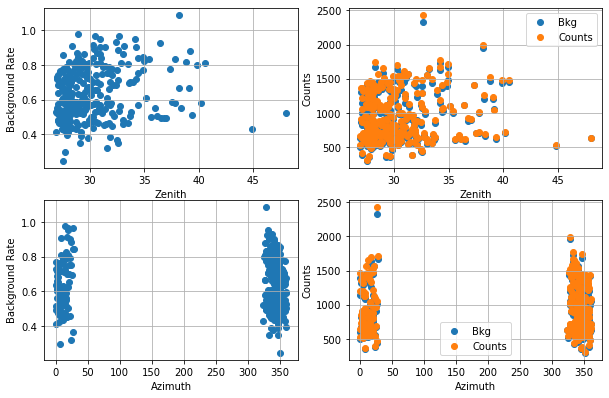

In [507]:
# Full Observations


a = list_of_datasets.info_table(cumulative=False)



zen_col = list(obs_table["ZEN_PNT"])
az_col = list(obs_table["AZ_PNT"])


from astropy.table import Column

zen_col = Column(data=zen_col, name="Zenith")
az_col = Column(data=az_col, name="Azimuth")
from astropy.table import hstack
a = hstack([a, zen_col, az_col])
a

excess_rate = []
count_rate = []
bkg_rate = []
ontime = []
for i in range(len(list(a["counts"]))):
    count = list(a["counts"])[i]
    bkg_count = list(a["background"])[i]
    exc_count = list(a['excess'])[i]
    on_time = list(a["ontime"])[i]
    excess_rate.append(exc_count/on_time)
    count_rate.append(count/on_time)
    bkg_rate.append(bkg_count/on_time)
    ontime.append(on_time/3600)
a["counts_rate"] = count_rate * 1/u.s
a["excess_rate"] = excess_rate * 1/u.s
a["background_rate"] = bkg_rate* 1/u.s
a["ontime"] = ontime*u.hr



fig = plt.figure(figsize = (10, 10))
# Background Rate vs Zenith
plt.subplot(3, 2, 1)
plt.scatter(list(a["Zenith"]), list(a["background_rate"]), label="background_rate vs Zenith")
plt.xlabel("Zenith")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 2)
plt.scatter(list(a["Zenith"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Zenith"]), list(a["counts"]), label="Counts")
plt.xlabel("Zenith")
plt.ylabel("Counts")
plt.legend()
plt.grid()

# Background Rate vs Azimuth
plt.subplot(3, 2, 3)
plt.scatter(list(a["Azimuth"]), list(a["background_rate"]), label="background_rate vs Azimuth")
plt.xlabel("Azimuth")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 4)
plt.scatter(list(a["Azimuth"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Azimuth"]), list(a["counts"]), label="Counts")
plt.xlabel("Azimuth")
plt.ylabel("Counts")
plt.legend()
plt.grid()


#a["counts","background","excess", "sqrt_ts", "ontime", "counts_rate", 'background_rate',"excess_rate"]

### Spectrum_After_Ring:

In [13]:
list_spec_ring = Datasets()
stacked_spec_ring = SpectrumDatasetOnOff.create(region=on_region, e_reco=energy_axis, e_true=energy_axis_true)
count = 1
spec_on_region = CircleSkyRegion(center=target_position, radius=0.089 * u.deg)
for dataset in list_map_ring:
    dataset = dataset.to_spectrum_dataset(on_region=spec_on_region,containment_correction=True, name=dataset.name)
    #dataset = safe_mask_maker.run(dataset, obs)
    #dataset = bkg_maker.run(dataset, obs)
    print(count, dataset)
    list_spec_ring.append(dataset)
    stacked_spec_ring.stack(dataset)
    count+=1

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

1 SpectrumDatasetOnOff
--------------------

  Name                            : 43930 

  Total counts                    : 6 
  Total off counts                : 9786.00
  Total background counts         : 3.56
  Total excess counts             : 2.44

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.08e+00 m2 s
  Exposure max                    : 1.29e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.812

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.26

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

2 SpectrumDatasetOnOff
--------------------

  Name                            : 43931 

  Total counts                    : 4 
  Total off counts                : 8428.00
  Total background counts         : 3.08
  Total excess counts             : 0.92

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.14e+01 m2 s
  Exposure max                    : 1.15e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.500

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.79

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

3 SpectrumDatasetOnOff
--------------------

  Name                            : 43932 

  Total counts                    : 3 
  Total off counts                : 8854.00
  Total background counts         : 3.27
  Total excess counts             : -0.27

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.39e+01 m2 s
  Exposure max                    : 1.12e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.636

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.53

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


4 SpectrumDatasetOnOff
--------------------

  Name                            : 44017 

  Total counts                    : 1 
  Total off counts       

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

5 SpectrumDatasetOnOff
--------------------

  Name                            : 44032 

  Total counts                    : 2 
  Total off counts                : 7792.00
  Total background counts         : 2.77
  Total excess counts             : -0.77

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.38e+02 m2 s
  Exposure max                    : 1.12e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.176

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.12

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


6 SpectrumDatasetOnOff
--------------------

  Name                            : 44033 

  Total counts                    : 2 
  Total off counts       

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

7 SpectrumDatasetOnOff
--------------------

  Name                            : 44034 

  Total counts                    : 8 
  Total off counts                : 10471.00
  Total background counts         : 3.80
  Total excess counts             : 4.20

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.21e+01 m2 s
  Exposure max                    : 1.21e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 122.025

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10.09

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

8 SpectrumDatasetOnOff
--------------------

  Name                            : 44059 

  Total counts                    : 4 
  Total off counts                : 9679.00
  Total background counts         : 3.49
  Total excess counts             : 0.51

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.99e+00 m2 s
  Exposure max                    : 1.34e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.397

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.61

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

9 SpectrumDatasetOnOff
--------------------

  Name                            : 44060 

  Total counts                    : 2 
  Total off counts                : 9025.00
  Total background counts         : 3.21
  Total excess counts             : -1.21

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 9.37e-01 m2 s
  Exposure max                    : 1.52e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.591

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.72

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

10 SpectrumDatasetOnOff
--------------------

  Name                            : 44325 

  Total counts                    : 9 
  Total off counts                : 7281.00
  Total background counts         : 2.57
  Total excess counts             : 6.43

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.72e+02 m2 s
  Exposure max                    : 1.07e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.279

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 17.58

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

11 SpectrumDatasetOnOff
--------------------

  Name                            : 44363 

  Total counts                    : 3 
  Total off counts                : 9875.00
  Total background counts         : 3.61
  Total excess counts             : -0.61

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 9.37e+01 m2 s
  Exposure max                    : 1.24e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 122.071

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.16

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

12 SpectrumDatasetOnOff
--------------------

  Name                            : 44364 

  Total counts                    : 11 
  Total off counts                : 8092.00
  Total background counts         : 2.87
  Total excess counts             : 8.13

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.88e+02 m2 s
  Exposure max                    : 1.13e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.138

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 22.28

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

13 SpectrumDatasetOnOff
--------------------

  Name                            : 44365 

  Total counts                    : 2 
  Total off counts                : 6945.00
  Total background counts         : 2.49
  Total excess counts             : -0.49

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.82e+02 m2 s
  Exposure max                    : 1.10e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.079

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.83

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

14 SpectrumDatasetOnOff
--------------------

  Name                            : 44366 

  Total counts                    : 1 
  Total off counts                : 6331.00
  Total background counts         : 2.24
  Total excess counts             : -1.24

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.06e+03 m2 s
  Exposure max                    : 1.07e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.514

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.53

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


15 SpectrumDatasetOnOff
--------------------

  Name                            : 44367 

  Total counts                    : 3 
  Total off counts     

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

16 SpectrumDatasetOnOff
--------------------

  Name                            : 44368 

  Total counts                    : 2 
  Total off counts                : 6314.00
  Total background counts         : 2.26
  Total excess counts             : -0.26

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.08e+02 m2 s
  Exposure max                    : 1.00e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.170

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.56

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


17 SpectrumDatasetOnOff
--------------------

  Name                            : 44415 

  Total counts                    : 1 
  Total off counts     

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

19 SpectrumDatasetOnOff
--------------------

  Name                            : 44420 

  Total counts                    : 6 
  Total off counts                : 8587.00
  Total background counts         : 3.14
  Total excess counts             : 2.86

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.18e+01 m2 s
  Exposure max                    : 1.21e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.934

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8.40

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

20 SpectrumDatasetOnOff
--------------------

  Name                            : 44445 

  Total counts                    : 6 
  Total off counts                : 10803.00
  Total background counts         : 3.85
  Total excess counts             : 2.15

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.28e+02 m2 s
  Exposure max                    : 1.04e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.148

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.24

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

21 SpectrumDatasetOnOff
--------------------

  Name                            : 44446 

  Total counts                    : 5 
  Total off counts                : 10880.00
  Total background counts         : 3.86
  Total excess counts             : 1.14

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.44e+01 m2 s
  Exposure max                    : 1.08e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.226

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.15

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

22 SpectrumDatasetOnOff
--------------------

  Name                            : 44447 

  Total counts                    : 2 
  Total off counts                : 11394.00
  Total background counts         : 4.18
  Total excess counts             : -2.18

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.25e+00 m2 s
  Exposure max                    : 1.16e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.905

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.20

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

23 SpectrumDatasetOnOff
--------------------

  Name                            : 44448 

  Total counts                    : 6 
  Total off counts                : 10414.00
  Total background counts         : 3.77
  Total excess counts             : 2.23

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.95e+00 m2 s
  Exposure max                    : 1.29e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 122.094

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.18

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


24 SpectrumDatasetOnOff
--------------------

  Name                            : 44449 

  Total counts                    : 5 
  Total off counts     

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

25 SpectrumDatasetOnOff
--------------------

  Name                            : 44450 

  Total counts                    : 1 
  Total off counts                : 10554.00
  Total background counts         : 3.79
  Total excess counts             : -2.79

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.44e+00 m2 s
  Exposure max                    : 1.40e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.655

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8.59

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


26 SpectrumDatasetOnOff
--------------------

  Name                            : 44451 

  Total counts                    : 5 
  Total off counts    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

27 SpectrumDatasetOnOff
--------------------

  Name                            : 44521 

  Total counts                    : 3 
  Total off counts                : 7280.00
  Total background counts         : 2.65
  Total excess counts             : 0.35

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.54e+01 m2 s
  Exposure max                    : 1.14e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.983

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.88

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


28 SpectrumDatasetOnOff
--------------------

  Name                            : 44522 

  Total counts                    : 1 
  Total off counts      

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

30 SpectrumDatasetOnOff
--------------------

  Name                            : 44532 

  Total counts                    : 0 
  Total off counts                : 6332.00
  Total background counts         : 2.25
  Total excess counts             : -2.25

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.07e+02 m2 s
  Exposure max                    : 1.10e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.583

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.49

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

31 SpectrumDatasetOnOff
--------------------

  Name                            : 44533 

  Total counts                    : 3 
  Total off counts                : 6143.00
  Total background counts         : 2.18
  Total excess counts             : 0.82

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 8.21e+02 m2 s
  Exposure max                    : 1.09e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.619

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.51

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

32 SpectrumDatasetOnOff
--------------------

  Name                            : 44534 

  Total counts                    : 4 
  Total off counts                : 5934.00
  Total background counts         : 2.12
  Total excess counts             : 1.88

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.24e+03 m2 s
  Exposure max                    : 1.00e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.128

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.94

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

33 SpectrumDatasetOnOff
--------------------

  Name                            : 44535 

  Total counts                    : 3 
  Total off counts                : 6074.00
  Total background counts         : 2.17
  Total excess counts             : 0.83

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.45e+02 m2 s
  Exposure max                    : 1.00e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.173

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.19

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


34 SpectrumDatasetOnOff
--------------------

  Name                            : 44536 

  Total counts                    : 5 
  Total off counts      

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

35 SpectrumDatasetOnOff
--------------------

  Name                            : 44538 

  Total counts                    : 4 
  Total off counts                : 6757.00
  Total background counts         : 2.47
  Total excess counts             : 1.53

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.15e+02 m2 s
  Exposure max                    : 1.20e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.182

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.82

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

36 SpectrumDatasetOnOff
--------------------

  Name                            : 44543 

  Total counts                    : 2 
  Total off counts                : 5913.00
  Total background counts         : 2.11
  Total excess counts             : -0.11

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.17e+03 m2 s
  Exposure max                    : 1.02e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.320

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.41

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

37 SpectrumDatasetOnOff
--------------------

  Name                            : 44550 

  Total counts                    : 4 
  Total off counts                : 7121.00
  Total background counts         : 2.55
  Total excess counts             : 1.45

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.03e+02 m2 s
  Exposure max                    : 1.11e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.165

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13.53

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


38 SpectrumDatasetOnOff
--------------------

  Name                            : 44551 

  Total counts                    : 3 
  Total off counts     

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

41 SpectrumDatasetOnOff
--------------------

  Name                            : 44570 

  Total counts                    : 5 
  Total off counts                : 8130.00
  Total background counts         : 2.88
  Total excess counts             : 2.12

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.81e+02 m2 s
  Exposure max                    : 1.13e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.732

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13.07

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

42 SpectrumDatasetOnOff
--------------------

  Name                            : 44571 

  Total counts                    : 4 
  Total off counts                : 6569.00
  Total background counts         : 2.30
  Total excess counts             : 1.70

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.46e+02 m2 s
  Exposure max                    : 1.11e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.556

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12.69

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


43 SpectrumDatasetOnOff
--------------------

  Name                            : 44572 

  Total counts                    : 3 
  Total off counts     

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

44 SpectrumDatasetOnOff
--------------------

  Name                            : 44573 

  Total counts                    : 0 
  Total off counts                : 6985.00
  Total background counts         : 2.48
  Total excess counts             : -2.48

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.11e+02 m2 s
  Exposure max                    : 1.01e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.196

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.96

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


45 SpectrumDatasetOnOff
--------------------

  Name                            : 44574 

  Total counts                    : 2 
  Total off counts     

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

46 SpectrumDatasetOnOff
--------------------

  Name                            : 44575 

  Total counts                    : 3 
  Total off counts                : 6079.00
  Total background counts         : 2.16
  Total excess counts             : 0.84

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.19e+02 m2 s
  Exposure max                    : 1.10e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.321

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

47 SpectrumDatasetOnOff
--------------------

  Name                            : 44604 

  Total counts                    : 5 
  Total off counts                : 6372.00
  Total background counts         : 2.27
  Total excess counts             : 2.73

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 8.83e+02 m2 s
  Exposure max                    : 1.06e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.178

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.17

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

48 SpectrumDatasetOnOff
--------------------

  Name                            : 44605 

  Total counts                    : 2 
  Total off counts                : 6333.00
  Total background counts         : 2.26
  Total excess counts             : -0.26

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 9.76e+02 m2 s
  Exposure max                    : 1.05e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.145

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.01

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


49 SpectrumDatasetOnOff
--------------------

  Name                            : 44606 

  Total counts                    : 2 
  Total off counts     

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

50 SpectrumDatasetOnOff
--------------------

  Name                            : 44607 

  Total counts                    : 6 
  Total off counts                : 5485.00
  Total background counts         : 1.95
  Total excess counts             : 4.05

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.07e+02 m2 s
  Exposure max                    : 1.06e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.490

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13.78

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


51 SpectrumDatasetOnOff
--------------------

  Name                            : 44608 

  Total counts                    : 5 
  Total off counts     

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

56 SpectrumDatasetOnOff
--------------------

  Name                            : 44655 

  Total counts                    : 3 
  Total off counts                : 6555.00
  Total background counts         : 2.34
  Total excess counts             : 0.66

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.00e+03 m2 s
  Exposure max                    : 9.79e+07 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 109.357

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.42

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

57 SpectrumDatasetOnOff
--------------------

  Name                            : 44658 

  Total counts                    : 7 
  Total off counts                : 6023.00
  Total background counts         : 2.13
  Total excess counts             : 4.87

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.23e+02 m2 s
  Exposure max                    : 1.09e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.537

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11.89

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

58 SpectrumDatasetOnOff
--------------------

  Name                            : 44685 

  Total counts                    : 0 
  Total off counts                : 7722.00
  Total background counts         : 2.72
  Total excess counts             : -2.72

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.02e+03 m2 s
  Exposure max                    : 1.06e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.485

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.45

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

59 SpectrumDatasetOnOff
--------------------

  Name                            : 44686 

  Total counts                    : 3 
  Total off counts                : 6749.00
  Total background counts         : 2.39
  Total excess counts             : 0.61

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 9.99e+02 m2 s
  Exposure max                    : 1.06e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.610

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 1.86

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

60 SpectrumDatasetOnOff
--------------------

  Name                            : 44687 

  Total counts                    : 3 
  Total off counts                : 3862.00
  Total background counts         : 1.36
  Total excess counts             : 1.64

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.73e+02 m2 s
  Exposure max                    : 5.88e+07 m2 s

  Acceptance mean                 : 0.002
  Acceptance off                  : 69.817

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.73

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

61 SpectrumDatasetOnOff
--------------------

  Name                            : 44688 

  Total counts                    : 6 
  Total off counts                : 7578.00
  Total background counts         : 2.69
  Total excess counts             : 3.31

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.46e+02 m2 s
  Exposure max                    : 1.03e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.234

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.28

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

62 SpectrumDatasetOnOff
--------------------

  Name                            : 44692 

  Total counts                    : 2 
  Total off counts                : 7349.00
  Total background counts         : 2.69
  Total excess counts             : -0.69

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.56e+01 m2 s
  Exposure max                    : 9.97e+07 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.886

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.95

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


63 SpectrumDatasetOnOff
--------------------

  Name                            : 44719 

  Total counts                    : 3 
  Total off counts     

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

66 SpectrumDatasetOnOff
--------------------

  Name                            : 44776 

  Total counts                    : 4 
  Total off counts                : 7772.00
  Total background counts         : 2.75
  Total excess counts             : 1.25

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.20e+03 m2 s
  Exposure max                    : 1.06e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.514

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.65

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


67 SpectrumDatasetOnOff
--------------------

  Name                            : 44777 

  Total counts                    : 4 
  Total off counts      

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

68 SpectrumDatasetOnOff
--------------------

  Name                            : 44778 

  Total counts                    : 7 
  Total off counts                : 9559.00
  Total background counts         : 3.42
  Total excess counts             : 3.58

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.88e+02 m2 s
  Exposure max                    : 1.02e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.098

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.60

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


69 SpectrumDatasetOnOff
--------------------

  Name                            : 44779 

  Total counts                    : 1 
  Total off counts      

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

70 SpectrumDatasetOnOff
--------------------

  Name                            : 44781 

  Total counts                    : 2 
  Total off counts                : 9298.00
  Total background counts         : 3.40
  Total excess counts             : -1.40

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.79e+01 m2 s
  Exposure max                    : 1.20e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 122.015

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.87

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

71 SpectrumDatasetOnOff
--------------------

  Name                            : 44807 

  Total counts                    : 2 
  Total off counts                : 9228.00
  Total background counts         : 3.28
  Total excess counts             : -1.28

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 9.47e+02 m2 s
  Exposure max                    : 1.04e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.163

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.80

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

72 SpectrumDatasetOnOff
--------------------

  Name                            : 44808 

  Total counts                    : 8 
  Total off counts                : 9035.00
  Total background counts         : 3.21
  Total excess counts             : 4.79

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.57e+02 m2 s
  Exposure max                    : 1.09e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.129

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12.65

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


73 SpectrumDatasetOnOff
--------------------

  Name                            : 44809 

  Total counts                    : 5 
  Total off counts     

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

74 SpectrumDatasetOnOff
--------------------

  Name                            : 44810 

  Total counts                    : 4 
  Total off counts                : 8168.00
  Total background counts         : 2.88
  Total excess counts             : 1.12

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.24e+02 m2 s
  Exposure max                    : 1.19e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.554

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.63

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


75 SpectrumDatasetOnOff
--------------------

  Name                            : 44813 

  Total counts                    : 5 
  Total off counts      

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

76 SpectrumDatasetOnOff
--------------------

  Name                            : 48622 

  Total counts                    : 5 
  Total off counts                : 6816.00
  Total background counts         : 2.43
  Total excess counts             : 2.57

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 9.74e+03 m2 s
  Exposure max                    : 1.50e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.088

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15.80

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

77 SpectrumDatasetOnOff
--------------------

  Name                            : 48623 

  Total counts                    : 3 
  Total off counts                : 6968.00
  Total background counts         : 2.47
  Total excess counts             : 0.53

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.22e+03 m2 s
  Exposure max                    : 1.56e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.258

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10.33

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

78 SpectrumDatasetOnOff
--------------------

  Name                            : 48624 

  Total counts                    : 4 
  Total off counts                : 6574.00
  Total background counts         : 2.33
  Total excess counts             : 1.67

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.09e+03 m2 s
  Exposure max                    : 1.64e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.532

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.86

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

79 SpectrumDatasetOnOff
--------------------

  Name                            : 48625 

  Total counts                    : 2 
  Total off counts                : 4244.00
  Total background counts         : 1.51
  Total excess counts             : 0.49

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.24e+03 m2 s
  Exposure max                    : 8.57e+07 m2 s

  Acceptance mean                 : 0.001
  Acceptance off                  : 58.179

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.91

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

80 SpectrumDatasetOnOff
--------------------

  Name                            : 48938 

  Total counts                    : 2 
  Total off counts                : 8331.00
  Total background counts         : 3.08
  Total excess counts             : -1.08

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.12e+03 m2 s
  Exposure max                    : 1.59e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.485

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.65

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

81 SpectrumDatasetOnOff
--------------------

  Name                            : 48939 

  Total counts                    : 1 
  Total off counts                : 6396.00
  Total background counts         : 2.33
  Total excess counts             : -1.33

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.87e+02 m2 s
  Exposure max                    : 1.60e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.486

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.64

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

82 SpectrumDatasetOnOff
--------------------

  Name                            : 49286 

  Total counts                    : 7 
  Total off counts                : 9810.00
  Total background counts         : 3.47
  Total excess counts             : 3.53

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.35e+02 m2 s
  Exposure max                    : 1.53e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.546

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.90

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

83 SpectrumDatasetOnOff
--------------------

  Name                            : 49311 

  Total counts                    : 2 
  Total off counts                : 11051.00
  Total background counts         : 4.05
  Total excess counts             : -2.05

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.52e+01 m2 s
  Exposure max                    : 1.63e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.800

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.96

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

84 SpectrumDatasetOnOff
--------------------

  Name                            : 50092 

  Total counts                    : 6 
  Total off counts                : 6371.00
  Total background counts         : 2.26
  Total excess counts             : 3.74

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.83e+03 m2 s
  Exposure max                    : 1.04e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.801

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.63

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


85 SpectrumDatasetOnOff
--------------------

  Name                            : 50093 

  Total counts                    : 1 
  Total off counts      

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

86 SpectrumDatasetOnOff
--------------------

  Name                            : 50122 

  Total counts                    : 2 
  Total off counts                : 4276.00
  Total background counts         : 1.57
  Total excess counts             : 0.43

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.14e+03 m2 s
  Exposure max                    : 1.70e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.592

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.12

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

87 SpectrumDatasetOnOff
--------------------

  Name                            : 50145 

  Total counts                    : 2 
  Total off counts                : 5489.00
  Total background counts         : 1.94
  Total excess counts             : 0.06

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.60e+03 m2 s
  Exposure max                    : 1.56e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.200

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.40

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

88 SpectrumDatasetOnOff
--------------------

  Name                            : 50146 

  Total counts                    : 0 
  Total off counts                : 5401.00
  Total background counts         : 1.91
  Total excess counts             : -1.91

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.03e+03 m2 s
  Exposure max                    : 1.64e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.262

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.82

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


89 SpectrumDatasetOnOff
--------------------

  Name                            : 50147 

  Total counts                    : 6 
  Total off counts     

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

90 SpectrumDatasetOnOff
--------------------

  Name                            : 50227 

  Total counts                    : 4 
  Total off counts                : 5786.00
  Total background counts         : 2.06
  Total excess counts             : 1.94

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.40e+03 m2 s
  Exposure max                    : 1.72e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 115.598

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.55

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

91 SpectrumDatasetOnOff
--------------------

  Name                            : 50228 

  Total counts                    : 2 
  Total off counts                : 6400.00
  Total background counts         : 2.37
  Total excess counts             : -0.37

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.03e+03 m2 s
  Exposure max                    : 1.61e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.532

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.63

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

92 SpectrumDatasetOnOff
--------------------

  Name                            : 50314 

  Total counts                    : 3 
  Total off counts                : 7506.00
  Total background counts         : 2.74
  Total excess counts             : 0.26

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.98e+03 m2 s
  Exposure max                    : 1.70e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.584

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.38

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

93 SpectrumDatasetOnOff
--------------------

  Name                            : 50348 

  Total counts                    : 6 
  Total off counts                : 7038.00
  Total background counts         : 2.58
  Total excess counts             : 3.42

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.45e+03 m2 s
  Exposure max                    : 1.66e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 122.002

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8.94

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

94 SpectrumDatasetOnOff
--------------------

  Name                            : 50349 

  Total counts                    : 1 
  Total off counts                : 6272.00
  Total background counts         : 2.29
  Total excess counts             : -1.29

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 8.80e+02 m2 s
  Exposure max                    : 1.60e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.344

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.36

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

95 SpectrumDatasetOnOff
--------------------

  Name                            : 50380 

  Total counts                    : 2 
  Total off counts                : 5072.00
  Total background counts         : 1.85
  Total excess counts             : 0.15

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.24e+02 m2 s
  Exposure max                    : 1.64e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.527

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.06

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

96 SpectrumDatasetOnOff
--------------------

  Name                            : 50489 

  Total counts                    : 3 
  Total off counts                : 7402.00
  Total background counts         : 2.68
  Total excess counts             : 0.32

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.26e+01 m2 s
  Exposure max                    : 1.80e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.963

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.59

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

97 SpectrumDatasetOnOff
--------------------

  Name                            : 50532 

  Total counts                    : 1 
  Total off counts                : 7409.00
  Total background counts         : 2.70
  Total excess counts             : -1.70

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.86e+00 m2 s
  Exposure max                    : 1.89e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.897

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11.30

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

98 SpectrumDatasetOnOff
--------------------

  Name                            : 50563 

  Total counts                    : 2 
  Total off counts                : 5858.00
  Total background counts         : 2.09
  Total excess counts             : -0.09

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.44e+00 m2 s
  Exposure max                    : 2.06e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 122.040

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.39

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

99 SpectrumDatasetOnOff
--------------------

  Name                            : 50748 

  Total counts                    : 6 
  Total off counts                : 6947.00
  Total background counts         : 2.51
  Total excess counts             : 3.49

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.12e+01 m2 s
  Exposure max                    : 1.82e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.981

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.60

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

100 SpectrumDatasetOnOff
--------------------

  Name                            : 50778 

  Total counts                    : 6 
  Total off counts                : 5699.00
  Total background counts         : 2.07
  Total excess counts             : 3.93

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.39e+00 m2 s
  Exposure max                    : 1.80e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.443

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 30.24

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

101 SpectrumDatasetOnOff
--------------------

  Name                            : 50804 

  Total counts                    : 2 
  Total off counts                : 6535.00
  Total background counts         : 2.39
  Total excess counts             : -0.39

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.45e+00 m2 s
  Exposure max                    : 1.79e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.588

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.80

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

102 SpectrumDatasetOnOff
--------------------

  Name                            : 50831 

  Total counts                    : 2 
  Total off counts                : 6668.00
  Total background counts         : 2.38
  Total excess counts             : -0.38

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.94e+00 m2 s
  Exposure max                    : 1.85e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.906

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.93

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

103 SpectrumDatasetOnOff
--------------------

  Name                            : 50832 

  Total counts                    : 4 
  Total off counts                : 7082.00
  Total background counts         : 2.63
  Total excess counts             : 1.37

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.88e-03 m2 s
  Exposure max                    : 1.95e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 136.397

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8.10

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

104 SpectrumDatasetOnOff
--------------------

  Name                            : 50912 

  Total counts                    : 3 
  Total off counts                : 6401.00
  Total background counts         : 2.33
  Total excess counts             : 0.67

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 9.99e+01 m2 s
  Exposure max                    : 1.71e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.367

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.77

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


105 SpectrumDatasetOnOff
--------------------

  Name                            : 50996 

  Total counts                    : 2 
  Total off counts    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

106 SpectrumDatasetOnOff
--------------------

  Name                            : 52984 

  Total counts                    : 9 
  Total off counts                : 8596.00
  Total background counts         : 3.06
  Total excess counts             : 5.94

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.93e+02 m2 s
  Exposure max                    : 1.61e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.498

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15.46

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

107 SpectrumDatasetOnOff
--------------------

  Name                            : 52985 

  Total counts                    : 6 
  Total off counts                : 9893.00
  Total background counts         : 3.50
  Total excess counts             : 2.50

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.82e+02 m2 s
  Exposure max                    : 1.54e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.081

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.13

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

108 SpectrumDatasetOnOff
--------------------

  Name                            : 53175 

  Total counts                    : 2 
  Total off counts                : 7412.00
  Total background counts         : 2.65
  Total excess counts             : -0.65

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.75e+02 m2 s
  Exposure max                    : 1.55e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.107

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10.71

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


109 SpectrumDatasetOnOff
--------------------

  Name                            : 53176 

  Total counts                    : 3 
  Total off counts  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

110 SpectrumDatasetOnOff
--------------------

  Name                            : 53177 

  Total counts                    : 4 
  Total off counts                : 7876.00
  Total background counts         : 2.80
  Total excess counts             : 1.20

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.73e+02 m2 s
  Exposure max                    : 1.74e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.593

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.84

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

111 SpectrumDatasetOnOff
--------------------

  Name                            : 53272 

  Total counts                    : 5 
  Total off counts                : 9669.00
  Total background counts         : 3.43
  Total excess counts             : 1.57

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.22e+02 m2 s
  Exposure max                    : 2.05e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 145.149

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.19

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


112 SpectrumDatasetOnOff
--------------------

  Name                            : 53273 

  Total counts                    : 3 
  Total off counts    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

113 SpectrumDatasetOnOff
--------------------

  Name                            : 53339 

  Total counts                    : 2 
  Total off counts                : 6551.00
  Total background counts         : 2.33
  Total excess counts             : -0.33

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.48e+02 m2 s
  Exposure max                    : 9.70e+07 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.115

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.82

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

114 SpectrumDatasetOnOff
--------------------

  Name                            : 53459 

  Total counts                    : 2 
  Total off counts                : 4667.00
  Total background counts         : 1.66
  Total excess counts             : 0.34

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.98e+03 m2 s
  Exposure max                    : 1.58e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.204

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.76

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

115 SpectrumDatasetOnOff
--------------------

  Name                            : 53460 

  Total counts                    : 6 
  Total off counts                : 8374.00
  Total background counts         : 2.97
  Total excess counts             : 3.03

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.05e+03 m2 s
  Exposure max                    : 1.61e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.510

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.19

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

116 SpectrumDatasetOnOff
--------------------

  Name                            : 53587 

  Total counts                    : 6 
  Total off counts                : 7785.00
  Total background counts         : 2.76
  Total excess counts             : 3.24

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.55e+03 m2 s
  Exposure max                    : 1.61e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.569

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14.31

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

117 SpectrumDatasetOnOff
--------------------

  Name                            : 53776 

  Total counts                    : 1 
  Total off counts                : 7723.00
  Total background counts         : 2.74
  Total excess counts             : -1.74

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.93e+03 m2 s
  Exposure max                    : 1.70e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.574

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.47

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

118 SpectrumDatasetOnOff
--------------------

  Name                            : 53778 

  Total counts                    : 4 
  Total off counts                : 6794.00
  Total background counts         : 2.42
  Total excess counts             : 1.58

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 8.09e+03 m2 s
  Exposure max                    : 1.54e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 115.979

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.31

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

119 SpectrumDatasetOnOff
--------------------

  Name                            : 53779 

  Total counts                    : 5 
  Total off counts                : 7694.00
  Total background counts         : 2.74
  Total excess counts             : 2.26

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.39e+03 m2 s
  Exposure max                    : 1.55e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.067

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.66

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

120 SpectrumDatasetOnOff
--------------------

  Name                            : 53867 

  Total counts                    : 2 
  Total off counts                : 6883.00
  Total background counts         : 2.43
  Total excess counts             : -0.43

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.48e+03 m2 s
  Exposure max                    : 1.64e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.330

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.85

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

121 SpectrumDatasetOnOff
--------------------

  Name                            : 53868 

  Total counts                    : 7 
  Total off counts                : 7140.00
  Total background counts         : 2.54
  Total excess counts             : 4.46

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.38e+03 m2 s
  Exposure max                    : 1.73e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.564

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 17.04

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

122 SpectrumDatasetOnOff
--------------------

  Name                            : 54011 

  Total counts                    : 2 
  Total off counts                : 7491.00
  Total background counts         : 2.65
  Total excess counts             : -0.65

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.50e+03 m2 s
  Exposure max                    : 1.70e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.559

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.01

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

123 SpectrumDatasetOnOff
--------------------

  Name                            : 54012 

  Total counts                    : 1 
  Total off counts                : 7641.00
  Total background counts         : 2.72
  Total excess counts             : -1.72

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.67e+03 m2 s
  Exposure max                    : 1.67e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.504

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.91

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

124 SpectrumDatasetOnOff
--------------------

  Name                            : 54060 

  Total counts                    : 2 
  Total off counts                : 4376.00
  Total background counts         : 1.56
  Total excess counts             : 0.44

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.01e+04 m2 s
  Exposure max                    : 1.51e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 115.978

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8.68

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

125 SpectrumDatasetOnOff
--------------------

  Name                            : 54130 

  Total counts                    : 1 
  Total off counts                : 6109.00
  Total background counts         : 2.17
  Total excess counts             : -1.17

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.90e+03 m2 s
  Exposure max                    : 1.56e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.195

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.86

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

126 SpectrumDatasetOnOff
--------------------

  Name                            : 54131 

  Total counts                    : 6 
  Total off counts                : 6384.00
  Total background counts         : 2.26
  Total excess counts             : 3.74

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.27e+03 m2 s
  Exposure max                    : 1.65e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.422

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11.06

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

127 SpectrumDatasetOnOff
--------------------

  Name                            : 54293 

  Total counts                    : 1 
  Total off counts                : 6636.00
  Total background counts         : 2.35
  Total excess counts             : -1.35

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.45e+03 m2 s
  Exposure max                    : 1.74e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.414

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.55

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

128 SpectrumDatasetOnOff
--------------------

  Name                            : 54294 

  Total counts                    : 1 
  Total off counts                : 6364.00
  Total background counts         : 2.34
  Total excess counts             : -1.34

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.85e+03 m2 s
  Exposure max                    : 1.68e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.091

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.64

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

129 SpectrumDatasetOnOff
--------------------

  Name                            : 54351 

  Total counts                    : 2 
  Total off counts                : 7854.00
  Total background counts         : 2.81
  Total excess counts             : -0.81

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.30e+03 m2 s
  Exposure max                    : 1.59e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.133

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.63

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

130 SpectrumDatasetOnOff
--------------------

  Name                            : 54352 

  Total counts                    : 6 
  Total off counts                : 7729.00
  Total background counts         : 2.74
  Total excess counts             : 3.26

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.23e+03 m2 s
  Exposure max                    : 1.71e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.373

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.18

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

131 SpectrumDatasetOnOff
--------------------

  Name                            : 54408 

  Total counts                    : 4 
  Total off counts                : 7223.00
  Total background counts         : 2.65
  Total excess counts             : 1.35

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 9.76e+02 m2 s
  Exposure max                    : 1.64e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.919

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.58

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


132 SpectrumDatasetOnOff
--------------------

  Name                            : 54539 

  Total counts                    : 6 
  Total off counts    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

133 SpectrumDatasetOnOff
--------------------

  Name                            : 54541 

  Total counts                    : 9 
  Total off counts                : 5511.00
  Total background counts         : 1.96
  Total excess counts             : 7.04

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 8.31e+03 m2 s
  Exposure max                    : 1.55e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.008

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 30.19

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


134 SpectrumDatasetOnOff
--------------------

  Name                            : 54542 

  Total counts                    : 3 
  Total off counts   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

135 SpectrumDatasetOnOff
--------------------

  Name                            : 54563 

  Total counts                    : 4 
  Total off counts                : 7743.00
  Total background counts         : 2.82
  Total excess counts             : 1.18

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.65e+03 m2 s
  Exposure max                    : 1.71e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.825

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8.31

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

136 SpectrumDatasetOnOff
--------------------

  Name                            : 54747 

  Total counts                    : 3 
  Total off counts                : 6043.00
  Total background counts         : 2.14
  Total excess counts             : 0.86

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.21e+03 m2 s
  Exposure max                    : 1.61e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.396

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.53

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

137 SpectrumDatasetOnOff
--------------------

  Name                            : 54748 

  Total counts                    : 2 
  Total off counts                : 3224.00
  Total background counts         : 1.14
  Total excess counts             : 0.86

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.01e+03 m2 s
  Exposure max                    : 1.27e+08 m2 s

  Acceptance mean                 : 0.002
  Acceptance off                  : 87.184

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10.82

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

138 SpectrumDatasetOnOff
--------------------

  Name                            : 54818 

  Total counts                    : 3 
  Total off counts                : 11320.00
  Total background counts         : 4.17
  Total excess counts             : -1.17

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.04e+03 m2 s
  Exposure max                    : 2.92e+08 m2 s

  Acceptance mean                 : 0.005
  Acceptance off                  : 211.977

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

139 SpectrumDatasetOnOff
--------------------

  Name                            : 54898 

  Total counts                    : 2 
  Total off counts                : 4478.00
  Total background counts         : 1.63
  Total excess counts             : 0.37

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.73e-06 m2 s
  Exposure max                    : 2.25e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 130.990

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.37

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

140 SpectrumDatasetOnOff
--------------------

  Name                            : 54899 

  Total counts                    : 4 
  Total off counts                : 5305.00
  Total background counts         : 1.88
  Total excess counts             : 2.12

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.62e-01 m2 s
  Exposure max                    : 2.64e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 131.428

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.33

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


141 SpectrumDatasetOnOff
--------------------

  Name                            : 55248 

  Total counts                    : 0 
  Total off counts    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

143 SpectrumDatasetOnOff
--------------------

  Name                            : 55365 

  Total counts                    : 5 
  Total off counts                : 6545.00
  Total background counts         : 2.33
  Total excess counts             : 2.67

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.11e+04 m2 s
  Exposure max                    : 1.96e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 145.045

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.21

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

144 SpectrumDatasetOnOff
--------------------

  Name                            : 55698 

  Total counts                    : 1 
  Total off counts                : 6912.00
  Total background counts         : 2.53
  Total excess counts             : -1.53

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 9.40e+02 m2 s
  Exposure max                    : 1.69e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 122.066

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.20

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

145 SpectrumDatasetOnOff
--------------------

  Name                            : 55699 

  Total counts                    : 6 
  Total off counts                : 7794.00
  Total background counts         : 2.85
  Total excess counts             : 3.15

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.93e+02 m2 s
  Exposure max                    : 1.63e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.429

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13.28

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

146 SpectrumDatasetOnOff
--------------------

  Name                            : 55770 

  Total counts                    : 3 
  Total off counts                : 8186.00
  Total background counts         : 3.05
  Total excess counts             : -0.05

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 8.81e+02 m2 s
  Exposure max                    : 1.64e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.448

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.27

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

147 SpectrumDatasetOnOff
--------------------

  Name                            : 55771 

  Total counts                    : 3 
  Total off counts                : 6510.00
  Total background counts         : 2.38
  Total excess counts             : 0.62

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.71e+02 m2 s
  Exposure max                    : 1.67e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.917

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10.20

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


148 SpectrumDatasetOnOff
--------------------

  Name                            : 58898 

  Total counts                    : 0 
  Total off counts   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

149 SpectrumDatasetOnOff
--------------------

  Name                            : 58899 

  Total counts                    : 1 
  Total off counts                : 3527.00
  Total background counts         : 1.27
  Total excess counts             : -0.27

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 8.63e+03 m2 s
  Exposure max                    : 1.56e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.094

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 1.35

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

150 SpectrumDatasetOnOff
--------------------

  Name                            : 58971 

  Total counts                    : 2 
  Total off counts                : 7990.00
  Total background counts         : 2.84
  Total excess counts             : -0.84

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.38e+03 m2 s
  Exposure max                    : 1.62e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.120

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.73

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

151 SpectrumDatasetOnOff
--------------------

  Name                            : 58974 

  Total counts                    : 3 
  Total off counts                : 7054.00
  Total background counts         : 2.55
  Total excess counts             : 0.45

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.20e+02 m2 s
  Exposure max                    : 1.70e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.826

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.24

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

152 SpectrumDatasetOnOff
--------------------

  Name                            : 59065 

  Total counts                    : 4 
  Total off counts                : 5959.00
  Total background counts         : 2.11
  Total excess counts             : 1.89

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.29e+03 m2 s
  Exposure max                    : 1.63e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.523

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11.35

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

153 SpectrumDatasetOnOff
--------------------

  Name                            : 59066 

  Total counts                    : 4 
  Total off counts                : 5982.00
  Total background counts         : 2.12
  Total excess counts             : 1.88

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.89e+03 m2 s
  Exposure max                    : 1.58e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.099

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.49

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

154 SpectrumDatasetOnOff
--------------------

  Name                            : 59269 

  Total counts                    : 2 
  Total off counts                : 4445.00
  Total background counts         : 1.64
  Total excess counts             : 0.36

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.72e+02 m2 s
  Exposure max                    : 1.66e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.411

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 1.84

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

155 SpectrumDatasetOnOff
--------------------

  Name                            : 59344 

  Total counts                    : 5 
  Total off counts                : 5760.00
  Total background counts         : 2.13
  Total excess counts             : 2.87

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.08e+03 m2 s
  Exposure max                    : 1.68e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.306

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10.93

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

156 SpectrumDatasetOnOff
--------------------

  Name                            : 59345 

  Total counts                    : 4 
  Total off counts                : 5940.00
  Total background counts         : 2.10
  Total excess counts             : 1.90

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.56e+03 m2 s
  Exposure max                    : 1.69e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.468

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11.70

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

157 SpectrumDatasetOnOff
--------------------

  Name                            : 59455 

  Total counts                    : 5 
  Total off counts                : 8531.00
  Total background counts         : 3.12
  Total excess counts             : 1.88

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 9.98e+02 m2 s
  Exposure max                    : 1.65e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.765

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8.01

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

158 SpectrumDatasetOnOff
--------------------

  Name                            : 59456 

  Total counts                    : 7 
  Total off counts                : 5407.00
  Total background counts         : 1.97
  Total excess counts             : 5.03

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.52e+02 m2 s
  Exposure max                    : 1.66e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.350

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16.46

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


159 SpectrumDatasetOnOff
--------------------

  Name                            : 59569 

  Total counts                    : 3 
  Total off counts   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

160 SpectrumDatasetOnOff
--------------------

  Name                            : 59570 

  Total counts                    : 4 
  Total off counts                : 7339.00
  Total background counts         : 2.69
  Total excess counts             : 1.31

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.05e+03 m2 s
  Exposure max                    : 1.74e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.790

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.14

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

161 SpectrumDatasetOnOff
--------------------

  Name                            : 59808 

  Total counts                    : 2 
  Total off counts                : 2711.00
  Total background counts         : 1.00
  Total excess counts             : 1.00

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.30e+02 m2 s
  Exposure max                    : 1.53e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.323

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.45

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

162 SpectrumDatasetOnOff
--------------------

  Name                            : 59809 

  Total counts                    : 3 
  Total off counts                : 5899.00
  Total background counts         : 2.18
  Total excess counts             : 0.82

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.12e+03 m2 s
  Exposure max                    : 1.61e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.500

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13.51

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


163 SpectrumDatasetOnOff
--------------------

  Name                            : 59810 

  Total counts                    : 2 
  Total off counts   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

164 SpectrumDatasetOnOff
--------------------

  Name                            : 59896 

  Total counts                    : 5 
  Total off counts                : 7285.00
  Total background counts         : 2.58
  Total excess counts             : 2.42

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.55e+03 m2 s
  Exposure max                    : 1.70e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.539

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8.52

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

165 SpectrumDatasetOnOff
--------------------

  Name                            : 59898 

  Total counts                    : 3 
  Total off counts                : 6840.00
  Total background counts         : 2.52
  Total excess counts             : 0.48

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.70e+03 m2 s
  Exposure max                    : 1.67e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.279

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.46

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

166 SpectrumDatasetOnOff
--------------------

  Name                            : 59981 

  Total counts                    : 4 
  Total off counts                : 5509.00
  Total background counts         : 2.02
  Total excess counts             : 1.98

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.15e+03 m2 s
  Exposure max                    : 1.69e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.637

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.45

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

167 SpectrumDatasetOnOff
--------------------

  Name                            : 59982 

  Total counts                    : 4 
  Total off counts                : 5558.00
  Total background counts         : 2.03
  Total excess counts             : 1.97

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 8.60e+02 m2 s
  Exposure max                    : 1.62e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.909

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.03

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


168 SpectrumDatasetOnOff
--------------------

  Name                            : 60057 

  Total counts                    : 2 
  Total off counts    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

169 SpectrumDatasetOnOff
--------------------

  Name                            : 60058 

  Total counts                    : 3 
  Total off counts                : 5897.00
  Total background counts         : 2.17
  Total excess counts             : 0.83

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.24e+03 m2 s
  Exposure max                    : 1.62e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.607

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.48

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

170 SpectrumDatasetOnOff
--------------------

  Name                            : 60162 

  Total counts                    : 3 
  Total off counts                : 6479.00
  Total background counts         : 2.36
  Total excess counts             : 0.64

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.88e+03 m2 s
  Exposure max                    : 1.70e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.884

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8.86

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

171 SpectrumDatasetOnOff
--------------------

  Name                            : 60163 

  Total counts                    : 1 
  Total off counts                : 7261.00
  Total background counts         : 2.65
  Total excess counts             : -1.65

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.88e+02 m2 s
  Exposure max                    : 1.64e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.837

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.08

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

172 SpectrumDatasetOnOff
--------------------

  Name                            : 60341 

  Total counts                    : 2 
  Total off counts                : 5041.00
  Total background counts         : 1.78
  Total excess counts             : 0.22

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.29e+03 m2 s
  Exposure max                    : 1.66e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 115.990

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.38

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

173 SpectrumDatasetOnOff
--------------------

  Name                            : 60342 

  Total counts                    : 4 
  Total off counts                : 5860.00
  Total background counts         : 2.08
  Total excess counts             : 1.92

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.87e+03 m2 s
  Exposure max                    : 1.62e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 115.801

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 17976931348623157081452742373170435679807056752584499659891747680315726078002853876058955863276687817154045895351438246423432132688946418276846754670353751698604991057655128207624549009038932894407586850845513394230458323690322294816580855933212334827479782620414472316873817

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

175 SpectrumDatasetOnOff
--------------------

  Name                            : 60344 

  Total counts                    : 0 
  Total off counts                : 5358.00
  Total background counts         : 1.89
  Total excess counts             : -1.89

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 8.00e+03 m2 s
  Exposure max                    : 1.60e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.583

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.78

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

176 SpectrumDatasetOnOff
--------------------

  Name                            : 60489 

  Total counts                    : 2 
  Total off counts                : 3457.00
  Total background counts         : 1.26
  Total excess counts             : 0.74

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.56e+02 m2 s
  Exposure max                    : 1.58e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.247

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.24

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

177 SpectrumDatasetOnOff
--------------------

  Name                            : 64112 

  Total counts                    : 11 
  Total off counts                : 11520.00
  Total background counts         : 4.22
  Total excess counts             : 6.78

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.98e+03 m2 s
  Exposure max                    : 2.61e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.769

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13.47

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

178 SpectrumDatasetOnOff
--------------------

  Name                            : 64113 

  Total counts                    : 3 
  Total off counts                : 10919.00
  Total background counts         : 3.90
  Total excess counts             : -0.90

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.08e+03 m2 s
  Exposure max                    : 2.03e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.089

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8.10

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

179 SpectrumDatasetOnOff
--------------------

  Name                            : 64266 

  Total counts                    : 2 
  Total off counts                : 5748.00
  Total background counts         : 2.04
  Total excess counts             : -0.04

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 9.20e+03 m2 s
  Exposure max                    : 1.52e+08 m2 s

  Acceptance mean                 : 0.002
  Acceptance off                  : 86.106

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.11

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

180 SpectrumDatasetOnOff
--------------------

  Name                            : 64364 

  Total counts                    : 7 
  Total off counts                : 10744.00
  Total background counts         : 3.80
  Total excess counts             : 3.20

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 8.38e+03 m2 s
  Exposure max                    : 2.04e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.485

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10.79

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

181 SpectrumDatasetOnOff
--------------------

  Name                            : 64365 

  Total counts                    : 8 
  Total off counts                : 7818.00
  Total background counts         : 2.79
  Total excess counts             : 5.21

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 9.78e+03 m2 s
  Exposure max                    : 1.88e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.009

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11.81

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

182 SpectrumDatasetOnOff
--------------------

  Name                            : 64440 

  Total counts                    : 8 
  Total off counts                : 15503.00
  Total background counts         : 5.72
  Total excess counts             : 2.28

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.26e+03 m2 s
  Exposure max                    : 2.88e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 151.769

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.36

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

183 SpectrumDatasetOnOff
--------------------

  Name                            : 64441 

  Total counts                    : 6 
  Total off counts                : 8333.00
  Total background counts         : 2.97
  Total excess counts             : 3.03

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.70e+03 m2 s
  Exposure max                    : 1.56e+08 m2 s

  Acceptance mean                 : 0.002
  Acceptance off                  : 87.311

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.48

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

184 SpectrumDatasetOnOff
--------------------

  Name                            : 64717 

  Total counts                    : 2 
  Total off counts                : 6882.00
  Total background counts         : 2.52
  Total excess counts             : -0.52

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.52e+03 m2 s
  Exposure max                    : 1.62e+08 m2 s

  Acceptance mean                 : 0.002
  Acceptance off                  : 84.004

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.76

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

185 SpectrumDatasetOnOff
--------------------

  Name                            : 64788 

  Total counts                    : 12 
  Total off counts                : 24408.00
  Total background counts         : 8.93
  Total excess counts             : 3.07

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 8.25e+03 m2 s
  Exposure max                    : 6.44e+08 m2 s

  Acceptance mean                 : 0.006
  Acceptance off                  : 242.957

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.73

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

186 SpectrumDatasetOnOff
--------------------

  Name                            : 64826 

  Total counts                    : 7 
  Total off counts                : 14437.00
  Total background counts         : 5.33
  Total excess counts             : 1.67

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.58e+03 m2 s
  Exposure max                    : 3.33e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.893

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 27.75

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

187 SpectrumDatasetOnOff
--------------------

  Name                            : 64953 

  Total counts                    : 2 
  Total off counts                : 10269.00
  Total background counts         : 3.66
  Total excess counts             : -1.66

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.70e+03 m2 s
  Exposure max                    : 1.84e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.038

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.72

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

188 SpectrumDatasetOnOff
--------------------

  Name                            : 65026 

  Total counts                    : 4 
  Total off counts                : 13729.00
  Total background counts         : 4.86
  Total excess counts             : -0.86

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.42e+04 m2 s
  Exposure max                    : 2.73e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.129

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.70

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

189 SpectrumDatasetOnOff
--------------------

  Name                            : 65027 

  Total counts                    : 2 
  Total off counts                : 9527.00
  Total background counts         : 3.38
  Total excess counts             : -1.38

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.27e+03 m2 s
  Exposure max                    : 1.94e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.261

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.79

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

190 SpectrumDatasetOnOff
--------------------

  Name                            : 65049 

  Total counts                    : 5 
  Total off counts                : 14075.00
  Total background counts         : 5.00
  Total excess counts             : -0.00

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.82e+03 m2 s
  Exposure max                    : 2.88e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.720

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.47

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

191 SpectrumDatasetOnOff
--------------------

  Name                            : 65050 

  Total counts                    : 4 
  Total off counts                : 14950.00
  Total background counts         : 5.49
  Total excess counts             : -1.49

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.03e+03 m2 s
  Exposure max                    : 3.51e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.171

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.27

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

192 SpectrumDatasetOnOff
--------------------

  Name                            : 65051 

  Total counts                    : 7 
  Total off counts                : 16600.00
  Total background counts         : 6.06
  Total excess counts             : 0.94

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.80e+03 m2 s
  Exposure max                    : 8.16e+08 m2 s

  Acceptance mean                 : 0.006
  Acceptance off                  : 243.026

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.75

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

193 SpectrumDatasetOnOff
--------------------

  Name                            : 65074 

  Total counts                    : 11 
  Total off counts                : 14264.00
  Total background counts         : 5.07
  Total excess counts             : 5.93

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.21e+04 m2 s
  Exposure max                    : 2.90e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.739

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14.73

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


194 SpectrumDatasetOnOff
--------------------

  Name                            : 65075 

  Total counts                    : 9 
  Total off counts 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

195 SpectrumDatasetOnOff
--------------------

  Name                            : 65077 

  Total counts                    : 3 
  Total off counts                : 10626.00
  Total background counts         : 3.87
  Total excess counts             : -0.87

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.95e+03 m2 s
  Exposure max                    : 6.52e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 181.927

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.32

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

196 SpectrumDatasetOnOff
--------------------

  Name                            : 65313 

  Total counts                    : 2 
  Total off counts                : 11150.00
  Total background counts         : 4.09
  Total excess counts             : -2.09

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 8.43e+03 m2 s
  Exposure max                    : 2.62e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.488

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.71

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

197 SpectrumDatasetOnOff
--------------------

  Name                            : 65314 

  Total counts                    : 5 
  Total off counts                : 10325.00
  Total background counts         : 3.66
  Total excess counts             : 1.34

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.87e+04 m2 s
  Exposure max                    : 2.02e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.342

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.10

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

198 SpectrumDatasetOnOff
--------------------

  Name                            : 65553 

  Total counts                    : 6 
  Total off counts                : 8333.00
  Total background counts         : 3.04
  Total excess counts             : 2.96

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.18e+03 m2 s
  Exposure max                    : 2.30e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.906

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8.90

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


199 SpectrumDatasetOnOff
--------------------

  Name                            : 65554 

  Total counts                    : 4 
  Total off counts    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

200 SpectrumDatasetOnOff
--------------------

  Name                            : 65784 

  Total counts                    : 5 
  Total off counts                : 9150.00
  Total background counts         : 3.25
  Total excess counts             : 1.75

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.78e+04 m2 s
  Exposure max                    : 1.90e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.078

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.09

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

201 SpectrumDatasetOnOff
--------------------

  Name                            : 65785 

  Total counts                    : 5 
  Total off counts                : 7947.00
  Total background counts         : 2.83
  Total excess counts             : 2.17

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.11e+04 m2 s
  Exposure max                    : 1.89e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.217

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8.72

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

202 SpectrumDatasetOnOff
--------------------

  Name                            : 65786 

  Total counts                    : 2 
  Total off counts                : 10098.00
  Total background counts         : 3.58
  Total excess counts             : -1.58

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.70e+04 m2 s
  Exposure max                    : 1.80e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.316

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.01

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

203 SpectrumDatasetOnOff
--------------------

  Name                            : 65787 

  Total counts                    : 0 
  Total off counts                : 8903.00
  Total background counts         : 3.17
  Total excess counts             : -3.17

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.64e+04 m2 s
  Exposure max                    : 1.75e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.095

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.34

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

204 SpectrumDatasetOnOff
--------------------

  Name                            : 65849 

  Total counts                    : 3 
  Total off counts                : 6296.00
  Total background counts         : 2.22
  Total excess counts             : 0.78

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.92e+04 m2 s
  Exposure max                    : 1.26e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.362

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.94

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

205 SpectrumDatasetOnOff
--------------------

  Name                            : 66022 

  Total counts                    : 2 
  Total off counts                : 8626.00
  Total background counts         : 3.18
  Total excess counts             : -1.18

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.94e+03 m2 s
  Exposure max                    : 1.97e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.491

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.53

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

206 SpectrumDatasetOnOff
--------------------

  Name                            : 66023 

  Total counts                    : 3 
  Total off counts                : 8671.00
  Total background counts         : 3.19
  Total excess counts             : -0.19

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.86e+03 m2 s
  Exposure max                    : 2.79e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.570

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8.85

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

207 SpectrumDatasetOnOff
--------------------

  Name                            : 66119 

  Total counts                    : 4 
  Total off counts                : 10817.00
  Total background counts         : 3.82
  Total excess counts             : 0.18

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.67e+03 m2 s
  Exposure max                    : 1.83e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.490

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.56

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

208 SpectrumDatasetOnOff
--------------------

  Name                            : 66120 

  Total counts                    : 3 
  Total off counts                : 9702.00
  Total background counts         : 3.47
  Total excess counts             : -0.47

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.15e+03 m2 s
  Exposure max                    : 1.82e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 112.663

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 1797693134862315708145274237317043567980705675258449965989174768031572607800285387605895586327668781715404589535143824642343213268894641827684675467035375169860499105765512820762454900903893289440758685084551339423045832369032229481658085593321233482747978262041447231687381

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

209 SpectrumDatasetOnOff
--------------------

  Name                            : 66149 

  Total counts                    : 4 
  Total off counts                : 10697.00
  Total background counts         : 3.80
  Total excess counts             : 0.20

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 9.54e+03 m2 s
  Exposure max                    : 1.75e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.117

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.98

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

210 SpectrumDatasetOnOff
--------------------

  Name                            : 66150 

  Total counts                    : 1 
  Total off counts                : 9337.00
  Total background counts         : 3.31
  Total excess counts             : -2.31

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.24e+03 m2 s
  Exposure max                    : 1.84e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.369

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.14

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

211 SpectrumDatasetOnOff
--------------------

  Name                            : 66177 

  Total counts                    : 3 
  Total off counts                : 10620.00
  Total background counts         : 3.77
  Total excess counts             : -0.77

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.02e+04 m2 s
  Exposure max                    : 1.87e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.360

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.08

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


212 SpectrumDatasetOnOff
--------------------

  Name                            : 66178 

  Total counts                    : 4 
  Total off counts  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

214 SpectrumDatasetOnOff
--------------------

  Name                            : 66537 

  Total counts                    : 8 
  Total off counts                : 9299.00
  Total background counts         : 3.32
  Total excess counts             : 4.68

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.26e+04 m2 s
  Exposure max                    : 1.85e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 116.042

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8.89

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

215 SpectrumDatasetOnOff
--------------------

  Name                            : 66604 

  Total counts                    : 6 
  Total off counts                : 9517.00
  Total background counts         : 3.38
  Total excess counts             : 2.62

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.75e+04 m2 s
  Exposure max                    : 2.76e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 173.963

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 17976931348623157081452742373170435679807056752584499659891747680315726078002853876058955863276687817154045895351438246423432132688946418276846754670353751698604991057655128207624549009038932894407586850845513394230458323690322294816580855933212334827479782620414472316873817

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

216 SpectrumDatasetOnOff
--------------------

  Name                            : 66605 

  Total counts                    : 5 
  Total off counts                : 10179.00
  Total background counts         : 3.63
  Total excess counts             : 1.37

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.02e+04 m2 s
  Exposure max                    : 2.96e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.831

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.53

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

217 SpectrumDatasetOnOff
--------------------

  Name                            : 66606 

  Total counts                    : 4 
  Total off counts                : 12083.00
  Total background counts         : 4.42
  Total excess counts             : -0.42

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.11e+04 m2 s
  Exposure max                    : 3.61e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.060

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.68

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

218 SpectrumDatasetOnOff
--------------------

  Name                            : 66663 

  Total counts                    : 6 
  Total off counts                : 10074.00
  Total background counts         : 3.58
  Total excess counts             : 2.42

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.83e+04 m2 s
  Exposure max                    : 2.69e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 173.957

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10.56

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

219 SpectrumDatasetOnOff
--------------------

  Name                            : 66664 

  Total counts                    : 6 
  Total off counts                : 12346.00
  Total background counts         : 4.40
  Total excess counts             : 1.60

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.85e+03 m2 s
  Exposure max                    : 2.90e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.600

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.91

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

220 SpectrumDatasetOnOff
--------------------

  Name                            : 66736 

  Total counts                    : 7 
  Total off counts                : 12268.00
  Total background counts         : 4.51
  Total excess counts             : 2.49

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 8.66e+03 m2 s
  Exposure max                    : 3.11e+08 m2 s

  Acceptance mean                 : 0.005
  Acceptance off                  : 189.071

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.71

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

221 SpectrumDatasetOnOff
--------------------

  Name                            : 67048 

  Total counts                    : 6 
  Total off counts                : 5785.00
  Total background counts         : 2.05
  Total excess counts             : 3.95

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.34e+04 m2 s
  Exposure max                    : 1.73e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 115.558

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.37

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


222 SpectrumDatasetOnOff
--------------------

  Name                            : 67098 

  Total counts                    : 6 
  Total off counts    

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

223 SpectrumDatasetOnOff
--------------------

  Name                            : 67256 

  Total counts                    : 6 
  Total off counts                : 14847.00
  Total background counts         : 5.42
  Total excess counts             : 0.58

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.01e+03 m2 s
  Exposure max                    : 5.21e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.526

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.27

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

224 SpectrumDatasetOnOff
--------------------

  Name                            : 67375 

  Total counts                    : 11 
  Total off counts                : 12095.00
  Total background counts         : 4.42
  Total excess counts             : 6.58

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.90e+03 m2 s
  Exposure max                    : 4.89e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.686

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14.02

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


225 SpectrumDatasetOnOff
--------------------

  Name                            : 67376 

  Total counts                    : 12 
  Total off counts

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

226 SpectrumDatasetOnOff
--------------------

  Name                            : 71283 

  Total counts                    : 4 
  Total off counts                : 12792.00
  Total background counts         : 4.53
  Total excess counts             : -0.53

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.03e+04 m2 s
  Exposure max                    : 2.65e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.372

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8.34

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

227 SpectrumDatasetOnOff
--------------------

  Name                            : 71284 

  Total counts                    : 7 
  Total off counts                : 13133.00
  Total background counts         : 4.68
  Total excess counts             : 2.32

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 9.53e+03 m2 s
  Exposure max                    : 2.60e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 173.741

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.21

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

228 SpectrumDatasetOnOff
--------------------

  Name                            : 71285 

  Total counts                    : 9 
  Total off counts                : 16560.00
  Total background counts         : 6.09
  Total excess counts             : 2.91

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.98e+03 m2 s
  Exposure max                    : 3.06e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 181.852

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.19

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


229 SpectrumDatasetOnOff
--------------------

  Name                            : 71286 

  Total counts                    : 5 
  Total off counts   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

230 SpectrumDatasetOnOff
--------------------

  Name                            : 71377 

  Total counts                    : 6 
  Total off counts                : 15701.00
  Total background counts         : 5.74
  Total excess counts             : 0.26

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.36e+03 m2 s
  Exposure max                    : 3.12e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.768

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.54

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


231 SpectrumDatasetOnOff
--------------------

  Name                            : 71378 

  Total counts                    : 8 
  Total off counts   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

232 SpectrumDatasetOnOff
--------------------

  Name                            : 71379 

  Total counts                    : 5 
  Total off counts                : 14503.00
  Total background counts         : 5.18
  Total excess counts             : -0.18

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 9.00e+03 m2 s
  Exposure max                    : 2.63e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 173.966

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16.98

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

233 SpectrumDatasetOnOff
--------------------

  Name                            : 71380 

  Total counts                    : 5 
  Total off counts                : 14764.00
  Total background counts         : 5.24
  Total excess counts             : -0.24

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.28e+04 m2 s
  Exposure max                    : 2.64e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.440

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10.38

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

234 SpectrumDatasetOnOff
--------------------

  Name                            : 71527 

  Total counts                    : 10 
  Total off counts                : 13890.00
  Total background counts         : 4.94
  Total excess counts             : 5.06

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.40e+03 m2 s
  Exposure max                    : 2.75e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.430

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10.23

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


235 SpectrumDatasetOnOff
--------------------

  Name                            : 71528 

  Total counts                    : 5 
  Total off counts 

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

236 SpectrumDatasetOnOff
--------------------

  Name                            : 71529 

  Total counts                    : 1 
  Total off counts                : 14970.00
  Total background counts         : 5.33
  Total excess counts             : -4.33

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.16e+04 m2 s
  Exposure max                    : 2.56e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 173.887

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8.50

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

237 SpectrumDatasetOnOff
--------------------

  Name                            : 71530 

  Total counts                    : 12 
  Total off counts                : 15443.00
  Total background counts         : 5.50
  Total excess counts             : 6.50

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.99e+03 m2 s
  Exposure max                    : 2.73e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.232

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12.07

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

238 SpectrumDatasetOnOff
--------------------

  Name                            : 71850 

  Total counts                    : 7 
  Total off counts                : 16236.00
  Total background counts         : 5.75
  Total excess counts             : 1.25

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.22e+03 m2 s
  Exposure max                    : 3.18e+08 m2 s

  Acceptance mean                 : 0.005
  Acceptance off                  : 197.922

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.97

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

239 SpectrumDatasetOnOff
--------------------

  Name                            : 71851 

  Total counts                    : 3 
  Total off counts                : 14355.00
  Total background counts         : 5.12
  Total excess counts             : -2.12

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.00e+04 m2 s
  Exposure max                    : 2.59e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 173.769

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.19

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

240 SpectrumDatasetOnOff
--------------------

  Name                            : 71852 

  Total counts                    : 6 
  Total off counts                : 13830.00
  Total background counts         : 4.93
  Total excess counts             : 1.07

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.37e+04 m2 s
  Exposure max                    : 2.60e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 173.950

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.80

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

241 SpectrumDatasetOnOff
--------------------

  Name                            : 71853 

  Total counts                    : 3 
  Total off counts                : 14255.00
  Total background counts         : 5.06
  Total excess counts             : -2.06

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.67e+03 m2 s
  Exposure max                    : 2.74e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.201

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.62

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

242 SpectrumDatasetOnOff
--------------------

  Name                            : 72602 

  Total counts                    : 9 
  Total off counts                : 10848.00
  Total background counts         : 3.86
  Total excess counts             : 5.14

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.70e+03 m2 s
  Exposure max                    : 2.79e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.649

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14.71

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

243 SpectrumDatasetOnOff
--------------------

  Name                            : 72603 

  Total counts                    : 7 
  Total off counts                : 11716.00
  Total background counts         : 4.18
  Total excess counts             : 2.82

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.47e+03 m2 s
  Exposure max                    : 2.78e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 172.839

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.29

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

244 SpectrumDatasetOnOff
--------------------

  Name                            : 75482 

  Total counts                    : 4 
  Total off counts                : 10974.00
  Total background counts         : 3.89
  Total excess counts             : 0.11

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.78e+03 m2 s
  Exposure max                    : 2.76e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.872

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.06

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

245 SpectrumDatasetOnOff
--------------------

  Name                            : 75483 

  Total counts                    : 5 
  Total off counts                : 14263.00
  Total background counts         : 5.10
  Total excess counts             : -0.10

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.61e+03 m2 s
  Exposure max                    : 2.60e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 173.885

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.24

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

246 SpectrumDatasetOnOff
--------------------

  Name                            : 75484 

  Total counts                    : 8 
  Total off counts                : 13633.00
  Total background counts         : 4.84
  Total excess counts             : 3.16

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.35e+03 m2 s
  Exposure max                    : 2.75e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.593

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.74

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


247 SpectrumDatasetOnOff
--------------------

  Name                            : 75485 

  Total counts                    : 11 
  Total off counts  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

248 SpectrumDatasetOnOff
--------------------

  Name                            : 75673 

  Total counts                    : 4 
  Total off counts                : 12571.00
  Total background counts         : 4.49
  Total excess counts             : -0.49

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.35e+03 m2 s
  Exposure max                    : 2.86e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.538

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 27.28

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

249 SpectrumDatasetOnOff
--------------------

  Name                            : 76006 

  Total counts                    : 9 
  Total off counts                : 10667.00
  Total background counts         : 3.86
  Total excess counts             : 5.14

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.15e+02 m2 s
  Exposure max                    : 3.14e+08 m2 s

  Acceptance mean                 : 0.003
  Acceptance off                  : 121.631

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.76

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

250 SpectrumDatasetOnOff
--------------------

  Name                            : 76007 

  Total counts                    : 11 
  Total off counts                : 13956.00
  Total background counts         : 4.99
  Total excess counts             : 6.01

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 9.58e+02 m2 s
  Exposure max                    : 2.84e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.275

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 17.60

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

251 SpectrumDatasetOnOff
--------------------

  Name                            : 76011 

  Total counts                    : 2 
  Total off counts                : 14907.00
  Total background counts         : 5.32
  Total excess counts             : -3.32

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 8.41e+03 m2 s
  Exposure max                    : 3.04e+08 m2 s

  Acceptance mean                 : 0.005
  Acceptance off                  : 203.024

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.80

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

252 SpectrumDatasetOnOff
--------------------

  Name                            : 76013 

  Total counts                    : 3 
  Total off counts                : 11202.00
  Total background counts         : 3.99
  Total excess counts             : -0.99

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.22e+03 m2 s
  Exposure max                    : 2.83e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.816

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.63

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


253 SpectrumDatasetOnOff
--------------------

  Name                            : 76300 

  Total counts                    : 5 
  Total off counts  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

254 SpectrumDatasetOnOff
--------------------

  Name                            : 76327 

  Total counts                    : 10 
  Total off counts                : 14928.00
  Total background counts         : 5.33
  Total excess counts             : 4.67

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.15e+03 m2 s
  Exposure max                    : 2.86e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.603

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12.96

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

255 SpectrumDatasetOnOff
--------------------

  Name                            : 76328 

  Total counts                    : 3 
  Total off counts                : 13939.00
  Total background counts         : 4.96
  Total excess counts             : -1.96

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.76e+03 m2 s
  Exposure max                    : 2.76e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 175.027

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.69

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

256 SpectrumDatasetOnOff
--------------------

  Name                            : 76329 

  Total counts                    : 5 
  Total off counts                : 12981.00
  Total background counts         : 4.61
  Total excess counts             : 0.39

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.90e+03 m2 s
  Exposure max                    : 2.79e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 175.184

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.98

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

257 SpectrumDatasetOnOff
--------------------

  Name                            : 76484 

  Total counts                    : 6 
  Total off counts                : 6638.00
  Total background counts         : 2.36
  Total excess counts             : 3.64

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.66e+03 m2 s
  Exposure max                    : 3.12e+08 m2 s

  Acceptance mean                 : 0.005
  Acceptance off                  : 191.051

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.72

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

258 SpectrumDatasetOnOff
--------------------

  Name                            : 76485 

  Total counts                    : 9 
  Total off counts                : 14091.00
  Total background counts         : 5.19
  Total excess counts             : 3.81

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.44e+02 m2 s
  Exposure max                    : 3.49e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.644

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.01

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

259 SpectrumDatasetOnOff
--------------------

  Name                            : 76757 

  Total counts                    : 12 
  Total off counts                : 12713.00
  Total background counts         : 4.68
  Total excess counts             : 7.32

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 8.05e+02 m2 s
  Exposure max                    : 2.95e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 181.829

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 31.65

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

260 SpectrumDatasetOnOff
--------------------

  Name                            : 76838 

  Total counts                    : 4 
  Total off counts                : 6759.00
  Total background counts         : 2.48
  Total excess counts             : 1.52

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.39e+02 m2 s
  Exposure max                    : 4.29e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.568

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.43

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

261 SpectrumDatasetOnOff
--------------------

  Name                            : 76895 

  Total counts                    : 3 
  Total off counts                : 15145.00
  Total background counts         : 5.54
  Total excess counts             : -2.54

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.12e+02 m2 s
  Exposure max                    : 4.22e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.832

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8.49

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

262 SpectrumDatasetOnOff
--------------------

  Name                            : 76896 

  Total counts                    : 2 
  Total off counts                : 12381.00
  Total background counts         : 4.49
  Total excess counts             : -2.49

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.91e+01 m2 s
  Exposure max                    : 6.78e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.771

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.77

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

263 SpectrumDatasetOnOff
--------------------

  Name                            : 76971 

  Total counts                    : 9 
  Total off counts                : 12850.00
  Total background counts         : 4.70
  Total excess counts             : 4.30

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.21e+02 m2 s
  Exposure max                    : 4.46e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.847

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 10.84

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

264 SpectrumDatasetOnOff
--------------------

  Name                            : 76972 

  Total counts                    : 5 
  Total off counts                : 12549.00
  Total background counts         : 4.54
  Total excess counts             : 0.46

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.10e+02 m2 s
  Exposure max                    : 6.32e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.527

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.82

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

265 SpectrumDatasetOnOff
--------------------

  Name                            : 77206 

  Total counts                    : 8 
  Total off counts                : 10590.00
  Total background counts         : 3.82
  Total excess counts             : 4.18

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.74e+02 m2 s
  Exposure max                    : 5.96e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.460

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14.10

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

266 SpectrumDatasetOnOff
--------------------

  Name                            : 77207 

  Total counts                    : 3 
  Total off counts                : 11337.00
  Total background counts         : 4.06
  Total excess counts             : -1.06

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.68e+01 m2 s
  Exposure max                    : 5.78e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.521

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.69

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

267 SpectrumDatasetOnOff
--------------------

  Name                            : 77256 

  Total counts                    : 1 
  Total off counts                : 6243.00
  Total background counts         : 2.22
  Total excess counts             : -1.22

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.69e+01 m2 s
  Exposure max                    : 6.21e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.970

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.72

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

268 SpectrumDatasetOnOff
--------------------

  Name                            : 77257 

  Total counts                    : 3 
  Total off counts                : 11444.00
  Total background counts         : 4.03
  Total excess counts             : -1.03

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.15e+00 m2 s
  Exposure max                    : 4.55e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 181.552

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.44

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

269 SpectrumDatasetOnOff
--------------------

  Name                            : 77281 

  Total counts                    : 1 
  Total off counts                : 7357.00
  Total background counts         : 2.64
  Total excess counts             : -1.64

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.89e+01 m2 s
  Exposure max                    : 5.85e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.241

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11.15

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

270 SpectrumDatasetOnOff
--------------------

  Name                            : 77282 

  Total counts                    : 1 
  Total off counts                : 12071.00
  Total background counts         : 4.39
  Total excess counts             : -3.39

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.52e+00 m2 s
  Exposure max                    : 4.62e+08 m2 s

  Acceptance mean                 : 0.005
  Acceptance off                  : 204.656

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.73

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

271 SpectrumDatasetOnOff
--------------------

  Name                            : 77301 

  Total counts                    : 5 
  Total off counts                : 11932.00
  Total background counts         : 4.23
  Total excess counts             : 0.77

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 7.28e+00 m2 s
  Exposure max                    : 5.05e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.758

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.38

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

272 SpectrumDatasetOnOff
--------------------

  Name                            : 77338 

  Total counts                    : 5 
  Total off counts                : 9757.00
  Total background counts         : 3.47
  Total excess counts             : 1.53

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.20e+01 m2 s
  Exposure max                    : 5.32e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.045

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.22

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

273 SpectrumDatasetOnOff
--------------------

  Name                            : 79128 

  Total counts                    : 6 
  Total off counts                : 14512.00
  Total background counts         : 5.16
  Total excess counts             : 0.84

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.74e+02 m2 s
  Exposure max                    : 2.96e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 173.986

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 3.55

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

274 SpectrumDatasetOnOff
--------------------

  Name                            : 79129 

  Total counts                    : 7 
  Total off counts                : 11298.00
  Total background counts         : 4.00
  Total excess counts             : 3.00

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 9.76e+02 m2 s
  Exposure max                    : 2.86e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.257

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.96

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

275 SpectrumDatasetOnOff
--------------------

  Name                            : 79130 

  Total counts                    : 5 
  Total off counts                : 12783.00
  Total background counts         : 4.54
  Total excess counts             : 0.46

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.24e+03 m2 s
  Exposure max                    : 2.81e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.320

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.92

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

276 SpectrumDatasetOnOff
--------------------

  Name                            : 79131 

  Total counts                    : 3 
  Total off counts                : 14912.00
  Total background counts         : 5.31
  Total excess counts             : -2.31

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.05e+03 m2 s
  Exposure max                    : 3.62e+08 m2 s

  Acceptance mean                 : 0.005
  Acceptance off                  : 231.876

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.85

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


277 SpectrumDatasetOnOff
--------------------

  Name                            : 79428 

  Total counts                    : 3 
  Total off counts  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

278 SpectrumDatasetOnOff
--------------------

  Name                            : 79429 

  Total counts                    : 5 
  Total off counts                : 13941.00
  Total background counts         : 4.94
  Total excess counts             : 0.06

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.25e+02 m2 s
  Exposure max                    : 2.90e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.338

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.69

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

279 SpectrumDatasetOnOff
--------------------

  Name                            : 79430 

  Total counts                    : 4 
  Total off counts                : 12055.00
  Total background counts         : 4.28
  Total excess counts             : -0.28

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.73e+03 m2 s
  Exposure max                    : 2.93e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.520

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8.14

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


280 SpectrumDatasetOnOff
--------------------

  Name                            : 79431 

  Total counts                    : 2 
  Total off counts  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

282 SpectrumDatasetOnOff
--------------------

  Name                            : 79755 

  Total counts                    : 7 
  Total off counts                : 15968.00
  Total background counts         : 5.80
  Total excess counts             : 1.20

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.20e+02 m2 s
  Exposure max                    : 4.07e+08 m2 s

  Acceptance mean                 : 0.005
  Acceptance off                  : 200.863

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.92

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


283 SpectrumDatasetOnOff
--------------------

  Name                            : 79756 

  Total counts                    : 3 
  Total off counts   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

285 SpectrumDatasetOnOff
--------------------

  Name                            : 79923 

  Total counts                    : 11 
  Total off counts                : 14567.00
  Total background counts         : 5.18
  Total excess counts             : 5.82

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.99e+03 m2 s
  Exposure max                    : 2.62e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 173.646

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13.07

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

286 SpectrumDatasetOnOff
--------------------

  Name                            : 79924 

  Total counts                    : 6 
  Total off counts                : 15448.00
  Total background counts         : 5.67
  Total excess counts             : 0.33

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.59e+02 m2 s
  Exposure max                    : 3.15e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 181.781

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 2.74

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

287 SpectrumDatasetOnOff
--------------------

  Name                            : 79925 

  Total counts                    : 2 
  Total off counts                : 14130.00
  Total background counts         : 5.13
  Total excess counts             : -3.13

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 9.35e+01 m2 s
  Exposure max                    : 5.34e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.422

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.35

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

288 SpectrumDatasetOnOff
--------------------

  Name                            : 80051 

  Total counts                    : 3 
  Total off counts                : 15815.00
  Total background counts         : 5.78
  Total excess counts             : -2.78

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 9.93e+01 m2 s
  Exposure max                    : 3.70e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 181.899

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.49

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


289 SpectrumDatasetOnOff
--------------------

  Name                            : 80052 

  Total counts                    : 8 
  Total off counts  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

290 SpectrumDatasetOnOff
--------------------

  Name                            : 80132 

  Total counts                    : 6 
  Total off counts                : 11828.00
  Total background counts         : 4.21
  Total excess counts             : 1.79

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.98e+03 m2 s
  Exposure max                    : 2.70e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.339

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 19.63

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

291 SpectrumDatasetOnOff
--------------------

  Name                            : 80208 

  Total counts                    : 7 
  Total off counts                : 11901.00
  Total background counts         : 4.23
  Total excess counts             : 2.77

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.18e+03 m2 s
  Exposure max                    : 2.58e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 173.733

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11.80

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

292 SpectrumDatasetOnOff
--------------------

  Name                            : 80209 

  Total counts                    : 2 
  Total off counts                : 10775.00
  Total background counts         : 3.84
  Total excess counts             : -1.84

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.70e+03 m2 s
  Exposure max                    : 2.54e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.005

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.68

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

293 SpectrumDatasetOnOff
--------------------

  Name                            : 80210 

  Total counts                    : 8 
  Total off counts                : 11588.00
  Total background counts         : 4.12
  Total excess counts             : 3.88

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.27e+03 m2 s
  Exposure max                    : 2.65e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.381

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11.24

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

294 SpectrumDatasetOnOff
--------------------

  Name                            : 80211 

  Total counts                    : 4 
  Total off counts                : 11667.00
  Total background counts         : 4.16
  Total excess counts             : -0.16

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.83e+02 m2 s
  Exposure max                    : 2.86e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.524

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11.08

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

295 SpectrumDatasetOnOff
--------------------

  Name                            : 80455 

  Total counts                    : 5 
  Total off counts                : 6125.00
  Total background counts         : 2.21
  Total excess counts             : 2.79

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 4.58e+01 m2 s
  Exposure max                    : 2.90e+08 m2 s

  Acceptance mean                 : 0.002
  Acceptance off                  : 97.648

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 9.85

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

296 SpectrumDatasetOnOff
--------------------

  Name                            : 80459 

  Total counts                    : 10 
  Total off counts                : 10683.00
  Total background counts         : 3.81
  Total excess counts             : 6.19

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.61e+03 m2 s
  Exposure max                    : 2.62e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.450

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 26.05

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

297 SpectrumDatasetOnOff
--------------------

  Name                            : 80460 

  Total counts                    : 6 
  Total off counts                : 11055.00
  Total background counts         : 3.94
  Total excess counts             : 2.06

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 6.43e+03 m2 s
  Exposure max                    : 2.44e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 173.742

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 4.61

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

298 SpectrumDatasetOnOff
--------------------

  Name                            : 80503 

  Total counts                    : 8 
  Total off counts                : 13637.00
  Total background counts         : 4.99
  Total excess counts             : 3.01

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 3.44e+02 m2 s
  Exposure max                    : 3.11e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.394

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.80

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

299 SpectrumDatasetOnOff
--------------------

  Name                            : 80504 

  Total counts                    : 3 
  Total off counts                : 4980.00
  Total background counts         : 1.78
  Total excess counts             : 1.22

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.10e+03 m2 s
  Exposure max                    : 1.34e+08 m2 s

  Acceptance mean                 : 0.002
  Acceptance off                  : 86.681

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.65

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


300 SpectrumDatasetOnOff
--------------------

  Name                            : 80632 

  Total counts                    : 7 
  Total off counts     

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

301 SpectrumDatasetOnOff
--------------------

  Name                            : 80633 

  Total counts                    : 3 
  Total off counts                : 12781.00
  Total background counts         : 4.64
  Total excess counts             : -1.64

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.40e+02 m2 s
  Exposure max                    : 4.66e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 182.459

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 6.28

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

302 SpectrumDatasetOnOff
--------------------

  Name                            : 80654 

  Total counts                    : 9 
  Total off counts                : 10743.00
  Total background counts         : 3.80
  Total excess counts             : 5.20

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.79e+03 m2 s
  Exposure max                    : 2.72e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.549

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 14.74

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


303 SpectrumDatasetOnOff
--------------------

  Name                            : 80655 

  Total counts                    : 7 
  Total off counts  

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

304 SpectrumDatasetOnOff
--------------------

  Name                            : 80904 

  Total counts                    : 3 
  Total off counts                : 7247.00
  Total background counts         : 2.57
  Total excess counts             : 0.43

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 1.43e+03 m2 s
  Exposure max                    : 2.81e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 174.366

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.33

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

305 SpectrumDatasetOnOff
--------------------

  Name                            : 81048 

  Total counts                    : 5 
  Total off counts                : 10060.00
  Total background counts         : 3.63
  Total excess counts             : 1.37

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.78e+00 m2 s
  Exposure max                    : 6.36e+08 m2 s

  Acceptance mean                 : 0.004
  Acceptance off                  : 181.687

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 7.48

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0


306 SpectrumDatasetOnOff
--------------------

  Name                            : 81049 

  Total counts                    : 4 
  Total off counts   

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/

In [14]:
list_of_datasets = list_spec_ring
d = list_of_datasets.info_table(cumulative=True)[-1]

count = d["counts"]

excess_rate = []
count_rate = []
bkg_rate = []
bkg_count = d["background"]
exc_count = d['excess']
on_time = d["ontime"]

d["counts_rate"] = count/on_time
d["excess_rate"] = exc_count/on_time
d["background_rate"] = bkg_count/on_time
d["ontime"] /= 3600 *(u.s)*(1/u.hr)
Table(d["counts","background","excess", "sqrt_ts", "ontime", "counts_rate", 'background_rate',"excess_rate"])

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt

<Table length=1>
 counts     background     ...    background_rate         excess_rate     
                           ...         1 / s                 1 / s        
float32      float64       ...        float64               float64       
------- ------------------ ... --------------------- ---------------------
 1305.0 1006.8782958984375 ... 0.0023535244682780835 0.0006968436284563225

In [278]:
stacked = stacked_spec_ring
d = Datasets(stacked).info_table()

count = d["counts"][0]
excess_rate = []
count_rate = []
bkg_rate = []
bkg_count = d["background"][0]
exc_count = d['excess'][0]
on_time = d["ontime"][0]
excess_rate.append(exc_count/on_time)
count_rate.append(count/on_time)
bkg_rate.append(bkg_count/on_time)
d["counts_rate"] = count_rate* 1/u.s
d["excess_rate"] = excess_rate* 1/u.s
d["background_rate"] = bkg_rate * 1/u.s
d["ontime"] = d["ontime"]/3600 *(1/u.s)*u.hr
d["counts","background","excess", "sqrt_ts", "ontime", "counts_rate", 'background_rate',"excess_rate"]

<Table length=1>
 counts background   excess  ...    background_rate        excess_rate     
                             ...         1 / s                1 / s        
float32  float32    float32  ...        float64              float64       
------- ---------- --------- ... --------------------- --------------------
 2106.0  462.23666 1643.7633 ... 0.0034174108761742894 0.012152680733348298

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: overflow encountered in multiply
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/si

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: overflow encountered in multiply
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: invalid value encountered in multiply
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-pa

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: overflow encountered in multiply
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/cedrickperron/opt/anaconda3

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: overflow encountered in multiply
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: invalid value encountered in multiply
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-pa

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: overflow encountered in multiply
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: invalid value encountered in multiply
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: overflow encountered in multiply
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: overflow encountered in multiply
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: invalid value encountered in multiply
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: overflow encountered in multiply
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: overflow encountered in multiply
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: invalid value encountered in multiply
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/cedrickperron/opt/anaconda3/envs

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: overflow encountered in multiply
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: invalid value encountered in multiply
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: overflow encountered in multiply
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: overflow encountered in multiply
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: invalid value encountered in multiply
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: overflow encountered in multiply
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: overflow encountered in multiply
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: invalid value encountered in multiply
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/cedrickperron/opt/anaconda3/envs

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: overflow encountered in multiply
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: invalid value encountered in multiply
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/stats/fit_statistics.py:197: RuntimeWarning: overflow encountered in multiply
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.

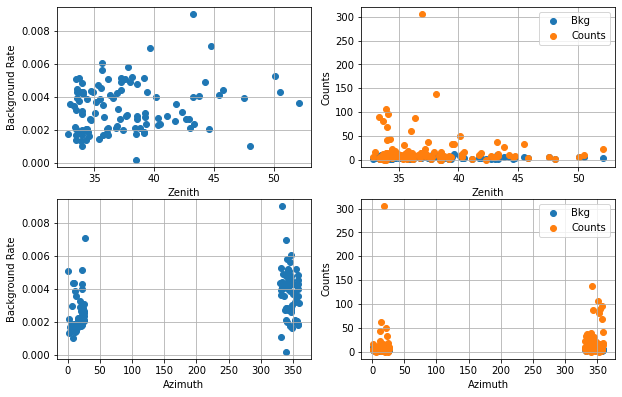

In [279]:
# Full Observations


a = list_of_datasets.info_table(cumulative=False)



zen_col = list(obs_table["ZEN_PNT"])
az_col = list(obs_table["AZ_PNT"])


from astropy.table import Column

zen_col = Column(data=zen_col, name="Zenith")
az_col = Column(data=az_col, name="Azimuth")
from astropy.table import hstack
a = hstack([a, zen_col, az_col])
a

excess_rate = []
count_rate = []
bkg_rate = []
ontime = []
for i in range(len(list(a["counts"]))):
    count = list(a["counts"])[i]
    bkg_count = list(a["background"])[i]
    exc_count = list(a['excess'])[i]
    on_time = list(a["ontime"])[i]
    excess_rate.append(exc_count/on_time)
    count_rate.append(count/on_time)
    bkg_rate.append(bkg_count/on_time)
    ontime.append(on_time/3600)
a["counts_rate"] = count_rate * 1/u.s
a["excess_rate"] = excess_rate * 1/u.s
a["background_rate"] = bkg_rate* 1/u.s
a["ontime"] = ontime*u.hr



fig = plt.figure(figsize = (10, 10))
# Background Rate vs Zenith
plt.subplot(3, 2, 1)
plt.scatter(list(a["Zenith"]), list(a["background_rate"]), label="background_rate vs Zenith")
plt.xlabel("Zenith")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 2)
plt.scatter(list(a["Zenith"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Zenith"]), list(a["counts"]), label="Counts")
plt.xlabel("Zenith")
plt.ylabel("Counts")
plt.legend()
plt.grid()

# Background Rate vs Azimuth
plt.subplot(3, 2, 3)
plt.scatter(list(a["Azimuth"]), list(a["background_rate"]), label="background_rate vs Azimuth")
plt.xlabel("Azimuth")
plt.ylabel("Background Rate")
#plt.legend()
plt.grid()

# Background Count
plt.subplot(3, 2, 4)
plt.scatter(list(a["Azimuth"]), list(a["background"]), label="Bkg")
plt.scatter(list(a["Azimuth"]), list(a["counts"]), label="Counts")
plt.xlabel("Azimuth")
plt.ylabel("Counts")
plt.legend()
plt.grid()


#a["counts","background","excess", "sqrt_ts", "ontime", "counts_rate", 'background_rate',"excess_rate"]

<Table length=9>
         E                   dNdE          ...        nuFnu_ul        Sigma 
        TeV            1 / (cm2 s TeV)     ...     erg / (cm2 s)            
      float64              float64         ...        float64        float64
------------------- ---------------------- ... --------------------- -------
0.39810717055349704  9.289101348490516e-11 ...                   0.0     0.0
 0.6309573444801928   3.93912961035587e-11 ...                   0.0     0.0
 0.9999999999999992 1.1322550027242778e-11 ...                   0.0     0.0
  1.584893192461112 3.0321840502486603e-12 ...                   0.0     0.0
 2.5118864315095766  9.371011122583764e-13 ...                   0.0     0.0
 3.9810717055349683  2.474723218127212e-13 ...                   0.0     0.0
  6.309573444801928  4.897301864023439e-14 ...                   0.0     0.0
  9.999999999999988   6.62638989351762e-15 ...                   0.0     0.0
  15.84893192461111                    0.0 ... 5.632313822730198e-13     0.0

# Model +Fit

### Choosing the datasets

In [26]:
# [list_of_spec_ref, list_map_FOV,  list_spec_FOV, list_map_ring, list_spec_ring]
list_of_datasets = list_map_ring
# [stacked_spec_ref, stacked_map_FOV, stacked_spec_FOV, stacked_map_ring, stacked_spec_ring]
stacked =stacked_spec_ring

### Specifying the Model (note: change the lon and lat)

In [27]:


#GaussianSpatialModel(lon_0="276.5625 deg", lat_0="-14.825 deg", sigma="0.2 deg",frame="icrs")
spatial_model = PointSpatialModel(lon_0="107.61 deg", lat_0="59.15 deg",)#evaluation_radius= "0.089 deg")
spatial_model.lat_0.frozen = True
spatial_model.lon_0.frozen = True

# Mrk 501
#spatial_model = PointSpatialModel(lon_0="253.468 deg", lat_0="39.7603 deg", evaluation_radius= "0.005 deg")



spatial_model.lat_0.frozen = True
spatial_model.lon_0.frozen = True



spectral_model = PowerLawSpectralModel(index=2.45, amplitude=1.80e-11*u.Unit("cm-2 s-1 TeV-1"))


model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    apply_irf={"exposure": True, "psf": True, "edisp": True},
    name = "Mrk501"
)


for dataset in list_of_datasets:
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    

models = Models([model, bkg_model])
print(models)
# Joint Models
list_of_datasets.models = models.copy()
# Stacked Models
stacked.models = models.copy()
stacked.background_models  =FoVBackgroundModel(dataset_name="s7y71hwdnj")

Models

Component 0: SkyModel

  Name                      : Mrk501
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.450              
    amplitude               :   1.80e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   : 107.610  deg         
    lat_0        (frozen)   :  59.150  deg         

Component 1: FoVBackgroundModel

  Name                      : 81049-bkg
  Datasets names            : ['81049']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         




In [28]:
%%time
#Model Fitting
#Joint --> Not realistic to plot the Joint when you got so many runs
"""
fit_joint= Fit(list_of_datasets)
result_joint = fit_joint.run(optimize_opts={"print_level": 1})
print(result_joint)
"""
# Stacked
fit_stacked= Fit(stacked)
result_stacked = fit_stacked.run(optimize_opts={"print_level": 1})
print(result_stacked)


------------------------------------------------------------------
| FCN = 10.6                    |     Ncalls=138 (138 total)     |
| EDM = 7.44E-07 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 138
	total stat : 10.60

CPU times: user 1.02 s, sys:

### Joint Analysis

In [592]:
result_joint.parameters.to_table()

<Table length=8>
   name      value         unit         min        max    frozen   error  
   str9     float64       str14       float64    float64   bool   float64 
--------- ----------- -------------- ---------- --------- ------ ---------
    index  2.2784e+00                       nan       nan  False 3.595e-02
amplitude  4.0207e-12 cm-2 s-1 TeV-1        nan       nan  False 1.036e-13
reference  1.0000e+00            TeV        nan       nan   True 0.000e+00
    lon_0  2.7656e+02            deg        nan       nan   True 0.000e+00
    lat_0 -1.4825e+01            deg -9.000e+01 9.000e+01   True 0.000e+00
     norm  1.0000e+00                       nan       nan  False 1.414e+00
     tilt  0.0000e+00                       nan       nan   True 0.000e+00
reference  1.0000e+00            TeV        nan       nan   True 0.000e+00

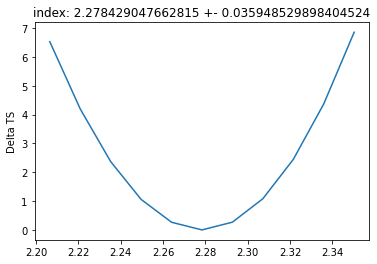

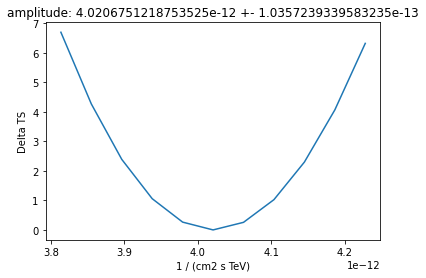

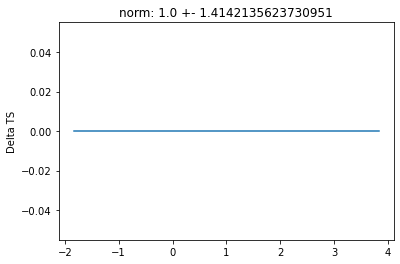

In [593]:
total_stat = result_joint.total_stat
joint_fit = fit_joint

for par in dataset.models.parameters:
    if par.frozen is False:
        profile=joint_fit.stat_profile(parameter=par)
        plt.plot(profile[f"{par.name}_scan"], profile["stat_scan"]-total_stat)
        plt.xlabel(f"{par.unit}")
        plt.ylabel("Delta TS")
        plt.title(f"{par.name}: {par.value} +- {par.error}")
        plt.show()
        plt.close()

In [273]:
%cache
def make_contours(fit, result, npoints, sigmas):
    cts_sigma = []
    for sigma in sigmas:
        contours = dict()
        for par_1, par_2 in combinations(["index", "amplitude"], r=2):
            contour = fit.minos_contour(
                result.parameters[par_1],
                result.parameters[par_2],
                numpoints=npoints,
                sigma=sigma,
            )
            contours[f"contour_{par_1}_{par_2}"] = {
                par_1: contour[par_1].tolist(),
                par_2: contour[par_2].tolist(),
            }
        cts_sigma.append(contours)
    return cts_sigma

sigma = [1, 2]
cts_sigma = make_contours(joint_fit, result_joint, 3, sigma)

pars = {
    
    "amplitude": "I",
    "index": r"$\Gamma$",
}

panels = [
    {
        "x": "index",
        "y": "amplitude",
        "cx": (lambda ct: ct["contour_index_amplitude"]["index"]),
        "cy": (
            lambda ct: np.array(1e11)
            * ct["contour_index_amplitude"]["amplitude"]
        ),
    },
]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
colors = ["m", "c", "b", "r"]
for p in panels:
    xlabel = pars[p["x"]]
    ylabel = pars[p["y"]]
    for ks in range(len(cts_sigma)):
        plot_contour_line(
            ax,
            p["cx"](cts_sigma[ks]),
            p["cy"](cts_sigma[ks]),
            lw=2.5,
            color=colors[ks],
            label=f"{sigma[ks]}" + r"$\sigma$",
        )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
plt.legend()
plt.tight_layout()

## PLOTTING POINTS!
plt.scatter(x=2.21, y=1.75e-1)

UsageError: Line magic function `%cache` not found.


### Stacked Analysis

In [18]:
result_stacked.parameters.to_table()

<Table length=5>
   name     value         unit         min        max    frozen   error  
   str9    float64       str14       float64    float64   bool   float64 
--------- ---------- -------------- ---------- --------- ------ ---------
    index 3.6039e+00                       nan       nan  False 3.220e-01
amplitude 9.9034e-14 cm-2 s-1 TeV-1        nan       nan  False 2.452e-14
reference 1.0000e+00            TeV        nan       nan   True 0.000e+00
    lon_0 1.0761e+02            deg        nan       nan   True 0.000e+00
    lat_0 5.9150e+01            deg -9.000e+01 9.000e+01   True 0.000e+00

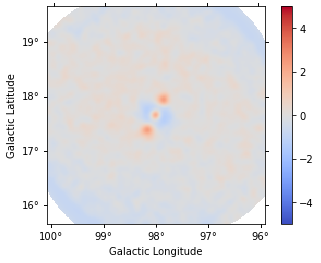

In [648]:
#plt.figure(figsize=(8,8))
#stacked.plot_fit()

#stacked.plot_residuals_spectral(region=on_region)
stacked.plot_residuals_spatial(method='diff/sqrt(model)', smooth_radius= 0.05*u.deg, cmap="coolwarm")

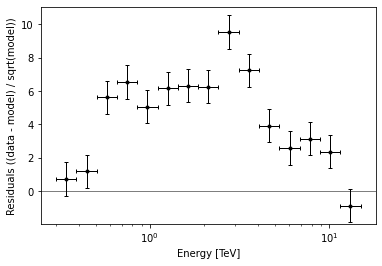

In [649]:
stacked.plot_residuals_spectral(region=on_region, method='diff/sqrt(model)')

In [215]:
#stacked.plot_residuals_spatial(vmin=-1, vmax=1);
#stacked.plot_residuals_spectral(region=region, method='diff/sqrt(model)')
"""
def plot_spectrum(model, result, label, color):
    spec = model.spectral_model
    energy_range = [0.30, 20] * u.TeV
    spec.plot(
        energy_range=energy_range, energy_power=2, label=label, color=color
    )
    spec.plot_error(energy_range=energy_range, energy_power=2, color=color)
plot_spectrum(stacked.models, result_stacked, label="stacked", color="tab:blue")
plot_spectrum(list_of_datasets.models, result_joint, label="joint", color="tab:orange")
plt.legend()
"""

'\ndef plot_spectrum(model, result, label, color):\n    spec = model.spectral_model\n    energy_range = [0.30, 20] * u.TeV\n    spec.plot(\n        energy_range=energy_range, energy_power=2, label=label, color=color\n    )\n    spec.plot_error(energy_range=energy_range, energy_power=2, color=color)\nplot_spectrum(stacked.models, result_stacked, label="stacked", color="tab:blue")\nplot_spectrum(list_of_datasets.models, result_joint, label="joint", color="tab:orange")\nplt.legend()\n'

In [23]:
# SKYMAP

estimator = ExcessMapEstimator(
    correlation_radius="0.05 deg",
    selection_optional=[],
    #energy_edges=[0.2, 40, 50] * u.TeV,
    apply_mask_fit=True
)
result = estimator.run(stacked)
print(result)

{'counts': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (200, 200, 1)
	ndim  : 3
	unit  : 
	dtype : float32
, 'background': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (200, 200, 1)
	ndim  : 3
	unit  : 
	dtype : float32
, 'excess': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (200, 200, 1)
	ndim  : 3
	unit  : 
	dtype : float32
, 'ts': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (200, 200, 1)
	ndim  : 3
	unit  : 
	dtype : float32
, 'sqrt_ts': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (200, 200, 1)
	ndim  : 3
	unit  : 
	dtype : float32
, 'err': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (200, 200, 1)
	ndim  : 3
	unit  : 
	dtype : float32
, 'flux': WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (200, 200, 1)
	ndim  : 3
	unit  : 1 / (cm2 s)
	dtype : float64
}


/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(<Figure size 648x648 with 4 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7faabdb68080>)

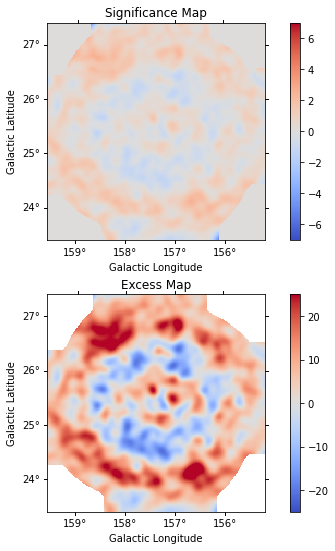

In [24]:
plt.figure(figsize=(9,9))
plt.subplots_adjust(hspace=0.25)
ax1 = plt.subplot(211, projection=result["sqrt_ts"].geom.wcs)
result["excess"].geom.wcs.projection="galactic"
ax2 = plt.subplot(212, projection=result["excess"].geom.wcs)

ax1.set_title("Significance Map")
result["sqrt_ts"].smooth("0.06 deg").reduce(axis_name="energy").plot(ax=ax1, add_cbar=True, cmap="coolwarm", vmin=-7, vmax=7)

print()

ax2.set_title("Excess Map")
result["excess"].smooth("0.07 deg").plot(ax=ax2, add_cbar=True,cmap="coolwarm", vmin=-25, vmax=25)



(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7fa9ececc5c0>)

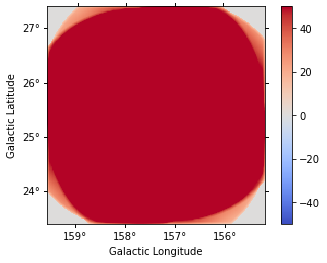

In [25]:
result["background"].sum_over_axes().plot(add_cbar=True, vmin=-50, vmax=50, cmap="coolwarm")
#result["counts"].sum_over_axes().plot(add_cbar=True,cmap="coolwarm", vmin=-50, vmax=50)

In [ ]:

#counts : correlated counts map
#background : correlated background map
#excess : correlated excess map
#ts : TS map
#sqrt_ts : sqrt(delta TS), or Li-Ma significance map
#err : symmetric error map (from covariance)
#flux : flux map. An exposure map must be present in the dataset to compute flux map
#errn : negative error map
#errp : positive error map
#ul : upper limit map

result_d = result["sqrt_ts"].smooth(0.05 * u.deg).reduce(axis_name="energy")
result_d.plot(cmap="coolwarm", add_cbar=True, vmin=-20, vmax=20);

#result["background"].reduce(axis_name="energy").plot(cmap="coolwarm", add_cbar=True, vmin=-10, vmax=10)



In [605]:
a=[]
for i in range(0,200):
    a.append(result_d.interp_by_pix(pix=(125,i), fill_value=None))
b=[]
for i in range(0,200):
    b.append(result_d.interp_by_pix(pix=(i,125), fill_value=None))
#result_d.plot(slice={"lon_0":[83.5,83.7]})

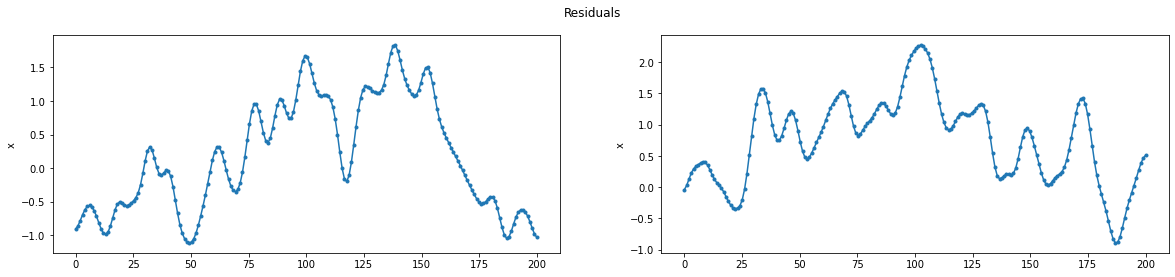

In [606]:
x1 = np.linspace(0.0, 200,200)

fig, (ax1,ax2) = plt.subplots(1, 2)
fig.suptitle('Residuals')
fig.set_figwidth(20)
ax1.plot(x1, a, 'o-',markersize=3)
ax1.set_ylabel('x')
ax2.plot(x1, b, 'o-',markersize=3)
ax2.set_ylabel('x')
plt.show()

In [29]:

energy_edges = np.linspace(0.30, 16, 9)*u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges)


# Joint
"""
flux_points_joint = fpe.run(datasets=list_of_datasets)
flux_points_datasets = FluxPointsDataset(data=flux_points_joint, models=list_of_datasets.models)
"""



# Stacked
flux_points = fpe.run(datasets=stacked)
flux_points_stacked = FluxPointsDataset(data=flux_points, models=stacked.models)



In [ ]:
# JOINT
flux_points_joint.table

In [629]:
# STACKED
flux_points.table

<Table length=8>
counts [1]       e_ref        ...       dnde_errp              dnde_errn       
                  TeV         ...    1 / (cm2 s TeV)        1 / (cm2 s TeV)    
  int64         float64       ...        float64                float64        
---------- ------------------ ... ---------------------- ----------------------
     94433 0.8514907266486506 ... 2.6932729419007874e-13  2.675710476350952e-13
      1342 3.1369186577738195 ... 4.8862552553981876e-14 4.7099349505423056e-14
       482  5.284849099544955 ...  1.837904678248294e-14 1.7327785452897912e-14
       109  7.815010964380369 ... 1.0688433228091439e-14  9.161649851102277e-15
         0  9.078374028426015 ...                    nan                    nan
        65 10.143650067093624 ... 1.8506319273870463e-13 1.4538736711612919e-13
        36  13.16615384835952 ...  9.755720677806692e-14 1.3447324031046655e-13
         0  14.98666073546739 ...                    nan                    nan

In [303]:
#Joint & Stacked

plt.figure(figsize = (8, 8))

flux_points_datasets.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"Joint");


counts_list = flux_points_joint.table["counts"]
sqrt_ts_list = flux_points_joint.table["sqrt_ts"]

# For the ED DATA
ax_spectrum.errorbar(spectrum["E"], spectrum["dNdE"], yerr=spectrum["dNdE_erru"], fmt="o",label="EventDisplay")

count = 0
for [x, y] in zip(flux_points_joint.table["e_ref"], flux_points_joint.table["dnde"]):
    label = f"{counts_list[count].sum()} counts, sig:{round(sqrt_ts_list[count], 2)}".format(y)
    count += 1
    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,20), 
                 ha='center', rotation=90)
plt.legend()
plt.grid()
plt.ylim([1e-17, 1e-9])


NameError: name 'flux_points_datasets' is not defined

<Figure size 576x576 with 0 Axes>

[9.05322240619403, 1.8125914476688296, 0.7554942858260899, 0.5978290782617608, nan, -1.006262907881715, 1.276858220929537, nan]


(1e-20, 1e-09)

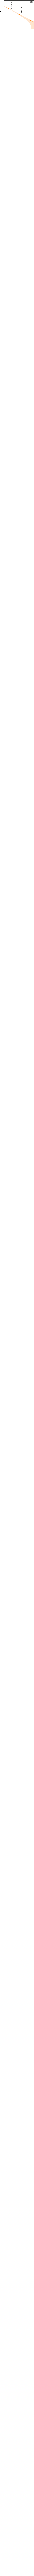

In [31]:
counts_list = list(flux_points.table["counts"])
sqrt_ts_list = list(flux_points.table["sqrt_ts"])
print(sqrt_ts_list)
plt.figure(figsize = (8, 8))
flux_points_stacked.plot_spectrum(energy_power=0, flux_unit="TeV-1 cm-2 s-1", label=f"Stacked");
plt.legend()
plt.grid()
plt.ylim([1e-17, 1e-9])
count = 0

# For the ED DATA
#plt.errorbar(spectrum["E"], spectrum["dNdE"], yerr=spectrum["dNdE_erru"], fmt="o",label="EventDisplay")

for [x, y] in zip(flux_points.table["e_ref"], flux_points.table["dnde"]):
    label = f"{counts_list[count].sum()} counts, sig:{round(sqrt_ts_list[count].sum(), 2)}".format(y)
    count += 1
    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,20), 
                 ha='center', rotation=90)
   
plt.legend()
plt.grid()
plt.ylim([1e-20, 1e-9])

In [548]:
# BECAUSE THERE IS AN ISSUE WITH THE 3D ANALYSIS, WE CANNOT COMPUTE THE LIGHT CURVE WITHOUT GETTING WEIRD RUNS...

In [540]:
lc_maker_1d = LightCurveEstimator(energy_edges=[energy_axis.edges[0], energy_axis.edges[-1]], reoptimize=False)
lc_complete = lc_maker_1d.run(list_of_datasets)



In [541]:
# LOOK AT THIS FILE: THE ISSUE RIGHT THERE. BECAUSE THE DATASETS ARE INCORRECT, YOU'VE GOT SOME PTS THAT ARE FALSE, WHICH CONTAINS COUNTS. THAT'S A HUGE PROBLEM. THE A=ONLY ANALYSIS WE CAN DO IN THIS CASE IS WITH THE SPECTRUM DATASETS.

lc_complete.table

<Table length=306>
     time_min           time_max      ...     flux_errn [1]     
                                      ...      1 / (cm2 s)      
     float64            float64       ...        float64        
------------------ ------------------ ... ----------------------
54834.231600845815 54834.245517587835 ...  3.512536242515892e-12
 54834.24605680037  54834.25997530168 ...  7.229233411568999e-15
 54834.26058589172  54834.27450352736 ... 4.5783123901631826e-15
 54847.27194357886  54847.28586357901 ... 2.6242782635851535e-15
 54848.31110602452  54848.32502344988 ...  7.559210775406458e-16
 54848.32597274399 54848.336551775916 ... 4.0916144500435737e-13
54848.337334348704 54848.351252644614 ...  2.067025294501548e-12
 54849.36816177231  54849.38208813687 ...  1.602036759134645e-15
 54849.38271244811  54849.39663050972 ... 1.4209910432750563e-15
               ...                ... ...                    ...
 57418.24067558799  57418.26151037189 ...  7.190604966815633e-13
 57421.18028845405 57421.201125315216 ...  1.465495689250488e-12
 57421.20143232822  57421.21185013771 ...                    nan
 57426.26490086232  57426.28573736319 ... 1.0105779016286067e-12
57426.286255708204  57426.30709068199 ... 1.6352129627241915e-13
 57427.20027074823 57427.221107704725 ...   6.84493363723381e-15
   57427.221717504 57427.242554076256 ... 1.0486730020325941e-12
57447.193758964684 57447.214594133155 ...   9.80608280212187e-16
57456.225384472826  57456.24621964592 ...  5.552007266259643e-13
 57456.24696624392 57456.267801319955 ...   7.16304056999435e-13

In [542]:
# FOR THE DATA OF ED
'''
# There is some runs with a flux of -999.0 in the lightcurve of ED that need to be removed:
time_ED = list(lightcurve["MJD"])
time_err_ED = list(lightcurve["MJD_err"])
flux_ED = list(lightcurve["Flux"])
flux_err_ED = list(lightcurve["Flux_err"])

bad_runs_id = []
for i, flux in enumerate(flux_ED):
    if abs(flux)> 1:
        bad_runs_id.append(i)

        
x_axis_lc = []
x_axis_err_lc = []
y_axis_lc = []
y_axis_err_lc=[]
mean_y_axis_lc = 0
for i in range(len(time_ED)):
    if i in bad_runs_id:
        continue
    else:
        x_axis_lc.append(time_ED[i])
        x_axis_err_lc.append(time_err_ED[i])
        y_axis_lc.append(flux_ED[i])
        y_axis_err_lc.append(flux_err_ED[i])
        mean_y_axis_lc += flux_ED[i]
mean_y_axis_lc = mean_y_axis_lc / len(y_axis_lc)
'''



'\n# There is some runs with a flux of -999.0 in the lightcurve of ED that need to be removed:\ntime_ED = list(lightcurve["MJD"])\ntime_err_ED = list(lightcurve["MJD_err"])\nflux_ED = list(lightcurve["Flux"])\nflux_err_ED = list(lightcurve["Flux_err"])\n\nbad_runs_id = []\nfor i, flux in enumerate(flux_ED):\n    if abs(flux)> 1:\n        bad_runs_id.append(i)\n\n        \nx_axis_lc = []\nx_axis_err_lc = []\ny_axis_lc = []\ny_axis_err_lc=[]\nmean_y_axis_lc = 0\nfor i in range(len(time_ED)):\n    if i in bad_runs_id:\n        continue\n    else:\n        x_axis_lc.append(time_ED[i])\n        x_axis_err_lc.append(time_err_ED[i])\n        y_axis_lc.append(flux_ED[i])\n        y_axis_err_lc.append(flux_err_ED[i])\n        mean_y_axis_lc += flux_ED[i]\nmean_y_axis_lc = mean_y_axis_lc / len(y_axis_lc)\n'

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
No handles with labels found to put in legend.
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
No handles with labels found to put in legend.


273 273 273


(-1e-13, 1e-10)

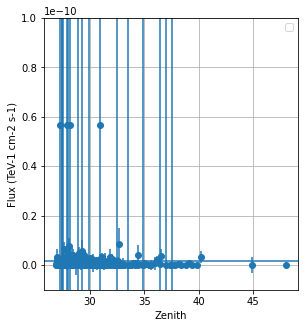

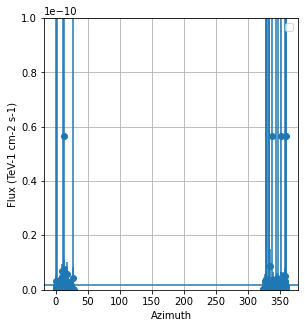

In [550]:

time_axis = []
x_axis1 = []
x_axis2 = []
y_axis = []
y_error_axis = []
for ind in range(len(obs_table["AZ_PNT"])):
    if list(lc_complete.table["flux"])[ind] > 0:
        x_axis2.append(list(obs_table["AZ_PNT"])[ind])
        x_axis1.append(list(obs_table["ZEN_PNT"])[ind])
        y_axis.append(list(lc_complete.table["flux"])[ind])
        y_error_axis.append(list(lc_complete.table["flux_err"])[ind])
        time_axis.append(((lc_complete.table["time_min"])[ind]))
        


print(len(x_axis1), len(x_axis2), len(y_axis))
plt.figure(figsize=(10,5))
plt.subplot(1, 2,1)
plt.errorbar(x=x_axis1,y=y_axis, yerr=y_error_axis, fmt="o")
#plt.scatter(x=x_axis1, y=y_axis, fmt="o")
plt.axhline(y=np.array(y_axis).mean(), color="tab:blue")
plt.ylim([-1e-11, 1e-10])
plt.xlabel("Zenith")
plt.ylabel("Flux (TeV-1 cm-2 s-1)")
plt.legend()
plt.grid()
        
plt.figure(figsize=(10,5))    
plt.subplot(1, 2, 2)
plt.errorbar(x=x_axis2,y=y_axis, yerr=y_error_axis, fmt="o")
plt.axhline(y=np.array(y_axis).mean(), color="tab:blue")
plt.xlabel("Azimuth")
plt.ylabel("Flux (TeV-1 cm-2 s-1)")
plt.legend()
plt.grid()
plt.ylim([-1e-13, 1e-10])


/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  This is separate from the ipykernel package so we can avoid doing imports until


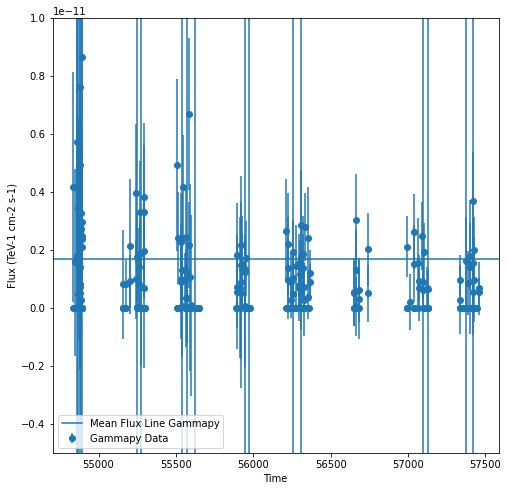

In [562]:
plt.figure(figsize=(8,8))

plt.errorbar(x=time_axis,y=y_axis, yerr=y_error_axis, fmt="o", label="Gammapy Data")
plt.axhline(y=np.array(y_axis).mean(), color="tab:blue", label="Mean Flux Line Gammapy")
plt.xlabel("Time")
plt.ylabel("Flux (TeV-1 cm-2 s-1)")
plt.legend()
plt.ylim([-1e-11, 1e-10])
plt.grid()

# FOR ED
'''


plt.errorbar(x=x_axis_lc, y=y_axis_lc, xerr=x_axis_err_lc, yerr=y_axis_err_lc,fmt="o",label="EventDisplay", color="red")
plt.axhline(y=mean_y_axis_lc, color="red", label="Mean Flux Line ED")
plt.legend()
# THERE ARE LESS RUNS IN ED DATA, but yes in general ED data are larger. Might have something to do with the total counts
'''


plt.ylim([-0.5e-11, 0.10e-10])
plt.grid()

In [545]:
list_of_dataset = list_of_datasets
lc_1d = lc_complete
if list_of_dataset[0].gti.time_start.value > list(lc_1d.table["time_min"])[0]:
    time_start = Time(list(lc_1d.table["time_min"])[0], format="mjd", scale="utc")
else:
    time_start = list_of_dataset[0].gti.time_start

time = float(time_start.value)


if list_of_dataset[-1].gti.time_stop.value > list(lc_1d.table["time_max"])[-1]:
    time_end = list_of_dataset[-1].gti.time_stop
else:
    time_end = Time(list(lc_1d.table["time_max"])[-1], format="mjd", scale="utc")


time_intervals = []
count = 0
while time < (float(time_end.value)+3):
    t_plus_one = time + 1
    time_intervals.append(Time([time, t_plus_one], format="mjd", scale="utc"))
    time = t_plus_one
    for i in range(count, len(observations), 1):
        count +=1
        if float(list_of_dataset[i].gti.time_start.value) > time:
            time = int(list_of_dataset[i].gti.time_start.value)
            count = i
            break



print(time_intervals)

[<Time object: scale='utc' format='mjd' value=[54834.23083483 54835.23083483]>, <Time object: scale='utc' format='mjd' value=[54847. 54848.]>, <Time object: scale='utc' format='mjd' value=[54848. 54849.]>, <Time object: scale='utc' format='mjd' value=[54849. 54850.]>, <Time object: scale='utc' format='mjd' value=[54862. 54863.]>, <Time object: scale='utc' format='mjd' value=[54863. 54864.]>, <Time object: scale='utc' format='mjd' value=[54864. 54865.]>, <Time object: scale='utc' format='mjd' value=[54865. 54866.]>, <Time object: scale='utc' format='mjd' value=[54875. 54876.]>, <Time object: scale='utc' format='mjd' value=[54876. 54877.]>, <Time object: scale='utc' format='mjd' value=[54877. 54878.]>, <Time object: scale='utc' format='mjd' value=[54879. 54880.]>, <Time object: scale='utc' format='mjd' value=[54881. 54882.]>, <Time object: scale='utc' format='mjd' value=[54882. 54883.]>, <Time object: scale='utc' format='mjd' value=[54883. 54884.]>, <Time object: scale='utc' format='mjd'

In [546]:
%%time
lc_maker_1d.time_intervals=time_intervals

nightwise1_lc = lc_maker_1d.run(list_of_datasets)



CPU times: user 11min 40s, sys: 14.5 s, total: 11min 54s
Wall time: 12min 35s


In [547]:
nightwise1_lc.table

<Table length=138>
     time_min           time_max      ...     flux_errn [1]     
                                      ...      1 / (cm2 s)      
     float64            float64       ...        float64        
------------------ ------------------ ... ----------------------
54834.231600845815 54835.231600845815 ...   9.86943806693703e-16
54847.000766018515 54848.000766018515 ... 2.6242782635851535e-15
54848.000766018515 54849.000766018515 ... 1.1450257632950757e-15
54849.000766018515 54850.000766018515 ... 1.1166933119484766e-15
54862.000766018515 54863.000766018515 ... 2.4847721688426608e-12
54863.000766018515 54864.000766018515 ...  6.390092492536313e-14
54864.000766018515 54865.000766018515 ...  4.139826617173456e-15
54865.000766018515 54866.000766018515 ...  8.694693067242972e-16
54875.000766018515 54876.000766018515 ...  2.975785207785644e-16
               ...                ... ...                    ...
 57374.00078916667  57375.00078916667 ... 2.0312135571575802e-15
 57389.00078916667  57390.00078916667 ... 1.0265085939645062e-13
 57397.00078916667  57398.00078916667 ... 1.4918278955052582e-12
 57400.00078916667  57401.00078916667 ...  1.593938733659433e-13
 57418.00078916667  57419.00078916667 ...  9.463102555192394e-13
 57421.00078916667  57422.00078916667 ...  7.538377595416608e-14
 57426.00078916667  57427.00078916667 ...  6.412536982128123e-13
 57427.00078916667  57428.00078916667 ...  8.205986943295868e-14
 57447.00078916667  57448.00078916667 ...   9.80608280212187e-16
 57456.00078916667  57457.00078916667 ...  4.568146091148503e-13

In [548]:

night_y = []
night_y_err = []
night_time_axis = []
for ind in range(len(list(nightwise1_lc.table["flux"]))):
    if list(nightwise1_lc.table["flux"])[ind] > 0:
        night_y.append(list(nightwise1_lc.table["flux"])[ind])
        night_y_err.append(list(nightwise1_lc.table["flux_err"])[ind])
        night_time_axis.append(((nightwise1_lc.table["time_min"])[ind]))

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  This is separate from the ipykernel package so we can avoid doing imports until
No handles with labels found to put in legend.


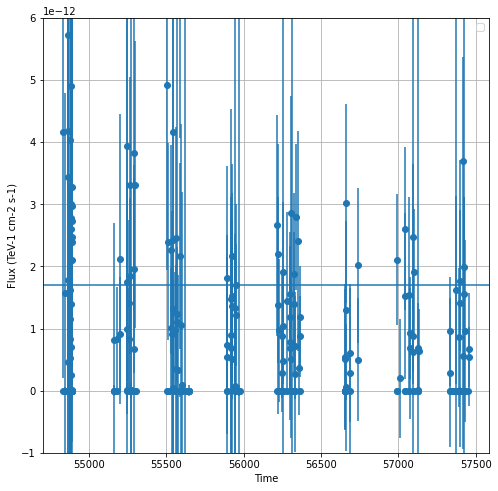

In [555]:
plt.figure(figsize=(8,8))

plt.errorbar(x=time_axis,y=y_axis, yerr=y_error_axis, fmt="o")
plt.axhline(y=np.array(y_axis).mean(), color="tab:blue")
plt.xlabel("Time")
plt.ylabel("Flux (TeV-1 cm-2 s-1)")
plt.legend()
plt.ylim([-1e-12, 0.6e-11])
plt.grid()

In [422]:
%%time
#Identify the largest value of the flux:


flux_list = list(lc_1d.table["flux"])
time_min_list = list(lc_1d.table["time_min"])
time_max_list = list(lc_1d.table["time_max"])
max_value = max(flux_list)
index = flux_list.index(max_value)
time_start = time_min_list[index]
print(time_start)
"""
# For the second value:
flux_list.pop(index)
max_value = max(flux_list)
index = flux_list.index(max_value)
print(time_min_list[index])
time_start = time_min_list[index]
# The third value
flux_list.pop(index)
max_value = max(flux_list)
index = flux_list.index(max_value)
print(time_min_list[index])
time_start = time_min_list[index]
"""
# Creating the time interval:
# We break it up into 8 min bins for a total duration of 240 min (30 bins). 
duration =3 * u.min
n_time_bins = 30

time_list = Time(time_start, format="mjd", scale="utc")+np.arange(n_time_bins+1)*duration
time_intervals = [Time([tstart, tstop]) for tstart, tstop in zip(time_list[:-1], time_list[1:])]
"""
# Prevent the overlap between time_intervals.
for el in time_intervals:
    el[0] -= 0.0000001
"""

print(time_intervals)

filt_observations = observations.select_time(time_intervals)





57552.327347891034
[<Time object: scale='utc' format='mjd' value=[57552.32734789 57552.32943122]>, <Time object: scale='utc' format='mjd' value=[57552.32943122 57552.33151456]>, <Time object: scale='utc' format='mjd' value=[57552.33151456 57552.33359789]>, <Time object: scale='utc' format='mjd' value=[57552.33359789 57552.33568122]>, <Time object: scale='utc' format='mjd' value=[57552.33568122 57552.33776456]>, <Time object: scale='utc' format='mjd' value=[57552.33776456 57552.33984789]>, <Time object: scale='utc' format='mjd' value=[57552.33984789 57552.34193122]>, <Time object: scale='utc' format='mjd' value=[57552.34193122 57552.34401456]>, <Time object: scale='utc' format='mjd' value=[57552.34401456 57552.34609789]>, <Time object: scale='utc' format='mjd' value=[57552.34609789 57552.34818122]>, <Time object: scale='utc' format='mjd' value=[57552.34818122 57552.35026456]>, <Time object: scale='utc' format='mjd' value=[57552.35026456 57552.35234789]>, <Time object: scale='utc' format

In [423]:
filt_list_datasets = Datasets()
count = 1
for obs in filt_observations:
    dataset = dataset_maker.run(dataset_empty.copy(name=f"filt_observations_{count}"), obs)
    dataset = safe_mask_maker.run(dataset, obs)
    filt_list_datasets.append(dataset)
    count +=1
    


/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/a

In [424]:
print(filt_observations)

Observations
Number of observations: 10
Observation

	obs id            : 82514 
 	tstart            : 57552.33
	tstop             : 57552.33
	duration          : 180.00 s
	pointing (icrs)   : 300.0 deg, 64.6 deg

	deadtime fraction : 10.0%
Observation

	obs id            : 82514 
 	tstart            : 57552.33
	tstop             : 57552.33
	duration          : 180.00 s
	pointing (icrs)   : 300.0 deg, 64.6 deg

	deadtime fraction : 10.0%
Observation

	obs id            : 82514 
 	tstart            : 57552.33
	tstop             : 57552.33
	duration          : 180.00 s
	pointing (icrs)   : 300.0 deg, 64.6 deg

	deadtime fraction : 10.0%
Observation

	obs id            : 82514 
 	tstart            : 57552.33
	tstop             : 57552.34
	duration          : 180.00 s
	pointing (icrs)   : 300.0 deg, 64.6 deg

	deadtime fraction : 10.0%
Observation

	obs id            : 82514 
 	tstart            : 57552.34
	tstop             : 57552.34
	duration          : 180.00 s
	pointing (icrs)   : 300

In [425]:
for ind, dataset in enumerate(filt_list_datasets):
    models_1 = Models([model, bkg_model])
    models_1.name =  f"filt_list_datasets_{ind}"
    dataset.models = models_1
    print(dataset.models)


DatasetModels

Component 0: SkyModel

  Name                      : Mrk501
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.450              
    amplitude               :   1.80e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   : 276.562  deg         
    lat_0        (frozen)   : -14.825  deg         


DatasetModels

Component 0: SkyModel

  Name                      : Mrk501
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.450              
    amplitude               :   1.80e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   : 276.562  deg         
    lat_

In [426]:
lc_maker_1d.time_intervals=time_intervals
lc_cut = lc_maker_1d.run(filt_list_datasets)





RuntimeError: exception was raised in user function
User function arguments:
    par_000_norm = +100.999983


In [ ]:
lc_cut.table

In [ ]:
lc_cut.plot()
plt.ylim([1e-12, 3.2e-11])

In [508]:
##### -----------------------------------------------------------------------------####

In [453]:
obs_id_flares = [38018,
38019,
41470,
53469,
53470,
53471,
53472,
53473,
53535,
62046,
62162,
58003,
62672,
62673,
62674,
62675,
62676,
62677,
62695,
62697,
78572,
78573,
78574,
78576,
78596,
78597,
78598,
78599,
78613,
78614,
78615,
78616,
78647,
78648,
78664,
78666,
78705,
78760,
79008,
79009,
79051,
79082,
79107,
81868,
81891,
82417,
82514,
78793,
78817,
82579]

flare_obs_list = []
for id_fla in obs_id_flares:
    for i, obs_ide in enumerate(list(observations.ids)):
        if id_fla == int(obs_ide):
            flare_obs_list.append(observations[i])

In [455]:
%time
flare_datasets = Datasets()
count = 0
for obs in flare_obs_list:
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs.obs_id)), obs)
    #dataset = dataset.to_spectrum_dataset(on_region)
    dataset = bkg_maker.run(dataset, obs)
    dataset = safe_mask_maker.run(dataset, obs)
    flare_datasets.append(dataset)
    #stacked.stack(dataset)
    count+=1
# Making sure all the datasets are in the list
print(count==len(flare_obs_list))

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs


/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/a

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/a

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/a

True


In [456]:
%%time

model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    apply_irf={"exposure": True, "psf": True, "edisp": True},
    name = "Mrk501"
)

for dataset in flare_datasets:
    models_1 = Models([model, bkg_model])
    models_1.name =  f"flare_datasets_{ind}"
    dataset.models = models_1
    print(dataset.models)
    
"""  
# Performing a joint fit of the model:
fit_joint_flare = Fit(flare_datasets)
result_joint_flare = fit_joint_flare.run()
result_joint_flare.parameters.to_table()
"""  

DatasetModels

Component 0: SkyModel

  Name                      : Mrk501
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.450              
    amplitude               :   1.80e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   : 276.562  deg         
    lat_0        (frozen)   : -14.825  deg         


DatasetModels

Component 0: SkyModel

  Name                      : Mrk501
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.450              
    amplitude               :   1.80e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   : 276.562  deg         
    lat_


DatasetModels

Component 0: SkyModel

  Name                      : Mrk501
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.450              
    amplitude               :   1.80e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   : 276.562  deg         
    lat_0        (frozen)   : -14.825  deg         


DatasetModels

Component 0: SkyModel

  Name                      : Mrk501
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.450              
    amplitude               :   1.80e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   : 276.562  deg         
    lat

DatasetModels

Component 0: SkyModel

  Name                      : Mrk501
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.450              
    amplitude               :   1.80e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   : 276.562  deg         
    lat_0        (frozen)   : -14.825  deg         


DatasetModels

Component 0: SkyModel

  Name                      : Mrk501
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.450              
    amplitude               :   1.80e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   : 276.562  deg         
    lat_

'  \n# Performing a joint fit of the model:\nfit_joint_flare = Fit(flare_datasets)\nresult_joint_flare = fit_joint_flare.run()\nresult_joint_flare.parameters.to_table()\n'

In [457]:
%%time
lc_maker_flare = LightCurveEstimator(energy_edges=[energy_axis.edges[0], energy_axis.edges[-1]], reoptimize=True)

lc_flare = lc_maker_flare.run(flare_datasets)

CPU times: user 1min 16s, sys: 1.58 s, total: 1min 18s
Wall time: 1min 31s


(0.0, 2e-10)

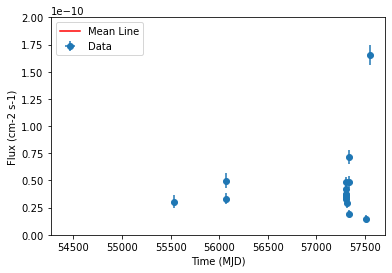

In [466]:
lc_flare.plot(marker="o", label="Data")
plt.axhline(y=lc_flare.table["flux"].mean(), color="red", label="Mean Line")
plt.legend()
plt.ylim([0, 2e-10])

In [459]:
# Low-State

In [460]:
obs_id_noF = [37793,
37890,
37991,
37992,
41472,
41478,
41713,
41960,
41961,
41962,
41963,
41964,
42073,
53504,
61991,
61992,
61993,
62015,
62016,
62017,
62018,
62082,
62109,
62137,
51601,
51602,
57377,
57379,
57857,
58002,
58026,
58279,
62596,
62720,
62748,
62773,
62793,
62822,
62884,
62917,
62993,
62994,
63006,
63171,
63722,
63723,
63767,
63854,
63928,
63998,
64085,
64182,
64518,
64643,
64694,
68985,
68986,
69022,
69068,
69140,
69192,
69233,
77945,
78168,
81841,
70031,
70032,
74392,
74394]

noF_obs_list = []
for id_no_fla in obs_id_noF:
    for i, obs_ide in enumerate(list(observations.ids)):
        if id_no_fla == int(obs_ide):
            noF_obs_list.append(observations[i])

In [461]:
%time
noF_datasets = Datasets()
count = 0
for obs in noF_obs_list:
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs.obs_id)), obs)
    #dataset = dataset.to_spectrum_dataset(on_region)
    dataset = bkg_maker.run(dataset, obs)
    dataset = safe_mask_maker.run(dataset, obs)
    noF_datasets.append(dataset)
    #stacked.stack(dataset)
    count+=1
# Making sure all the datasets are in the list
print(count==len(noF_datasets))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/a

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/a

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/a

/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/cedrickperron/opt/a

True


In [462]:

model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    apply_irf={"exposure": True, "psf": True, "edisp": True},
    name = "Mrk501"
)



for dataset in noF_datasets:
    models_1 = Models([model, bkg_model])
    models_1.name =  f"Non_flare_datasets_{ind}"
    dataset.models = models_1
    print(dataset.models)
    
"""
# Performing a joint fit of the model:
fit_joint_noF = Fit(noF_datasets)
result_joint_noF = fit_joint_noF.run()
result_joint_noF.parameters.to_table()
"""

DatasetModels

Component 0: SkyModel

  Name                      : Mrk501
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.450              
    amplitude               :   1.80e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   : 276.562  deg         
    lat_0        (frozen)   : -14.825  deg         


DatasetModels

Component 0: SkyModel

  Name                      : Mrk501
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.450              
    amplitude               :   1.80e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   : 276.562  deg         
    lat_


DatasetModels

Component 0: SkyModel

  Name                      : Mrk501
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.450              
    amplitude               :   1.80e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   : 276.562  deg         
    lat_0        (frozen)   : -14.825  deg         


DatasetModels

Component 0: SkyModel

  Name                      : Mrk501
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.450              
    amplitude               :   1.80e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0        (frozen)   : 276.562  deg         
    lat

'\n# Performing a joint fit of the model:\nfit_joint_noF = Fit(noF_datasets)\nresult_joint_noF = fit_joint_noF.run()\nresult_joint_noF.parameters.to_table()\n'

In [463]:
lc_maker_noF = LightCurveEstimator(energy_edges=[energy_axis.edges[0], energy_axis.edges[-1]], reoptimize=True)

lc_noF = lc_maker_noF.run(noF_datasets)

(-1e-09, 2e-10)

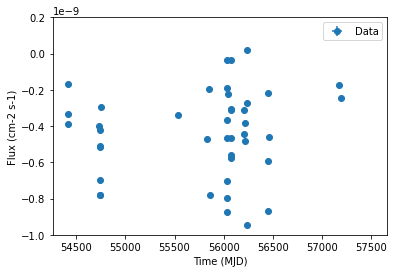

In [471]:
lc_noF.plot(marker="o", label="Data")
plt.axhline(y=lc_noF.table["flux"].mean(), color="red", label="Mean Line")
plt.ylim([-1e-9, 2e-10])

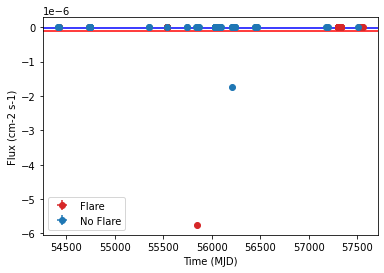

In [465]:

lc_flare.plot(marker="o", label="Flare", color="tab:red")
plt.axhline(y=lc_flare.table["flux"].mean(), color="red")
#help(plt.plot)
lc_noF.plot(marker="o", color="tab:blue", label="No Flare")
#plt.scatter(list(lc_noF.table["time_min"]), list(lc_noF.table["flux"]), color="blue",marker="o",label="No Flare")
plt.axhline(y=lc_noF.table["flux"].mean(), color="blue")
plt.legend()
plt.ylim([0, 2e-10])